<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 648, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 648 (delta 129), reused 130 (delta 64), pack-reused 443 (from 1)
Receiving objects: 100% (648/648), 3.45 MiB | 26.79 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [13]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [14]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
6.93% complete (down: 90654.0 kB/s up: 2609.7 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

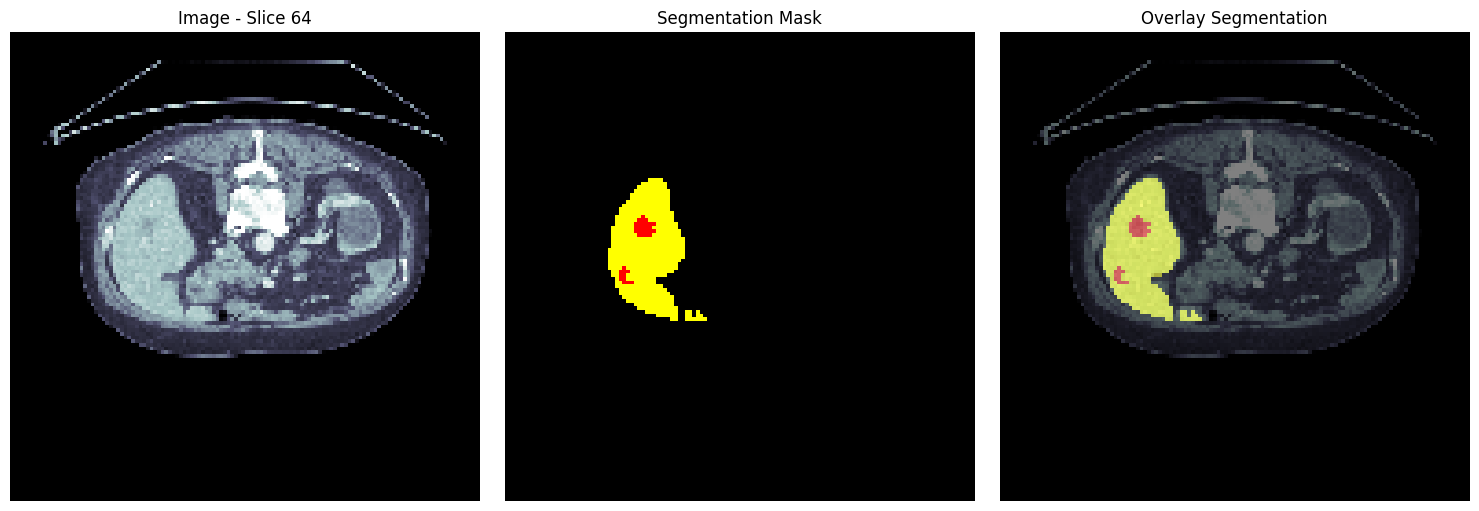

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, 0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")


    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")


    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [9]:
model = ModelFactory.get_model("unet3d",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [15]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [16]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, best_epoch, dices_liver, dices_tumor, dices_avg, loss_epochs, trains_epoch
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    scheduler = scheduler,
    batch_size = config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every = config["val_every"],
    path_save_model = config["path_save_model_state"],
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.5022 time 9.18s
Epoch 1/100 2/105 loss: 0.5076 time 8.74s
Epoch 1/100 3/105 loss: 0.5062 time 12.63s
Epoch 1/100 4/105 loss: 0.5011 time 7.05s
Epoch 1/100 5/105 loss: 0.4986 time 6.59s
Epoch 1/100 6/105 loss: 0.4987 time 2.87s
Epoch 1/100 7/105 loss: 0.4925 time 1.29s
Epoch 1/100 8/105 loss: 0.4926 time 8.81s
Epoch 1/100 9/105 loss: 0.4906 time 9.48s
Epoch 1/100 10/105 loss: 0.4890 time 3.07s
Epoch 1/100 11/105 loss: 0.4889 time 11.44s
Epoch 1/100 12/105 loss: 0.4876 time 6.05s
Epoch 1/100 13/105 loss: 0.4877 time 2.27s
Epoch 1/100 14/105 loss: 0.4849 time 1.36s
Epoch 1/100 15/105 loss: 0.4811 time 3.73s
Epoch 1/100 16/105 loss: 0.4797 time 8.16s
Epoch 1/100 17/105 loss: 0.4793 time 11.69s
Epoch 1/100 18/105 loss: 0.4783 time 2.08s
Epoch 1/100 19/105 loss: 0.4763 time 1.03s
Epoch 1/100 20/105 loss: 0.4757 time 4.85s
Epoch 1/100 21/105 loss: 0.4742 time 8.39s
Epoch 1/100 22/105 loss: 0.4742 time 1.74s
Epoch 1/100 23/105 loss: 0.4738 time 13.73s
Epoch 1/100 24/1

Final training epochs: 1/100 ---[loss: 0.4167] ---[time 648.07s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.4167] ---[time 648.07s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.4167 time 1.10s


Val 1/100 1/26, Dice_Liver: 0.657616, Dice_Tumor: 0.000000, Dice_Avg: 0.328808, time 11.72s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.657616, Dice_Tumor: 0.000000, Dice_Avg: 0.328808, time 11.72s
Val 1/100 2/26, Dice_Liver: 0.732805, Dice_Tumor: 0.000000, Dice_Avg: 0.366403, time 1.38s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.732805, Dice_Tumor: 0.000000, Dice_Avg: 0.366403, time 1.38s
Val 1/100 3/26, Dice_Liver: 0.704821, Dice_Tumor: 0.000000, Dice_Avg: 0.352411, time 5.44s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.704821, Dice_Tumor: 0.000000, Dice_Avg: 0.352411, time 5.44s
Val 1/100 4/26, Dice_Liver: 0.670690, Dice_Tumor: 0.000000, Dice_Avg: 0.335345, time 12.76s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.670690, Dice_Tumor: 0.000000, Dice_Avg: 0.335345, time 12.76s
Val 1/100 5/26, Dice_Liver: 0.719568, Dice_Tumor: 0.000000, Dice_Avg: 0.359784, time 2.31s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.719568, Dice_Tumor: 0.000000, Di

New best (0.000000 --> 0.355840). At epoch 1


Epoch 1/100 ---[loss: 0.4167] ---[val_dice: 0.355840] ---[time 158.31s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.4167] ---[val_dice: 0.355840] ---[time 158.31s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.3558 time 15.17s
Epoch 2/100 2/105 loss: 0.3368 time 1.35s
Epoch 2/100 3/105 loss: 0.3359 time 10.41s
Epoch 2/100 4/105 loss: 0.3407 time 1.43s
Epoch 2/100 5/105 loss: 0.3362 time 2.67s
Epoch 2/100 6/105 loss: 0.3440 time 8.94s
Epoch 2/100 7/105 loss: 0.3434 time 13.45s
Epoch 2/100 8/105 loss: 0.3418 time 6.51s
Epoch 2/100 9/105 loss: 0.3390 time 5.49s
Epoch 2/100 10/105 loss: 0.3398 time 0.77s
Epoch 2/100 11/105 loss: 0.3395 time 0.96s
Epoch 2/100 12/105 loss: 0.3455 time 6.92s
Epoch 2/100 13/105 loss: 0.3437 time 11.49s
Epoch 2/100 14/105 loss: 0.3423 time 7.68s
Epoch 2/100 15/105 loss: 0.3429 time 9.59s
Epoch 2/100 16/105 loss: 0.3476 time 10.97s
Epoch 2/100 17/105 loss: 0.3527 time 6.69s
Epoch 2/100 18/105 loss: 0.3549 time 8.15s
Epoch 2/100 19/105 loss: 0.3530 time 8.49s
Epoch 2/100 20/105 loss: 0.3519 time 8.01s
Epoch 2/100 21/105 loss: 0.3519 time 4.81s
Epoch 2/100 22/105 loss: 0.3527 time 11.63s
Epoch 2/100 23/105 loss: 0.3518 time 2.46s
Epoch 2/100 24

Final training epochs: 2/100 ---[loss: 0.3474] ---[time 654.16s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.3474] ---[time 654.16s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.3474 time 1.59s


Val 2/100 1/26, Dice_Liver: 0.752677, Dice_Tumor: 0.000000, Dice_Avg: 0.376338, time 10.34s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.752677, Dice_Tumor: 0.000000, Dice_Avg: 0.376338, time 10.34s
Val 2/100 2/26, Dice_Liver: 0.746947, Dice_Tumor: 0.000000, Dice_Avg: 0.373473, time 1.38s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.746947, Dice_Tumor: 0.000000, Dice_Avg: 0.373473, time 1.38s
Val 2/100 3/26, Dice_Liver: 0.770215, Dice_Tumor: 0.000000, Dice_Avg: 0.385107, time 5.49s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.770215, Dice_Tumor: 0.000000, Dice_Avg: 0.385107, time 5.49s
Val 2/100 4/26, Dice_Liver: 0.789687, Dice_Tumor: 0.000000, Dice_Avg: 0.394844, time 13.03s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.789687, Dice_Tumor: 0.000000, Dice_Avg: 0.394844, time 13.03s
Val 2/100 5/26, Dice_Liver: 0.813154, Dice_Tumor: 0.000000, Dice_Avg: 0.406577, time 2.09s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.813154, Dice_Tumor: 0.000000, Di

New best (0.355840 --> 0.405110). At epoch 2
Epoch 3/100 1/105 loss: 0.3490 time 11.24s
Epoch 3/100 2/105 loss: 0.3405 time 12.49s
Epoch 3/100 3/105 loss: 0.3364 time 4.96s
Epoch 3/100 4/105 loss: 0.3353 time 6.57s
Epoch 3/100 5/105 loss: 0.3314 time 8.31s
Epoch 3/100 6/105 loss: 0.3304 time 4.96s
Epoch 3/100 7/105 loss: 0.3306 time 11.02s
Epoch 3/100 8/105 loss: 0.3283 time 5.38s
Epoch 3/100 9/105 loss: 0.3272 time 2.09s
Epoch 3/100 10/105 loss: 0.3254 time 10.66s
Epoch 3/100 11/105 loss: 0.3238 time 2.76s
Epoch 3/100 12/105 loss: 0.3221 time 9.88s
Epoch 3/100 13/105 loss: 0.3198 time 7.49s
Epoch 3/100 14/105 loss: 0.3183 time 10.72s
Epoch 3/100 15/105 loss: 0.3172 time 15.08s
Epoch 3/100 16/105 loss: 0.3161 time 8.84s
Epoch 3/100 17/105 loss: 0.3154 time 1.95s
Epoch 3/100 18/105 loss: 0.3150 time 12.74s
Epoch 3/100 19/105 loss: 0.3138 time 2.96s
Epoch 3/100 20/105 loss: 0.3127 time 7.03s
Epoch 3/100 21/105 loss: 0.3116 time 4.88s
Epoch 3/100 22/105 loss: 0.3109 time 10.13s
Epoch 3/10

Final training epochs: 3/100 ---[loss: 0.3113] ---[time 668.77s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3113] ---[time 668.77s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3113 time 1.29s


Val 3/100 1/26, Dice_Liver: 0.792471, Dice_Tumor: 0.000000, Dice_Avg: 0.396236, time 11.06s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.792471, Dice_Tumor: 0.000000, Dice_Avg: 0.396236, time 11.06s
Val 3/100 2/26, Dice_Liver: 0.815200, Dice_Tumor: 0.000000, Dice_Avg: 0.407600, time 1.54s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.815200, Dice_Tumor: 0.000000, Dice_Avg: 0.407600, time 1.54s
Val 3/100 3/26, Dice_Liver: 0.823002, Dice_Tumor: 0.000000, Dice_Avg: 0.411501, time 5.93s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.823002, Dice_Tumor: 0.000000, Dice_Avg: 0.411501, time 5.93s
Val 3/100 4/26, Dice_Liver: 0.827892, Dice_Tumor: 0.000000, Dice_Avg: 0.413946, time 12.87s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.827892, Dice_Tumor: 0.000000, Dice_Avg: 0.413946, time 12.87s
Val 3/100 5/26, Dice_Liver: 0.843309, Dice_Tumor: 0.000000, Dice_Avg: 0.421655, time 1.96s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.843309, Dice_Tumor: 0.000000, Di

New best (0.405110 --> 0.417899). At epoch 3
Epoch 4/100 1/105 loss: 0.3076 time 9.21s
Epoch 4/100 2/105 loss: 0.3024 time 2.62s
Epoch 4/100 3/105 loss: 0.3050 time 10.62s
Epoch 4/100 4/105 loss: 0.2993 time 7.01s
Epoch 4/100 5/105 loss: 0.3044 time 1.20s
Epoch 4/100 6/105 loss: 0.3022 time 5.40s
Epoch 4/100 7/105 loss: 0.3015 time 2.44s
Epoch 4/100 8/105 loss: 0.3019 time 2.05s
Epoch 4/100 9/105 loss: 0.3000 time 14.19s
Epoch 4/100 10/105 loss: 0.3017 time 12.34s
Epoch 4/100 11/105 loss: 0.3029 time 3.42s
Epoch 4/100 12/105 loss: 0.3028 time 5.83s
Epoch 4/100 13/105 loss: 0.3073 time 1.27s
Epoch 4/100 14/105 loss: 0.3068 time 1.06s
Epoch 4/100 15/105 loss: 0.3083 time 0.91s
Epoch 4/100 16/105 loss: 0.3120 time 9.97s
Epoch 4/100 17/105 loss: 0.3107 time 13.89s
Epoch 4/100 18/105 loss: 0.3091 time 2.79s
Epoch 4/100 19/105 loss: 0.3077 time 9.27s
Epoch 4/100 20/105 loss: 0.3069 time 3.70s
Epoch 4/100 21/105 loss: 0.3062 time 11.66s
Epoch 4/100 22/105 loss: 0.3057 time 6.44s
Epoch 4/100 2

Final training epochs: 4/100 ---[loss: 0.3080] ---[time 662.81s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3080] ---[time 662.81s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3080 time 2.17s


Val 4/100 1/26, Dice_Liver: 0.739197, Dice_Tumor: 0.000000, Dice_Avg: 0.369599, time 11.77s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.739197, Dice_Tumor: 0.000000, Dice_Avg: 0.369599, time 11.77s
Val 4/100 2/26, Dice_Liver: 0.721484, Dice_Tumor: 0.000000, Dice_Avg: 0.360742, time 1.64s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.721484, Dice_Tumor: 0.000000, Dice_Avg: 0.360742, time 1.64s
Val 4/100 3/26, Dice_Liver: 0.724633, Dice_Tumor: 0.000000, Dice_Avg: 0.362317, time 6.24s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.724633, Dice_Tumor: 0.000000, Dice_Avg: 0.362317, time 6.24s
Val 4/100 4/26, Dice_Liver: 0.741089, Dice_Tumor: 0.000000, Dice_Avg: 0.370545, time 12.96s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.741089, Dice_Tumor: 0.000000, Dice_Avg: 0.370545, time 12.96s
Val 4/100 5/26, Dice_Liver: 0.771627, Dice_Tumor: 0.000000, Dice_Avg: 0.385814, time 1.93s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.771627, Dice_Tumor: 0.000000, Di

Epoch 5/100 1/105 loss: 0.3033 time 6.25s
Epoch 5/100 2/105 loss: 0.3044 time 2.26s
Epoch 5/100 3/105 loss: 0.3125 time 1.45s
Epoch 5/100 4/105 loss: 0.3118 time 3.15s
Epoch 5/100 5/105 loss: 0.3092 time 11.00s
Epoch 5/100 6/105 loss: 0.3062 time 7.96s
Epoch 5/100 7/105 loss: 0.3042 time 7.10s
Epoch 5/100 8/105 loss: 0.3058 time 1.45s
Epoch 5/100 9/105 loss: 0.3062 time 8.51s
Epoch 5/100 10/105 loss: 0.3042 time 2.37s
Epoch 5/100 11/105 loss: 0.3031 time 6.73s
Epoch 5/100 12/105 loss: 0.3026 time 8.61s
Epoch 5/100 13/105 loss: 0.3031 time 2.46s
Epoch 5/100 14/105 loss: 0.3037 time 4.44s
Epoch 5/100 15/105 loss: 0.3048 time 2.97s
Epoch 5/100 16/105 loss: 0.3036 time 14.15s
Epoch 5/100 17/105 loss: 0.3040 time 1.91s
Epoch 5/100 18/105 loss: 0.3035 time 10.81s
Epoch 5/100 19/105 loss: 0.3059 time 3.65s
Epoch 5/100 20/105 loss: 0.3049 time 6.24s
Epoch 5/100 21/105 loss: 0.3049 time 4.09s
Epoch 5/100 22/105 loss: 0.3061 time 5.15s
Epoch 5/100 23/105 loss: 0.3052 time 12.80s
Epoch 5/100 24/1

Final training epochs: 5/100 ---[loss: 0.3018] ---[time 670.06s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3018] ---[time 670.06s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3018 time 7.29s


Val 5/100 1/26, Dice_Liver: 0.792039, Dice_Tumor: 0.000000, Dice_Avg: 0.396019, time 13.29s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.792039, Dice_Tumor: 0.000000, Dice_Avg: 0.396019, time 13.29s
Val 5/100 2/26, Dice_Liver: 0.801777, Dice_Tumor: 0.000000, Dice_Avg: 0.400889, time 1.55s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.801777, Dice_Tumor: 0.000000, Dice_Avg: 0.400889, time 1.55s
Val 5/100 3/26, Dice_Liver: 0.815173, Dice_Tumor: 0.000000, Dice_Avg: 0.407587, time 5.89s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.815173, Dice_Tumor: 0.000000, Dice_Avg: 0.407587, time 5.89s
Val 5/100 4/26, Dice_Liver: 0.824452, Dice_Tumor: 0.000000, Dice_Avg: 0.412226, time 12.55s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.824452, Dice_Tumor: 0.000000, Dice_Avg: 0.412226, time 12.55s
Val 5/100 5/26, Dice_Liver: 0.845388, Dice_Tumor: 0.000000, Dice_Avg: 0.422694, time 2.17s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.845388, Dice_Tumor: 0.000000, Di

New best (0.417899 --> 0.421650). At epoch 5
Epoch 6/100 1/105 loss: 0.3492 time 4.26s
Epoch 6/100 2/105 loss: 0.3168 time 5.30s
Epoch 6/100 3/105 loss: 0.3089 time 2.71s
Epoch 6/100 4/105 loss: 0.3062 time 10.45s
Epoch 6/100 5/105 loss: 0.3028 time 12.46s
Epoch 6/100 6/105 loss: 0.3024 time 3.60s
Epoch 6/100 7/105 loss: 0.2991 time 5.64s
Epoch 6/100 8/105 loss: 0.2987 time 7.65s
Epoch 6/100 9/105 loss: 0.2988 time 10.82s
Epoch 6/100 10/105 loss: 0.2977 time 11.02s
Epoch 6/100 11/105 loss: 0.2968 time 8.65s
Epoch 6/100 12/105 loss: 0.2956 time 9.91s
Epoch 6/100 13/105 loss: 0.2950 time 2.91s
Epoch 6/100 14/105 loss: 0.2952 time 1.38s
Epoch 6/100 15/105 loss: 0.2976 time 10.94s
Epoch 6/100 16/105 loss: 0.2976 time 14.17s
Epoch 6/100 17/105 loss: 0.2975 time 5.32s
Epoch 6/100 18/105 loss: 0.2971 time 9.78s
Epoch 6/100 19/105 loss: 0.2964 time 10.61s
Epoch 6/100 20/105 loss: 0.2957 time 10.85s
Epoch 6/100 21/105 loss: 0.2974 time 6.65s
Epoch 6/100 22/105 loss: 0.3004 time 5.04s
Epoch 6/10

Final training epochs: 6/100 ---[loss: 0.3205] ---[time 658.29s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3205] ---[time 658.29s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3205 time 1.44s


Val 6/100 1/26, Dice_Liver: 0.632565, Dice_Tumor: 0.000000, Dice_Avg: 0.316282, time 10.93s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.632565, Dice_Tumor: 0.000000, Dice_Avg: 0.316282, time 10.93s
Val 6/100 2/26, Dice_Liver: 0.730166, Dice_Tumor: 0.000000, Dice_Avg: 0.365083, time 1.62s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.730166, Dice_Tumor: 0.000000, Dice_Avg: 0.365083, time 1.62s
Val 6/100 3/26, Dice_Liver: 0.763115, Dice_Tumor: 0.000000, Dice_Avg: 0.381558, time 5.83s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.763115, Dice_Tumor: 0.000000, Dice_Avg: 0.381558, time 5.83s
Val 6/100 4/26, Dice_Liver: 0.702135, Dice_Tumor: 0.000000, Dice_Avg: 0.351067, time 12.82s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.702135, Dice_Tumor: 0.000000, Dice_Avg: 0.351067, time 12.82s
Val 6/100 5/26, Dice_Liver: 0.724835, Dice_Tumor: 0.000000, Dice_Avg: 0.362418, time 1.91s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.724835, Dice_Tumor: 0.000000, Di

Epoch 7/100 1/105 loss: 0.2977 time 2.80s
Epoch 7/100 2/105 loss: 0.3310 time 2.34s
Epoch 7/100 3/105 loss: 0.3217 time 8.19s
Epoch 7/100 4/105 loss: 0.3311 time 12.42s
Epoch 7/100 5/105 loss: 0.3278 time 3.03s
Epoch 7/100 6/105 loss: 0.3219 time 2.57s
Epoch 7/100 7/105 loss: 0.3176 time 8.64s
Epoch 7/100 8/105 loss: 0.3159 time 7.12s
Epoch 7/100 9/105 loss: 0.3137 time 12.50s
Epoch 7/100 10/105 loss: 0.3110 time 6.33s
Epoch 7/100 11/105 loss: 0.3084 time 7.96s
Epoch 7/100 12/105 loss: 0.3081 time 9.77s
Epoch 7/100 13/105 loss: 0.3098 time 1.54s
Epoch 7/100 14/105 loss: 0.3083 time 10.00s
Epoch 7/100 15/105 loss: 0.3070 time 7.44s
Epoch 7/100 16/105 loss: 0.3066 time 7.81s
Epoch 7/100 17/105 loss: 0.3070 time 1.40s
Epoch 7/100 18/105 loss: 0.3057 time 7.41s
Epoch 7/100 19/105 loss: 0.3045 time 6.86s
Epoch 7/100 20/105 loss: 0.3051 time 1.68s
Epoch 7/100 21/105 loss: 0.3052 time 2.43s
Epoch 7/100 22/105 loss: 0.3048 time 12.69s
Epoch 7/100 23/105 loss: 0.3049 time 2.61s
Epoch 7/100 24/1

Final training epochs: 7/100 ---[loss: 0.3041] ---[time 659.00s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3041] ---[time 659.00s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3041 time 1.69s


Val 7/100 1/26, Dice_Liver: 0.801518, Dice_Tumor: 0.000000, Dice_Avg: 0.400759, time 9.68s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.801518, Dice_Tumor: 0.000000, Dice_Avg: 0.400759, time 9.68s
Val 7/100 2/26, Dice_Liver: 0.777904, Dice_Tumor: 0.000000, Dice_Avg: 0.388952, time 1.33s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.777904, Dice_Tumor: 0.000000, Dice_Avg: 0.388952, time 1.33s
Val 7/100 3/26, Dice_Liver: 0.797699, Dice_Tumor: 0.000000, Dice_Avg: 0.398850, time 5.74s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.797699, Dice_Tumor: 0.000000, Dice_Avg: 0.398850, time 5.74s
Val 7/100 4/26, Dice_Liver: 0.823389, Dice_Tumor: 0.000000, Dice_Avg: 0.411695, time 12.65s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.823389, Dice_Tumor: 0.000000, Dice_Avg: 0.411695, time 12.65s
Val 7/100 5/26, Dice_Liver: 0.842430, Dice_Tumor: 0.000000, Dice_Avg: 0.421215, time 2.10s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.842430, Dice_Tumor: 0.000000, Dice

Epoch 8/100 1/105 loss: 0.2867 time 11.61s
Epoch 8/100 2/105 loss: 0.2940 time 9.04s
Epoch 8/100 3/105 loss: 0.3010 time 1.01s
Epoch 8/100 4/105 loss: 0.2985 time 2.63s
Epoch 8/100 5/105 loss: 0.2950 time 11.38s
Epoch 8/100 6/105 loss: 0.2942 time 11.06s
Epoch 8/100 7/105 loss: 0.2919 time 13.99s
Epoch 8/100 8/105 loss: 0.2929 time 12.05s
Epoch 8/100 9/105 loss: 0.2936 time 11.15s
Epoch 8/100 10/105 loss: 0.2957 time 1.12s
Epoch 8/100 11/105 loss: 0.2955 time 3.34s
Epoch 8/100 12/105 loss: 0.2944 time 4.02s
Epoch 8/100 13/105 loss: 0.2981 time 3.41s
Epoch 8/100 14/105 loss: 0.2973 time 12.20s
Epoch 8/100 15/105 loss: 0.3033 time 2.16s
Epoch 8/100 16/105 loss: 0.3028 time 6.27s
Epoch 8/100 17/105 loss: 0.3020 time 11.56s
Epoch 8/100 18/105 loss: 0.3010 time 2.28s
Epoch 8/100 19/105 loss: 0.3008 time 2.59s
Epoch 8/100 20/105 loss: 0.2999 time 10.32s
Epoch 8/100 21/105 loss: 0.2996 time 1.46s
Epoch 8/100 22/105 loss: 0.3023 time 7.35s
Epoch 8/100 23/105 loss: 0.3022 time 2.66s
Epoch 8/100

Final training epochs: 8/100 ---[loss: 0.2979] ---[time 663.07s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.2979] ---[time 663.07s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.2979 time 14.46s


Val 8/100 1/26, Dice_Liver: 0.844992, Dice_Tumor: 0.000000, Dice_Avg: 0.422496, time 10.83s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.844992, Dice_Tumor: 0.000000, Dice_Avg: 0.422496, time 10.83s
Val 8/100 2/26, Dice_Liver: 0.843164, Dice_Tumor: 0.000000, Dice_Avg: 0.421582, time 1.34s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.843164, Dice_Tumor: 0.000000, Dice_Avg: 0.421582, time 1.34s
Val 8/100 3/26, Dice_Liver: 0.832070, Dice_Tumor: 0.000000, Dice_Avg: 0.416035, time 6.14s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.832070, Dice_Tumor: 0.000000, Dice_Avg: 0.416035, time 6.14s
Val 8/100 4/26, Dice_Liver: 0.851946, Dice_Tumor: 0.000000, Dice_Avg: 0.425973, time 12.65s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.851946, Dice_Tumor: 0.000000, Dice_Avg: 0.425973, time 12.65s
Val 8/100 5/26, Dice_Liver: 0.865109, Dice_Tumor: 0.000000, Dice_Avg: 0.432555, time 1.95s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.865109, Dice_Tumor: 0.000000, Di

New best (0.421650 --> 0.426898). At epoch 8
Epoch 9/100 1/105 loss: 0.3022 time 7.80s
Epoch 9/100 2/105 loss: 0.2912 time 4.30s
Epoch 9/100 3/105 loss: 0.2957 time 1.42s
Epoch 9/100 4/105 loss: 0.2916 time 10.43s
Epoch 9/100 5/105 loss: 0.2908 time 1.44s
Epoch 9/100 6/105 loss: 0.3009 time 1.46s
Epoch 9/100 7/105 loss: 0.2979 time 5.86s
Epoch 9/100 8/105 loss: 0.3009 time 12.22s
Epoch 9/100 9/105 loss: 0.3014 time 1.57s
Epoch 9/100 10/105 loss: 0.2989 time 8.47s
Epoch 9/100 11/105 loss: 0.2983 time 9.88s
Epoch 9/100 12/105 loss: 0.2970 time 8.38s
Epoch 9/100 13/105 loss: 0.2962 time 6.02s
Epoch 9/100 14/105 loss: 0.2986 time 4.14s
Epoch 9/100 15/105 loss: 0.2984 time 5.56s
Epoch 9/100 16/105 loss: 0.2983 time 6.33s
Epoch 9/100 17/105 loss: 0.2953 time 2.35s
Epoch 9/100 18/105 loss: 0.2962 time 0.79s
Epoch 9/100 19/105 loss: 0.2954 time 10.60s
Epoch 9/100 20/105 loss: 0.2960 time 1.44s
Epoch 9/100 21/105 loss: 0.2950 time 8.71s
Epoch 9/100 22/105 loss: 0.2951 time 2.91s
Epoch 9/100 23/

Final training epochs: 9/100 ---[loss: 0.2980] ---[time 666.49s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.2980] ---[time 666.49s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.2980 time 2.05s


Val 9/100 1/26, Dice_Liver: 0.855056, Dice_Tumor: 0.000000, Dice_Avg: 0.427528, time 9.87s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.855056, Dice_Tumor: 0.000000, Dice_Avg: 0.427528, time 9.87s
Val 9/100 2/26, Dice_Liver: 0.867564, Dice_Tumor: 0.000000, Dice_Avg: 0.433782, time 1.39s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.867564, Dice_Tumor: 0.000000, Dice_Avg: 0.433782, time 1.39s
Val 9/100 3/26, Dice_Liver: 0.859842, Dice_Tumor: 0.000000, Dice_Avg: 0.429921, time 6.15s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.859842, Dice_Tumor: 0.000000, Dice_Avg: 0.429921, time 6.15s
Val 9/100 4/26, Dice_Liver: 0.873212, Dice_Tumor: 0.000000, Dice_Avg: 0.436606, time 13.33s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.873212, Dice_Tumor: 0.000000, Dice_Avg: 0.436606, time 13.33s
Val 9/100 5/26, Dice_Liver: 0.885526, Dice_Tumor: 0.000000, Dice_Avg: 0.442763, time 2.00s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.885526, Dice_Tumor: 0.000000, Dice

New best (0.426898 --> 0.432741). At epoch 9
Epoch 10/100 1/105 loss: 0.3062 time 1.90s
Epoch 10/100 2/105 loss: 0.2938 time 2.00s
Epoch 10/100 3/105 loss: 0.2988 time 1.49s
Epoch 10/100 4/105 loss: 0.2932 time 7.87s
Epoch 10/100 5/105 loss: 0.2948 time 2.97s
Epoch 10/100 6/105 loss: 0.2916 time 2.45s
Epoch 10/100 7/105 loss: 0.2942 time 5.80s
Epoch 10/100 8/105 loss: 0.2969 time 1.57s
Epoch 10/100 9/105 loss: 0.2960 time 6.78s
Epoch 10/100 10/105 loss: 0.2991 time 1.51s
Epoch 10/100 11/105 loss: 0.2981 time 3.17s
Epoch 10/100 12/105 loss: 0.2966 time 8.25s
Epoch 10/100 13/105 loss: 0.2956 time 12.47s
Epoch 10/100 14/105 loss: 0.2975 time 1.65s
Epoch 10/100 15/105 loss: 0.2965 time 9.14s
Epoch 10/100 16/105 loss: 0.2953 time 2.60s
Epoch 10/100 17/105 loss: 0.2950 time 12.27s
Epoch 10/100 18/105 loss: 0.2946 time 2.93s
Epoch 10/100 19/105 loss: 0.2953 time 1.93s
Epoch 10/100 20/105 loss: 0.2950 time 5.89s
Epoch 10/100 21/105 loss: 0.2942 time 12.86s
Epoch 10/100 22/105 loss: 0.2961 time

Final training epochs: 10/100 ---[loss: 0.2956] ---[time 670.96s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.2956] ---[time 670.96s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.2956 time 12.06s


Val 10/100 1/26, Dice_Liver: 0.812240, Dice_Tumor: 0.000000, Dice_Avg: 0.406120, time 9.57s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.812240, Dice_Tumor: 0.000000, Dice_Avg: 0.406120, time 9.57s
Val 10/100 2/26, Dice_Liver: 0.835367, Dice_Tumor: 0.000000, Dice_Avg: 0.417683, time 1.59s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.835367, Dice_Tumor: 0.000000, Dice_Avg: 0.417683, time 1.59s
Val 10/100 3/26, Dice_Liver: 0.838060, Dice_Tumor: 0.000000, Dice_Avg: 0.419030, time 5.50s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.838060, Dice_Tumor: 0.000000, Dice_Avg: 0.419030, time 5.50s
Val 10/100 4/26, Dice_Liver: 0.848794, Dice_Tumor: 0.000000, Dice_Avg: 0.424397, time 12.99s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.848794, Dice_Tumor: 0.000000, Dice_Avg: 0.424397, time 12.99s
Val 10/100 5/26, Dice_Liver: 0.862248, Dice_Tumor: 0.000000, Dice_Avg: 0.431124, time 2.01s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.862248, Dice_Tumor: 0.00

Epoch 11/100 1/105 loss: 0.3038 time 1.94s
Epoch 11/100 2/105 loss: 0.3271 time 1.37s
Epoch 11/100 3/105 loss: 0.3138 time 2.28s
Epoch 11/100 4/105 loss: 0.3034 time 6.65s
Epoch 11/100 5/105 loss: 0.3018 time 2.04s
Epoch 11/100 6/105 loss: 0.3007 time 7.53s
Epoch 11/100 7/105 loss: 0.2979 time 12.87s
Epoch 11/100 8/105 loss: 0.2960 time 11.74s
Epoch 11/100 9/105 loss: 0.3003 time 4.55s
Epoch 11/100 10/105 loss: 0.2982 time 10.16s
Epoch 11/100 11/105 loss: 0.2986 time 2.21s
Epoch 11/100 12/105 loss: 0.2967 time 2.50s
Epoch 11/100 13/105 loss: 0.2956 time 11.18s
Epoch 11/100 14/105 loss: 0.2979 time 7.99s
Epoch 11/100 15/105 loss: 0.2960 time 10.66s
Epoch 11/100 16/105 loss: 0.2953 time 1.25s
Epoch 11/100 17/105 loss: 0.2936 time 9.43s
Epoch 11/100 18/105 loss: 0.2931 time 13.64s
Epoch 11/100 19/105 loss: 0.2944 time 2.67s
Epoch 11/100 20/105 loss: 0.2948 time 11.65s
Epoch 11/100 21/105 loss: 0.2939 time 5.34s
Epoch 11/100 22/105 loss: 0.2931 time 5.99s
Epoch 11/100 23/105 loss: 0.2928 t

Final training epochs: 11/100 ---[loss: 0.2919] ---[time 666.29s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.2919] ---[time 666.29s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.2919 time 1.65s


Val 11/100 1/26, Dice_Liver: 0.801747, Dice_Tumor: 0.000000, Dice_Avg: 0.400873, time 10.62s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.801747, Dice_Tumor: 0.000000, Dice_Avg: 0.400873, time 10.62s
Val 11/100 2/26, Dice_Liver: 0.815159, Dice_Tumor: 0.000000, Dice_Avg: 0.407580, time 2.03s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.815159, Dice_Tumor: 0.000000, Dice_Avg: 0.407580, time 2.03s
Val 11/100 3/26, Dice_Liver: 0.808712, Dice_Tumor: 0.000000, Dice_Avg: 0.404356, time 5.63s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.808712, Dice_Tumor: 0.000000, Dice_Avg: 0.404356, time 5.63s
Val 11/100 4/26, Dice_Liver: 0.831982, Dice_Tumor: 0.000000, Dice_Avg: 0.415991, time 13.21s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.831982, Dice_Tumor: 0.000000, Dice_Avg: 0.415991, time 13.21s
Val 11/100 5/26, Dice_Liver: 0.853002, Dice_Tumor: 0.000000, Dice_Avg: 0.426501, time 1.98s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.853002, Dice_Tumor: 0.

Epoch 12/100 1/105 loss: 0.2818 time 7.99s
Epoch 12/100 2/105 loss: 0.2779 time 7.05s
Epoch 12/100 3/105 loss: 0.2761 time 9.06s
Epoch 12/100 4/105 loss: 0.2759 time 2.48s
Epoch 12/100 5/105 loss: 0.2780 time 10.64s
Epoch 12/100 6/105 loss: 0.2806 time 7.77s
Epoch 12/100 7/105 loss: 0.2859 time 4.52s
Epoch 12/100 8/105 loss: 0.2845 time 2.48s
Epoch 12/100 9/105 loss: 0.2821 time 2.45s
Epoch 12/100 10/105 loss: 0.2819 time 10.87s
Epoch 12/100 11/105 loss: 0.2807 time 5.39s
Epoch 12/100 12/105 loss: 0.2809 time 1.67s
Epoch 12/100 13/105 loss: 0.2816 time 3.14s
Epoch 12/100 14/105 loss: 0.2821 time 8.89s
Epoch 12/100 15/105 loss: 0.2834 time 11.81s
Epoch 12/100 16/105 loss: 0.2856 time 14.41s
Epoch 12/100 17/105 loss: 0.2852 time 2.10s
Epoch 12/100 18/105 loss: 0.2857 time 6.01s
Epoch 12/100 19/105 loss: 0.2852 time 12.58s
Epoch 12/100 20/105 loss: 0.2848 time 12.45s
Epoch 12/100 21/105 loss: 0.2851 time 11.72s
Epoch 12/100 22/105 loss: 0.2835 time 6.52s
Epoch 12/100 23/105 loss: 0.2818 t

Final training epochs: 12/100 ---[loss: 0.2905] ---[time 661.24s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.2905] ---[time 661.24s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.2905 time 2.25s


Val 12/100 1/26, Dice_Liver: 0.814173, Dice_Tumor: 0.000000, Dice_Avg: 0.407086, time 10.88s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.814173, Dice_Tumor: 0.000000, Dice_Avg: 0.407086, time 10.88s
Val 12/100 2/26, Dice_Liver: 0.825692, Dice_Tumor: 0.000000, Dice_Avg: 0.412846, time 1.49s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.825692, Dice_Tumor: 0.000000, Dice_Avg: 0.412846, time 1.49s
Val 12/100 3/26, Dice_Liver: 0.838013, Dice_Tumor: 0.000000, Dice_Avg: 0.419006, time 5.50s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.838013, Dice_Tumor: 0.000000, Dice_Avg: 0.419006, time 5.50s
Val 12/100 4/26, Dice_Liver: 0.859808, Dice_Tumor: 0.000000, Dice_Avg: 0.429904, time 12.25s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.859808, Dice_Tumor: 0.000000, Dice_Avg: 0.429904, time 12.25s
Val 12/100 5/26, Dice_Liver: 0.876151, Dice_Tumor: 0.000000, Dice_Avg: 0.438075, time 2.21s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.876151, Dice_Tumor: 0.

New best (0.432741 --> 0.433476). At epoch 12
Epoch 13/100 1/105 loss: 0.2969 time 3.88s
Epoch 13/100 2/105 loss: 0.3011 time 1.71s
Epoch 13/100 3/105 loss: 0.2979 time 8.89s
Epoch 13/100 4/105 loss: 0.2926 time 10.55s
Epoch 13/100 5/105 loss: 0.2903 time 7.46s
Epoch 13/100 6/105 loss: 0.2887 time 2.57s
Epoch 13/100 7/105 loss: 0.2905 time 4.95s
Epoch 13/100 8/105 loss: 0.2883 time 2.46s
Epoch 13/100 9/105 loss: 0.2884 time 2.43s
Epoch 13/100 10/105 loss: 0.2882 time 7.98s
Epoch 13/100 11/105 loss: 0.2868 time 10.40s
Epoch 13/100 12/105 loss: 0.2870 time 10.93s
Epoch 13/100 13/105 loss: 0.2865 time 6.02s
Epoch 13/100 14/105 loss: 0.2859 time 10.53s
Epoch 13/100 15/105 loss: 0.2857 time 1.55s
Epoch 13/100 16/105 loss: 0.2846 time 2.89s
Epoch 13/100 17/105 loss: 0.2849 time 2.10s
Epoch 13/100 18/105 loss: 0.2844 time 8.94s
Epoch 13/100 19/105 loss: 0.2837 time 13.06s
Epoch 13/100 20/105 loss: 0.2851 time 5.66s
Epoch 13/100 21/105 loss: 0.2851 time 8.78s
Epoch 13/100 22/105 loss: 0.2857 t

Final training epochs: 13/100 ---[loss: 0.2889] ---[time 663.54s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.2889] ---[time 663.54s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.2889 time 10.40s


Val 13/100 1/26, Dice_Liver: 0.841170, Dice_Tumor: 0.000000, Dice_Avg: 0.420585, time 11.73s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.841170, Dice_Tumor: 0.000000, Dice_Avg: 0.420585, time 11.73s
Val 13/100 2/26, Dice_Liver: 0.845845, Dice_Tumor: 0.000000, Dice_Avg: 0.422923, time 1.63s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.845845, Dice_Tumor: 0.000000, Dice_Avg: 0.422923, time 1.63s
Val 13/100 3/26, Dice_Liver: 0.853324, Dice_Tumor: 0.000000, Dice_Avg: 0.426662, time 5.69s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.853324, Dice_Tumor: 0.000000, Dice_Avg: 0.426662, time 5.69s
Val 13/100 4/26, Dice_Liver: 0.869517, Dice_Tumor: 0.000000, Dice_Avg: 0.434759, time 12.44s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.869517, Dice_Tumor: 0.000000, Dice_Avg: 0.434759, time 12.44s
Val 13/100 5/26, Dice_Liver: 0.882203, Dice_Tumor: 0.000000, Dice_Avg: 0.441102, time 2.25s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.882203, Dice_Tumor: 0.

New best (0.433476 --> 0.434564). At epoch 13
Epoch 14/100 1/105 loss: 0.2370 time 5.01s
Epoch 14/100 2/105 loss: 0.2531 time 7.47s
Epoch 14/100 3/105 loss: 0.2658 time 12.37s
Epoch 14/100 4/105 loss: 0.2683 time 8.71s
Epoch 14/100 5/105 loss: 0.2707 time 5.33s
Epoch 14/100 6/105 loss: 0.2701 time 1.20s
Epoch 14/100 7/105 loss: 0.2713 time 2.01s
Epoch 14/100 8/105 loss: 0.2714 time 9.39s
Epoch 14/100 9/105 loss: 0.2718 time 11.62s
Epoch 14/100 10/105 loss: 0.2732 time 3.11s
Epoch 14/100 11/105 loss: 0.2800 time 2.60s
Epoch 14/100 12/105 loss: 0.2841 time 8.31s
Epoch 14/100 13/105 loss: 0.2858 time 2.22s
Epoch 14/100 14/105 loss: 0.2859 time 13.02s
Epoch 14/100 15/105 loss: 0.2847 time 9.40s
Epoch 14/100 16/105 loss: 0.2879 time 5.03s
Epoch 14/100 17/105 loss: 0.2897 time 2.57s
Epoch 14/100 18/105 loss: 0.2891 time 4.06s
Epoch 14/100 19/105 loss: 0.2883 time 7.47s
Epoch 14/100 20/105 loss: 0.2878 time 11.58s
Epoch 14/100 21/105 loss: 0.2871 time 8.39s
Epoch 14/100 22/105 loss: 0.2875 ti

Final training epochs: 14/100 ---[loss: 0.2856] ---[time 664.62s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.2856] ---[time 664.62s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.2856 time 7.29s


Val 14/100 1/26, Dice_Liver: 0.827822, Dice_Tumor: 0.000000, Dice_Avg: 0.413911, time 10.87s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.827822, Dice_Tumor: 0.000000, Dice_Avg: 0.413911, time 10.87s
Val 14/100 2/26, Dice_Liver: 0.860604, Dice_Tumor: 0.000000, Dice_Avg: 0.430302, time 1.44s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.860604, Dice_Tumor: 0.000000, Dice_Avg: 0.430302, time 1.44s
Val 14/100 3/26, Dice_Liver: 0.840325, Dice_Tumor: 0.000000, Dice_Avg: 0.420162, time 5.46s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.840325, Dice_Tumor: 0.000000, Dice_Avg: 0.420162, time 5.46s
Val 14/100 4/26, Dice_Liver: 0.855067, Dice_Tumor: 0.000000, Dice_Avg: 0.427533, time 12.63s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.855067, Dice_Tumor: 0.000000, Dice_Avg: 0.427533, time 12.63s
Val 14/100 5/26, Dice_Liver: 0.871743, Dice_Tumor: 0.000000, Dice_Avg: 0.435872, time 1.90s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.871743, Dice_Tumor: 0.

Epoch 15/100 1/105 loss: 0.3018 time 2.08s
Epoch 15/100 2/105 loss: 0.2673 time 2.66s
Epoch 15/100 3/105 loss: 0.2748 time 13.71s
Epoch 15/100 4/105 loss: 0.2710 time 13.41s
Epoch 15/100 5/105 loss: 0.2759 time 4.57s
Epoch 15/100 6/105 loss: 0.2730 time 10.13s
Epoch 15/100 7/105 loss: 0.2807 time 3.91s
Epoch 15/100 8/105 loss: 0.2765 time 5.51s
Epoch 15/100 9/105 loss: 0.2759 time 4.58s
Epoch 15/100 10/105 loss: 0.2767 time 12.87s
Epoch 15/100 11/105 loss: 0.2801 time 4.84s
Epoch 15/100 12/105 loss: 0.2807 time 7.74s
Epoch 15/100 13/105 loss: 0.2822 time 3.09s
Epoch 15/100 14/105 loss: 0.2831 time 1.77s
Epoch 15/100 15/105 loss: 0.2813 time 2.51s
Epoch 15/100 16/105 loss: 0.2798 time 11.18s
Epoch 15/100 17/105 loss: 0.2813 time 3.34s
Epoch 15/100 18/105 loss: 0.2815 time 11.08s
Epoch 15/100 19/105 loss: 0.2833 time 6.78s
Epoch 15/100 20/105 loss: 0.2837 time 2.12s
Epoch 15/100 21/105 loss: 0.2835 time 8.92s
Epoch 15/100 22/105 loss: 0.2838 time 8.95s
Epoch 15/100 23/105 loss: 0.2834 ti

Final training epochs: 15/100 ---[loss: 0.2840] ---[time 659.93s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.2840] ---[time 659.93s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.2840 time 2.69s


Val 15/100 1/26, Dice_Liver: 0.806130, Dice_Tumor: 0.000000, Dice_Avg: 0.403065, time 11.80s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.806130, Dice_Tumor: 0.000000, Dice_Avg: 0.403065, time 11.80s
Val 15/100 2/26, Dice_Liver: 0.829947, Dice_Tumor: 0.000000, Dice_Avg: 0.414974, time 1.41s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.829947, Dice_Tumor: 0.000000, Dice_Avg: 0.414974, time 1.41s
Val 15/100 3/26, Dice_Liver: 0.831670, Dice_Tumor: 0.000000, Dice_Avg: 0.415835, time 5.37s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.831670, Dice_Tumor: 0.000000, Dice_Avg: 0.415835, time 5.37s
Val 15/100 4/26, Dice_Liver: 0.850459, Dice_Tumor: 0.000000, Dice_Avg: 0.425229, time 12.96s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.850459, Dice_Tumor: 0.000000, Dice_Avg: 0.425229, time 12.96s
Val 15/100 5/26, Dice_Liver: 0.868285, Dice_Tumor: 0.000000, Dice_Avg: 0.434143, time 2.36s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.868285, Dice_Tumor: 0.

Epoch 16/100 1/105 loss: 0.2965 time 3.77s
Epoch 16/100 2/105 loss: 0.2979 time 2.43s
Epoch 16/100 3/105 loss: 0.2932 time 13.66s
Epoch 16/100 4/105 loss: 0.2973 time 1.13s
Epoch 16/100 5/105 loss: 0.2978 time 7.07s
Epoch 16/100 6/105 loss: 0.3033 time 7.45s
Epoch 16/100 7/105 loss: 0.3020 time 12.79s
Epoch 16/100 8/105 loss: 0.3012 time 3.45s
Epoch 16/100 9/105 loss: 0.3004 time 1.73s
Epoch 16/100 10/105 loss: 0.3000 time 1.37s
Epoch 16/100 11/105 loss: 0.2982 time 9.59s
Epoch 16/100 12/105 loss: 0.2933 time 8.58s
Epoch 16/100 13/105 loss: 0.2900 time 10.44s
Epoch 16/100 14/105 loss: 0.2910 time 1.60s
Epoch 16/100 15/105 loss: 0.2901 time 6.70s
Epoch 16/100 16/105 loss: 0.2891 time 6.96s
Epoch 16/100 17/105 loss: 0.2839 time 2.29s
Epoch 16/100 18/105 loss: 0.2848 time 1.31s
Epoch 16/100 19/105 loss: 0.2839 time 9.14s
Epoch 16/100 20/105 loss: 0.2846 time 1.31s
Epoch 16/100 21/105 loss: 0.2855 time 3.22s
Epoch 16/100 22/105 loss: 0.2831 time 11.59s
Epoch 16/100 23/105 loss: 0.2827 time

Final training epochs: 16/100 ---[loss: 0.2817] ---[time 658.84s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.2817] ---[time 658.84s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.2817 time 2.43s


Val 16/100 1/26, Dice_Liver: 0.851730, Dice_Tumor: 0.002368, Dice_Avg: 0.427049, time 11.64s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.851730, Dice_Tumor: 0.002368, Dice_Avg: 0.427049, time 11.64s
Val 16/100 2/26, Dice_Liver: 0.856606, Dice_Tumor: 0.186807, Dice_Avg: 0.521707, time 1.96s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.856606, Dice_Tumor: 0.186807, Dice_Avg: 0.521707, time 1.96s
Val 16/100 3/26, Dice_Liver: 0.848193, Dice_Tumor: 0.283280, Dice_Avg: 0.565736, time 5.64s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.848193, Dice_Tumor: 0.283280, Dice_Avg: 0.565736, time 5.64s
Val 16/100 4/26, Dice_Liver: 0.869817, Dice_Tumor: 0.212460, Dice_Avg: 0.541139, time 12.68s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.869817, Dice_Tumor: 0.212460, Dice_Avg: 0.541139, time 12.68s
Val 16/100 5/26, Dice_Liver: 0.883126, Dice_Tumor: 0.169968, Dice_Avg: 0.526547, time 1.77s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.883126, Dice_Tumor: 0.

New best (0.434564 --> 0.509205). At epoch 16
Epoch 17/100 1/105 loss: 0.2736 time 11.55s
Epoch 17/100 2/105 loss: 0.2833 time 5.21s
Epoch 17/100 3/105 loss: 0.2594 time 11.62s
Epoch 17/100 4/105 loss: 0.2539 time 2.84s
Epoch 17/100 5/105 loss: 0.2530 time 9.37s
Epoch 17/100 6/105 loss: 0.2612 time 2.32s
Epoch 17/100 7/105 loss: 0.2432 time 2.53s
Epoch 17/100 8/105 loss: 0.2471 time 9.79s
Epoch 17/100 9/105 loss: 0.2482 time 11.70s
Epoch 17/100 10/105 loss: 0.2511 time 3.89s
Epoch 17/100 11/105 loss: 0.2532 time 5.41s
Epoch 17/100 12/105 loss: 0.2566 time 2.01s
Epoch 17/100 13/105 loss: 0.2585 time 7.81s
Epoch 17/100 14/105 loss: 0.2577 time 13.97s
Epoch 17/100 15/105 loss: 0.2508 time 8.47s
Epoch 17/100 16/105 loss: 0.2512 time 4.74s
Epoch 17/100 17/105 loss: 0.2506 time 8.53s
Epoch 17/100 18/105 loss: 0.2484 time 1.60s
Epoch 17/100 19/105 loss: 0.2507 time 9.88s
Epoch 17/100 20/105 loss: 0.2529 time 5.34s
Epoch 17/100 21/105 loss: 0.2544 time 9.40s
Epoch 17/100 22/105 loss: 0.2555 ti

Final training epochs: 17/100 ---[loss: 0.2780] ---[time 670.33s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.2780] ---[time 670.33s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.2780 time 14.47s


Val 17/100 1/26, Dice_Liver: 0.848045, Dice_Tumor: 0.210226, Dice_Avg: 0.529136, time 10.62s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.848045, Dice_Tumor: 0.210226, Dice_Avg: 0.529136, time 10.62s
Val 17/100 2/26, Dice_Liver: 0.664442, Dice_Tumor: 0.141988, Dice_Avg: 0.403215, time 1.34s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.664442, Dice_Tumor: 0.141988, Dice_Avg: 0.403215, time 1.34s
Val 17/100 3/26, Dice_Liver: 0.718922, Dice_Tumor: 0.296797, Dice_Avg: 0.507859, time 5.75s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.718922, Dice_Tumor: 0.296797, Dice_Avg: 0.507859, time 5.75s
Val 17/100 4/26, Dice_Liver: 0.750737, Dice_Tumor: 0.224902, Dice_Avg: 0.487819, time 12.68s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.750737, Dice_Tumor: 0.224902, Dice_Avg: 0.487819, time 12.68s
Val 17/100 5/26, Dice_Liver: 0.762520, Dice_Tumor: 0.180371, Dice_Avg: 0.471445, time 2.07s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.762520, Dice_Tumor: 0.

Epoch 18/100 1/105 loss: 0.2889 time 10.32s
Epoch 18/100 2/105 loss: 0.3014 time 1.42s
Epoch 18/100 3/105 loss: 0.2872 time 5.14s
Epoch 18/100 4/105 loss: 0.2910 time 8.18s
Epoch 18/100 5/105 loss: 0.2933 time 12.60s
Epoch 18/100 6/105 loss: 0.2974 time 14.44s
Epoch 18/100 7/105 loss: 0.2883 time 5.28s
Epoch 18/100 8/105 loss: 0.2886 time 1.74s
Epoch 18/100 9/105 loss: 0.2957 time 1.59s
Epoch 18/100 10/105 loss: 0.2965 time 11.38s
Epoch 18/100 11/105 loss: 0.2937 time 6.67s
Epoch 18/100 12/105 loss: 0.2945 time 1.07s
Epoch 18/100 13/105 loss: 0.2896 time 6.13s
Epoch 18/100 14/105 loss: 0.2887 time 2.21s
Epoch 18/100 15/105 loss: 0.2867 time 1.33s
Epoch 18/100 16/105 loss: 0.2860 time 1.70s
Epoch 18/100 17/105 loss: 0.2884 time 5.37s
Epoch 18/100 18/105 loss: 0.2887 time 9.32s
Epoch 18/100 19/105 loss: 0.2881 time 10.10s
Epoch 18/100 20/105 loss: 0.2805 time 2.95s
Epoch 18/100 21/105 loss: 0.2801 time 10.29s
Epoch 18/100 22/105 loss: 0.2802 time 6.83s
Epoch 18/100 23/105 loss: 0.2822 ti

Final training epochs: 18/100 ---[loss: 0.2733] ---[time 654.48s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.2733] ---[time 654.48s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.2733 time 9.00s


Val 18/100 1/26, Dice_Liver: 0.854971, Dice_Tumor: 0.000000, Dice_Avg: 0.427486, time 11.23s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.854971, Dice_Tumor: 0.000000, Dice_Avg: 0.427486, time 11.23s
Val 18/100 2/26, Dice_Liver: 0.855311, Dice_Tumor: 0.189494, Dice_Avg: 0.522402, time 1.55s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.855311, Dice_Tumor: 0.189494, Dice_Avg: 0.522402, time 1.55s
Val 18/100 3/26, Dice_Liver: 0.857612, Dice_Tumor: 0.170623, Dice_Avg: 0.514117, time 5.42s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.857612, Dice_Tumor: 0.170623, Dice_Avg: 0.514117, time 5.42s
Val 18/100 4/26, Dice_Liver: 0.874695, Dice_Tumor: 0.127967, Dice_Avg: 0.501331, time 12.55s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.874695, Dice_Tumor: 0.127967, Dice_Avg: 0.501331, time 12.55s
Val 18/100 5/26, Dice_Liver: 0.885036, Dice_Tumor: 0.102374, Dice_Avg: 0.493705, time 1.98s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.885036, Dice_Tumor: 0.

Epoch 19/100 1/105 loss: 0.2497 time 9.54s
Epoch 19/100 2/105 loss: 0.2608 time 9.37s
Epoch 19/100 3/105 loss: 0.2727 time 3.14s
Epoch 19/100 4/105 loss: 0.2592 time 11.48s
Epoch 19/100 5/105 loss: 0.2764 time 1.77s
Epoch 19/100 6/105 loss: 0.2828 time 5.18s
Epoch 19/100 7/105 loss: 0.2823 time 11.99s
Epoch 19/100 8/105 loss: 0.2797 time 4.16s
Epoch 19/100 9/105 loss: 0.2785 time 4.34s
Epoch 19/100 10/105 loss: 0.2789 time 4.82s
Epoch 19/100 11/105 loss: 0.2783 time 7.35s
Epoch 19/100 12/105 loss: 0.2704 time 8.93s
Epoch 19/100 13/105 loss: 0.2715 time 3.74s
Epoch 19/100 14/105 loss: 0.2724 time 9.84s
Epoch 19/100 15/105 loss: 0.2737 time 2.56s
Epoch 19/100 16/105 loss: 0.2639 time 4.38s
Epoch 19/100 17/105 loss: 0.2650 time 11.05s
Epoch 19/100 18/105 loss: 0.2659 time 1.42s
Epoch 19/100 19/105 loss: 0.2667 time 15.48s
Epoch 19/100 20/105 loss: 0.2667 time 9.18s
Epoch 19/100 21/105 loss: 0.2678 time 8.27s
Epoch 19/100 22/105 loss: 0.2685 time 8.54s
Epoch 19/100 23/105 loss: 0.2697 time

Final training epochs: 19/100 ---[loss: 0.2648] ---[time 666.78s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.2648] ---[time 666.78s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.2648 time 2.07s


Val 19/100 1/26, Dice_Liver: 0.857750, Dice_Tumor: 0.243428, Dice_Avg: 0.550589, time 10.07s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.857750, Dice_Tumor: 0.243428, Dice_Avg: 0.550589, time 10.07s
Val 19/100 2/26, Dice_Liver: 0.852422, Dice_Tumor: 0.311994, Dice_Avg: 0.582208, time 1.54s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.852422, Dice_Tumor: 0.311994, Dice_Avg: 0.582208, time 1.54s
Val 19/100 3/26, Dice_Liver: 0.854812, Dice_Tumor: 0.440588, Dice_Avg: 0.647700, time 5.58s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.854812, Dice_Tumor: 0.440588, Dice_Avg: 0.647700, time 5.58s
Val 19/100 4/26, Dice_Liver: 0.874059, Dice_Tumor: 0.341370, Dice_Avg: 0.607714, time 13.08s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.874059, Dice_Tumor: 0.341370, Dice_Avg: 0.607714, time 13.08s
Val 19/100 5/26, Dice_Liver: 0.884973, Dice_Tumor: 0.273096, Dice_Avg: 0.579035, time 1.98s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.884973, Dice_Tumor: 0.

New best (0.509205 --> 0.552539). At epoch 19
Epoch 20/100 1/105 loss: 0.2704 time 15.87s
Epoch 20/100 2/105 loss: 0.2606 time 3.10s
Epoch 20/100 3/105 loss: 0.2760 time 3.22s
Epoch 20/100 4/105 loss: 0.2818 time 11.16s
Epoch 20/100 5/105 loss: 0.2793 time 4.45s
Epoch 20/100 6/105 loss: 0.2856 time 0.96s
Epoch 20/100 7/105 loss: 0.2866 time 4.41s
Epoch 20/100 8/105 loss: 0.2882 time 1.27s
Epoch 20/100 9/105 loss: 0.2889 time 12.72s
Epoch 20/100 10/105 loss: 0.2891 time 8.12s
Epoch 20/100 11/105 loss: 0.2873 time 9.00s
Epoch 20/100 12/105 loss: 0.2847 time 9.75s
Epoch 20/100 13/105 loss: 0.2830 time 9.38s
Epoch 20/100 14/105 loss: 0.2751 time 2.26s
Epoch 20/100 15/105 loss: 0.2704 time 10.74s
Epoch 20/100 16/105 loss: 0.2726 time 6.94s
Epoch 20/100 17/105 loss: 0.2735 time 2.64s
Epoch 20/100 18/105 loss: 0.2744 time 1.77s
Epoch 20/100 19/105 loss: 0.2764 time 1.95s
Epoch 20/100 20/105 loss: 0.2773 time 12.61s
Epoch 20/100 21/105 loss: 0.2784 time 7.74s
Epoch 20/100 22/105 loss: 0.2810 t

Final training epochs: 20/100 ---[loss: 0.2614] ---[time 657.51s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.2614] ---[time 657.51s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.2614 time 2.37s


Val 20/100 1/26, Dice_Liver: 0.869818, Dice_Tumor: 0.073349, Dice_Avg: 0.471583, time 11.21s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.869818, Dice_Tumor: 0.073349, Dice_Avg: 0.471583, time 11.21s
Val 20/100 2/26, Dice_Liver: 0.872328, Dice_Tumor: 0.199534, Dice_Avg: 0.535931, time 1.40s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.872328, Dice_Tumor: 0.199534, Dice_Avg: 0.535931, time 1.40s
Val 20/100 3/26, Dice_Liver: 0.865269, Dice_Tumor: 0.343347, Dice_Avg: 0.604308, time 5.47s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.865269, Dice_Tumor: 0.343347, Dice_Avg: 0.604308, time 5.47s
Val 20/100 4/26, Dice_Liver: 0.881179, Dice_Tumor: 0.257510, Dice_Avg: 0.569345, time 12.62s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.881179, Dice_Tumor: 0.257510, Dice_Avg: 0.569345, time 12.62s
Val 20/100 5/26, Dice_Liver: 0.890494, Dice_Tumor: 0.206008, Dice_Avg: 0.548251, time 2.24s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.890494, Dice_Tumor: 0.

Epoch 21/100 1/105 loss: 0.3032 time 6.41s
Epoch 21/100 2/105 loss: 0.3255 time 1.30s
Epoch 21/100 3/105 loss: 0.3071 time 12.33s
Epoch 21/100 4/105 loss: 0.2992 time 8.06s
Epoch 21/100 5/105 loss: 0.2967 time 3.44s
Epoch 21/100 6/105 loss: 0.2898 time 6.60s
Epoch 21/100 7/105 loss: 0.2796 time 4.39s
Epoch 21/100 8/105 loss: 0.2764 time 3.00s
Epoch 21/100 9/105 loss: 0.2752 time 1.23s
Epoch 21/100 10/105 loss: 0.2765 time 10.11s
Epoch 21/100 11/105 loss: 0.2826 time 12.65s
Epoch 21/100 12/105 loss: 0.2805 time 10.34s
Epoch 21/100 13/105 loss: 0.2809 time 5.93s
Epoch 21/100 14/105 loss: 0.2811 time 4.02s
Epoch 21/100 15/105 loss: 0.2810 time 12.91s
Epoch 21/100 16/105 loss: 0.2807 time 5.41s
Epoch 21/100 17/105 loss: 0.2820 time 2.24s
Epoch 21/100 18/105 loss: 0.2819 time 10.57s
Epoch 21/100 19/105 loss: 0.2798 time 4.06s
Epoch 21/100 20/105 loss: 0.2912 time 5.92s
Epoch 21/100 21/105 loss: 0.2911 time 2.15s
Epoch 21/100 22/105 loss: 0.2904 time 9.75s
Epoch 21/100 23/105 loss: 0.2912 ti

Final training epochs: 21/100 ---[loss: 0.2703] ---[time 661.82s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.2703] ---[time 661.82s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.2703 time 1.56s


Val 21/100 1/26, Dice_Liver: 0.849695, Dice_Tumor: 0.087936, Dice_Avg: 0.468816, time 11.11s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.849695, Dice_Tumor: 0.087936, Dice_Avg: 0.468816, time 11.11s
Val 21/100 2/26, Dice_Liver: 0.857468, Dice_Tumor: 0.142657, Dice_Avg: 0.500063, time 1.50s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.857468, Dice_Tumor: 0.142657, Dice_Avg: 0.500063, time 1.50s
Val 21/100 3/26, Dice_Liver: 0.859224, Dice_Tumor: 0.322418, Dice_Avg: 0.590821, time 5.40s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.859224, Dice_Tumor: 0.322418, Dice_Avg: 0.590821, time 5.40s
Val 21/100 4/26, Dice_Liver: 0.874096, Dice_Tumor: 0.241814, Dice_Avg: 0.557955, time 13.07s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.874096, Dice_Tumor: 0.241814, Dice_Avg: 0.557955, time 13.07s
Val 21/100 5/26, Dice_Liver: 0.884730, Dice_Tumor: 0.193451, Dice_Avg: 0.539090, time 1.82s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.884730, Dice_Tumor: 0.

Epoch 22/100 1/105 loss: 0.3045 time 9.23s
Epoch 22/100 2/105 loss: 0.2912 time 7.79s
Epoch 22/100 3/105 loss: 0.2894 time 13.82s
Epoch 22/100 4/105 loss: 0.2826 time 3.63s
Epoch 22/100 5/105 loss: 0.2854 time 5.03s
Epoch 22/100 6/105 loss: 0.2799 time 10.25s
Epoch 22/100 7/105 loss: 0.2791 time 10.92s
Epoch 22/100 8/105 loss: 0.2816 time 6.67s
Epoch 22/100 9/105 loss: 0.2850 time 1.37s
Epoch 22/100 10/105 loss: 0.2839 time 9.28s
Epoch 22/100 11/105 loss: 0.2834 time 11.82s
Epoch 22/100 12/105 loss: 0.2826 time 6.49s
Epoch 22/100 13/105 loss: 0.2838 time 3.59s
Epoch 22/100 14/105 loss: 0.2833 time 1.04s
Epoch 22/100 15/105 loss: 0.2829 time 2.01s
Epoch 22/100 16/105 loss: 0.2715 time 2.45s
Epoch 22/100 17/105 loss: 0.2725 time 1.74s
Epoch 22/100 18/105 loss: 0.2716 time 5.10s
Epoch 22/100 19/105 loss: 0.2700 time 1.38s
Epoch 22/100 20/105 loss: 0.2722 time 0.87s
Epoch 22/100 21/105 loss: 0.2736 time 1.01s
Epoch 22/100 22/105 loss: 0.2742 time 3.19s
Epoch 22/100 23/105 loss: 0.2680 time

Final training epochs: 22/100 ---[loss: 0.2577] ---[time 666.10s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.2577] ---[time 666.10s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.2577 time 5.52s


Val 22/100 1/26, Dice_Liver: 0.853762, Dice_Tumor: 0.167991, Dice_Avg: 0.510877, time 11.67s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.853762, Dice_Tumor: 0.167991, Dice_Avg: 0.510877, time 11.67s
Val 22/100 2/26, Dice_Liver: 0.870514, Dice_Tumor: 0.224709, Dice_Avg: 0.547612, time 1.58s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.870514, Dice_Tumor: 0.224709, Dice_Avg: 0.547612, time 1.58s
Val 22/100 3/26, Dice_Liver: 0.878803, Dice_Tumor: 0.399572, Dice_Avg: 0.639187, time 5.82s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.878803, Dice_Tumor: 0.399572, Dice_Avg: 0.639187, time 5.82s
Val 22/100 4/26, Dice_Liver: 0.888815, Dice_Tumor: 0.299679, Dice_Avg: 0.594247, time 12.72s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.888815, Dice_Tumor: 0.299679, Dice_Avg: 0.594247, time 12.72s
Val 22/100 5/26, Dice_Liver: 0.899370, Dice_Tumor: 0.239743, Dice_Avg: 0.569557, time 1.81s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.899370, Dice_Tumor: 0.

New best (0.552539 --> 0.567551). At epoch 22
Epoch 23/100 1/105 loss: 0.2915 time 2.76s
Epoch 23/100 2/105 loss: 0.2366 time 6.57s
Epoch 23/100 3/105 loss: 0.2549 time 1.74s
Epoch 23/100 4/105 loss: 0.2611 time 2.30s
Epoch 23/100 5/105 loss: 0.2631 time 13.33s
Epoch 23/100 6/105 loss: 0.2435 time 7.61s
Epoch 23/100 7/105 loss: 0.2499 time 6.29s
Epoch 23/100 8/105 loss: 0.2743 time 1.69s
Epoch 23/100 9/105 loss: 0.2775 time 12.10s
Epoch 23/100 10/105 loss: 0.2788 time 11.19s
Epoch 23/100 11/105 loss: 0.2799 time 2.18s
Epoch 23/100 12/105 loss: 0.2710 time 12.46s
Epoch 23/100 13/105 loss: 0.2605 time 3.10s
Epoch 23/100 14/105 loss: 0.2592 time 11.73s
Epoch 23/100 15/105 loss: 0.2643 time 1.76s
Epoch 23/100 16/105 loss: 0.2620 time 4.55s
Epoch 23/100 17/105 loss: 0.2640 time 7.26s
Epoch 23/100 18/105 loss: 0.2653 time 2.27s
Epoch 23/100 19/105 loss: 0.2627 time 5.33s
Epoch 23/100 20/105 loss: 0.2590 time 10.82s
Epoch 23/100 21/105 loss: 0.2609 time 1.45s
Epoch 23/100 22/105 loss: 0.2615 

Final training epochs: 23/100 ---[loss: 0.2610] ---[time 667.05s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.2610] ---[time 667.05s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.2610 time 11.02s


Val 23/100 1/26, Dice_Liver: 0.848965, Dice_Tumor: 0.170714, Dice_Avg: 0.509839, time 10.29s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.848965, Dice_Tumor: 0.170714, Dice_Avg: 0.509839, time 10.29s
Val 23/100 2/26, Dice_Liver: 0.856106, Dice_Tumor: 0.276917, Dice_Avg: 0.566511, time 1.76s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.856106, Dice_Tumor: 0.276917, Dice_Avg: 0.566511, time 1.76s
Val 23/100 3/26, Dice_Liver: 0.868066, Dice_Tumor: 0.384277, Dice_Avg: 0.626171, time 5.47s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.868066, Dice_Tumor: 0.384277, Dice_Avg: 0.626171, time 5.47s
Val 23/100 4/26, Dice_Liver: 0.879768, Dice_Tumor: 0.288208, Dice_Avg: 0.583988, time 13.11s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.879768, Dice_Tumor: 0.288208, Dice_Avg: 0.583988, time 13.11s
Val 23/100 5/26, Dice_Liver: 0.891268, Dice_Tumor: 0.230566, Dice_Avg: 0.560917, time 1.86s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.891268, Dice_Tumor: 0.

Epoch 24/100 1/105 loss: 0.2154 time 3.18s
Epoch 24/100 2/105 loss: 0.2447 time 15.10s
Epoch 24/100 3/105 loss: 0.2545 time 1.85s
Epoch 24/100 4/105 loss: 0.2648 time 2.71s
Epoch 24/100 5/105 loss: 0.2494 time 11.02s
Epoch 24/100 6/105 loss: 0.2524 time 9.76s
Epoch 24/100 7/105 loss: 0.2486 time 1.50s
Epoch 24/100 8/105 loss: 0.2530 time 10.12s
Epoch 24/100 9/105 loss: 0.2430 time 6.11s
Epoch 24/100 10/105 loss: 0.2438 time 4.53s
Epoch 24/100 11/105 loss: 0.2463 time 5.62s
Epoch 24/100 12/105 loss: 0.2477 time 6.15s
Epoch 24/100 13/105 loss: 0.2407 time 7.58s
Epoch 24/100 14/105 loss: 0.2405 time 11.69s
Epoch 24/100 15/105 loss: 0.2445 time 11.66s
Epoch 24/100 16/105 loss: 0.2462 time 11.09s
Epoch 24/100 17/105 loss: 0.2422 time 13.06s
Epoch 24/100 18/105 loss: 0.2364 time 6.69s
Epoch 24/100 19/105 loss: 0.2401 time 2.32s
Epoch 24/100 20/105 loss: 0.2429 time 12.21s
Epoch 24/100 21/105 loss: 0.2445 time 9.22s
Epoch 24/100 22/105 loss: 0.2492 time 1.41s
Epoch 24/100 23/105 loss: 0.2519 

Final training epochs: 24/100 ---[loss: 0.2571] ---[time 669.90s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.2571] ---[time 669.90s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.2571 time 3.44s


Val 24/100 1/26, Dice_Liver: 0.855372, Dice_Tumor: 0.158623, Dice_Avg: 0.506998, time 11.95s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.855372, Dice_Tumor: 0.158623, Dice_Avg: 0.506998, time 11.95s
Val 24/100 2/26, Dice_Liver: 0.881418, Dice_Tumor: 0.301195, Dice_Avg: 0.591307, time 2.03s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.881418, Dice_Tumor: 0.301195, Dice_Avg: 0.591307, time 2.03s
Val 24/100 3/26, Dice_Liver: 0.886922, Dice_Tumor: 0.448595, Dice_Avg: 0.667758, time 5.76s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.886922, Dice_Tumor: 0.448595, Dice_Avg: 0.667758, time 5.76s
Val 24/100 4/26, Dice_Liver: 0.895082, Dice_Tumor: 0.336446, Dice_Avg: 0.615764, time 13.14s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.895082, Dice_Tumor: 0.336446, Dice_Avg: 0.615764, time 13.14s
Val 24/100 5/26, Dice_Liver: 0.903044, Dice_Tumor: 0.269157, Dice_Avg: 0.586100, time 1.92s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.903044, Dice_Tumor: 0.

Epoch 25/100 1/105 loss: 0.2639 time 1.97s
Epoch 25/100 2/105 loss: 0.2659 time 10.63s
Epoch 25/100 3/105 loss: 0.2805 time 5.56s
Epoch 25/100 4/105 loss: 0.2967 time 1.78s
Epoch 25/100 5/105 loss: 0.2914 time 9.57s
Epoch 25/100 6/105 loss: 0.2745 time 10.30s
Epoch 25/100 7/105 loss: 0.2685 time 1.35s
Epoch 25/100 8/105 loss: 0.2713 time 1.78s
Epoch 25/100 9/105 loss: 0.2637 time 9.86s
Epoch 25/100 10/105 loss: 0.2581 time 2.64s
Epoch 25/100 11/105 loss: 0.2601 time 11.56s
Epoch 25/100 12/105 loss: 0.2520 time 12.95s
Epoch 25/100 13/105 loss: 0.2569 time 2.79s
Epoch 25/100 14/105 loss: 0.2463 time 4.98s
Epoch 25/100 15/105 loss: 0.2569 time 1.53s
Epoch 25/100 16/105 loss: 0.2590 time 1.93s
Epoch 25/100 17/105 loss: 0.2619 time 5.19s
Epoch 25/100 18/105 loss: 0.2622 time 9.17s
Epoch 25/100 19/105 loss: 0.2641 time 1.59s
Epoch 25/100 20/105 loss: 0.2653 time 2.08s
Epoch 25/100 21/105 loss: 0.2655 time 14.79s
Epoch 25/100 22/105 loss: 0.2639 time 6.48s
Epoch 25/100 23/105 loss: 0.2657 tim

Final training epochs: 25/100 ---[loss: 0.2545] ---[time 668.33s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.2545] ---[time 668.33s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.2545 time 1.31s


Val 25/100 1/26, Dice_Liver: 0.877555, Dice_Tumor: 0.432240, Dice_Avg: 0.654898, time 11.03s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.877555, Dice_Tumor: 0.432240, Dice_Avg: 0.654898, time 11.03s
Val 25/100 2/26, Dice_Liver: 0.882330, Dice_Tumor: 0.357407, Dice_Avg: 0.619869, time 1.60s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.882330, Dice_Tumor: 0.357407, Dice_Avg: 0.619869, time 1.60s
Val 25/100 3/26, Dice_Liver: 0.886664, Dice_Tumor: 0.481944, Dice_Avg: 0.684304, time 6.28s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.886664, Dice_Tumor: 0.481944, Dice_Avg: 0.684304, time 6.28s
Val 25/100 4/26, Dice_Liver: 0.897212, Dice_Tumor: 0.410238, Dice_Avg: 0.653725, time 12.91s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.897212, Dice_Tumor: 0.410238, Dice_Avg: 0.653725, time 12.91s
Val 25/100 5/26, Dice_Liver: 0.905975, Dice_Tumor: 0.328191, Dice_Avg: 0.617083, time 1.89s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.905975, Dice_Tumor: 0.

New best (0.567551 --> 0.588440). At epoch 25
Epoch 26/100 1/105 loss: 0.1292 time 3.54s
Epoch 26/100 2/105 loss: 0.1424 time 12.37s
Epoch 26/100 3/105 loss: 0.1946 time 4.90s
Epoch 26/100 4/105 loss: 0.2081 time 1.41s
Epoch 26/100 5/105 loss: 0.2237 time 3.00s
Epoch 26/100 6/105 loss: 0.2310 time 10.06s
Epoch 26/100 7/105 loss: 0.2362 time 3.59s
Epoch 26/100 8/105 loss: 0.2308 time 6.26s
Epoch 26/100 9/105 loss: 0.2417 time 1.56s
Epoch 26/100 10/105 loss: 0.2420 time 6.92s
Epoch 26/100 11/105 loss: 0.2462 time 8.70s
Epoch 26/100 12/105 loss: 0.2422 time 13.91s
Epoch 26/100 13/105 loss: 0.2446 time 10.98s
Epoch 26/100 14/105 loss: 0.2474 time 2.90s
Epoch 26/100 15/105 loss: 0.2502 time 1.99s
Epoch 26/100 16/105 loss: 0.2513 time 6.11s
Epoch 26/100 17/105 loss: 0.2529 time 7.43s
Epoch 26/100 18/105 loss: 0.2520 time 4.68s
Epoch 26/100 19/105 loss: 0.2455 time 11.43s
Epoch 26/100 20/105 loss: 0.2466 time 5.70s
Epoch 26/100 21/105 loss: 0.2486 time 2.78s
Epoch 26/100 22/105 loss: 0.2501 t

Final training epochs: 26/100 ---[loss: 0.2487] ---[time 667.65s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.2487] ---[time 667.65s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.2487 time 4.83s


Val 26/100 1/26, Dice_Liver: 0.874619, Dice_Tumor: 0.323129, Dice_Avg: 0.598874, time 11.14s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.874619, Dice_Tumor: 0.323129, Dice_Avg: 0.598874, time 11.14s
Val 26/100 2/26, Dice_Liver: 0.894439, Dice_Tumor: 0.380886, Dice_Avg: 0.637663, time 1.43s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.894439, Dice_Tumor: 0.380886, Dice_Avg: 0.637663, time 1.43s
Val 26/100 3/26, Dice_Liver: 0.896730, Dice_Tumor: 0.477281, Dice_Avg: 0.687006, time 5.41s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.896730, Dice_Tumor: 0.477281, Dice_Avg: 0.687006, time 5.41s
Val 26/100 4/26, Dice_Liver: 0.903666, Dice_Tumor: 0.388849, Dice_Avg: 0.646257, time 13.11s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.903666, Dice_Tumor: 0.388849, Dice_Avg: 0.646257, time 13.11s
Val 26/100 5/26, Dice_Liver: 0.908599, Dice_Tumor: 0.311079, Dice_Avg: 0.609839, time 2.17s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.908599, Dice_Tumor: 0.

Epoch 27/100 1/105 loss: 0.2905 time 10.05s
Epoch 27/100 2/105 loss: 0.2027 time 6.71s
Epoch 27/100 3/105 loss: 0.2182 time 11.22s
Epoch 27/100 4/105 loss: 0.2324 time 7.28s
Epoch 27/100 5/105 loss: 0.2334 time 4.45s
Epoch 27/100 6/105 loss: 0.2360 time 4.16s
Epoch 27/100 7/105 loss: 0.2209 time 3.08s
Epoch 27/100 8/105 loss: 0.2288 time 3.18s
Epoch 27/100 9/105 loss: 0.2295 time 2.66s
Epoch 27/100 10/105 loss: 0.2339 time 11.90s
Epoch 27/100 11/105 loss: 0.2383 time 12.34s
Epoch 27/100 12/105 loss: 0.2409 time 13.75s
Epoch 27/100 13/105 loss: 0.2435 time 12.58s
Epoch 27/100 14/105 loss: 0.2414 time 2.96s
Epoch 27/100 15/105 loss: 0.2430 time 1.22s
Epoch 27/100 16/105 loss: 0.2426 time 5.05s
Epoch 27/100 17/105 loss: 0.2442 time 4.83s
Epoch 27/100 18/105 loss: 0.2472 time 3.04s
Epoch 27/100 19/105 loss: 0.2502 time 5.35s
Epoch 27/100 20/105 loss: 0.2466 time 6.50s
Epoch 27/100 21/105 loss: 0.2489 time 8.04s
Epoch 27/100 22/105 loss: 0.2528 time 4.76s
Epoch 27/100 23/105 loss: 0.2510 ti

Final training epochs: 27/100 ---[loss: 0.2517] ---[time 672.53s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.2517] ---[time 672.53s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.2517 time 10.55s


Val 27/100 1/26, Dice_Liver: 0.877413, Dice_Tumor: 0.293514, Dice_Avg: 0.585463, time 10.17s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.877413, Dice_Tumor: 0.293514, Dice_Avg: 0.585463, time 10.17s
Val 27/100 2/26, Dice_Liver: 0.883737, Dice_Tumor: 0.320101, Dice_Avg: 0.601919, time 1.70s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.883737, Dice_Tumor: 0.320101, Dice_Avg: 0.601919, time 1.70s
Val 27/100 3/26, Dice_Liver: 0.881993, Dice_Tumor: 0.458745, Dice_Avg: 0.670369, time 5.60s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.881993, Dice_Tumor: 0.458745, Dice_Avg: 0.670369, time 5.60s
Val 27/100 4/26, Dice_Liver: 0.894645, Dice_Tumor: 0.370904, Dice_Avg: 0.632775, time 13.45s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.894645, Dice_Tumor: 0.370904, Dice_Avg: 0.632775, time 13.45s
Val 27/100 5/26, Dice_Liver: 0.903679, Dice_Tumor: 0.296723, Dice_Avg: 0.600201, time 2.01s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.903679, Dice_Tumor: 0.

Epoch 28/100 1/105 loss: 0.2822 time 13.86s
Epoch 28/100 2/105 loss: 0.2826 time 3.25s
Epoch 28/100 3/105 loss: 0.2916 time 8.65s
Epoch 28/100 4/105 loss: 0.2877 time 10.32s
Epoch 28/100 5/105 loss: 0.2910 time 1.56s
Epoch 28/100 6/105 loss: 0.2748 time 14.00s
Epoch 28/100 7/105 loss: 0.2766 time 2.29s
Epoch 28/100 8/105 loss: 0.2779 time 2.45s
Epoch 28/100 9/105 loss: 0.2799 time 7.76s
Epoch 28/100 10/105 loss: 0.2761 time 12.95s
Epoch 28/100 11/105 loss: 0.2780 time 5.27s
Epoch 28/100 12/105 loss: 0.2815 time 2.77s
Epoch 28/100 13/105 loss: 0.2812 time 7.29s
Epoch 28/100 14/105 loss: 0.2730 time 9.87s
Epoch 28/100 15/105 loss: 0.2644 time 6.68s
Epoch 28/100 16/105 loss: 0.2639 time 3.86s
Epoch 28/100 17/105 loss: 0.2596 time 1.58s
Epoch 28/100 18/105 loss: 0.2599 time 10.79s
Epoch 28/100 19/105 loss: 0.2619 time 6.98s
Epoch 28/100 20/105 loss: 0.2621 time 2.67s
Epoch 28/100 21/105 loss: 0.2629 time 9.59s
Epoch 28/100 22/105 loss: 0.2642 time 3.30s
Epoch 28/100 23/105 loss: 0.2601 tim

Final training epochs: 28/100 ---[loss: 0.2480] ---[time 669.14s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.2480] ---[time 669.14s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.2480 time 4.24s


Val 28/100 1/26, Dice_Liver: 0.882763, Dice_Tumor: 0.520473, Dice_Avg: 0.701618, time 10.69s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.882763, Dice_Tumor: 0.520473, Dice_Avg: 0.701618, time 10.69s
Val 28/100 2/26, Dice_Liver: 0.888550, Dice_Tumor: 0.388022, Dice_Avg: 0.638286, time 1.53s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.888550, Dice_Tumor: 0.388022, Dice_Avg: 0.638286, time 1.53s
Val 28/100 3/26, Dice_Liver: 0.890874, Dice_Tumor: 0.501260, Dice_Avg: 0.696067, time 6.04s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.890874, Dice_Tumor: 0.501260, Dice_Avg: 0.696067, time 6.04s
Val 28/100 4/26, Dice_Liver: 0.899763, Dice_Tumor: 0.500945, Dice_Avg: 0.700354, time 13.08s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.899763, Dice_Tumor: 0.500945, Dice_Avg: 0.700354, time 13.08s
Val 28/100 5/26, Dice_Liver: 0.908136, Dice_Tumor: 0.400756, Dice_Avg: 0.654446, time 2.02s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.908136, Dice_Tumor: 0.

New best (0.588440 --> 0.602905). At epoch 28
Epoch 29/100 1/105 loss: 0.1935 time 2.06s
Epoch 29/100 2/105 loss: 0.2383 time 3.22s
Epoch 29/100 3/105 loss: 0.2532 time 3.72s
Epoch 29/100 4/105 loss: 0.2400 time 3.33s
Epoch 29/100 5/105 loss: 0.2486 time 14.83s
Epoch 29/100 6/105 loss: 0.2570 time 7.83s
Epoch 29/100 7/105 loss: 0.2587 time 9.12s
Epoch 29/100 8/105 loss: 0.2655 time 5.32s
Epoch 29/100 9/105 loss: 0.2605 time 1.56s
Epoch 29/100 10/105 loss: 0.2623 time 5.70s
Epoch 29/100 11/105 loss: 0.2529 time 14.17s
Epoch 29/100 12/105 loss: 0.2571 time 1.54s
Epoch 29/100 13/105 loss: 0.2603 time 2.37s
Epoch 29/100 14/105 loss: 0.2549 time 9.42s
Epoch 29/100 15/105 loss: 0.2522 time 9.49s
Epoch 29/100 16/105 loss: 0.2516 time 3.81s
Epoch 29/100 17/105 loss: 0.2455 time 4.67s
Epoch 29/100 18/105 loss: 0.2470 time 2.63s
Epoch 29/100 19/105 loss: 0.2485 time 2.21s
Epoch 29/100 20/105 loss: 0.2427 time 2.81s
Epoch 29/100 21/105 loss: 0.2450 time 1.71s
Epoch 29/100 22/105 loss: 0.2465 time

Final training epochs: 29/100 ---[loss: 0.2499] ---[time 670.68s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.2499] ---[time 670.68s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.2499 time 9.42s


Val 29/100 1/26, Dice_Liver: 0.861683, Dice_Tumor: 0.116049, Dice_Avg: 0.488866, time 10.96s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.861683, Dice_Tumor: 0.116049, Dice_Avg: 0.488866, time 10.96s
Val 29/100 2/26, Dice_Liver: 0.858872, Dice_Tumor: 0.205292, Dice_Avg: 0.532082, time 1.37s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.858872, Dice_Tumor: 0.205292, Dice_Avg: 0.532082, time 1.37s
Val 29/100 3/26, Dice_Liver: 0.871481, Dice_Tumor: 0.376204, Dice_Avg: 0.623842, time 5.82s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.871481, Dice_Tumor: 0.376204, Dice_Avg: 0.623842, time 5.82s
Val 29/100 4/26, Dice_Liver: 0.883925, Dice_Tumor: 0.282153, Dice_Avg: 0.583039, time 13.32s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.883925, Dice_Tumor: 0.282153, Dice_Avg: 0.583039, time 13.32s
Val 29/100 5/26, Dice_Liver: 0.894761, Dice_Tumor: 0.225722, Dice_Avg: 0.560242, time 1.95s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.894761, Dice_Tumor: 0.

Epoch 30/100 1/105 loss: 0.2425 time 2.10s
Epoch 30/100 2/105 loss: 0.1831 time 2.89s
Epoch 30/100 3/105 loss: 0.2214 time 0.96s
Epoch 30/100 4/105 loss: 0.1914 time 4.88s
Epoch 30/100 5/105 loss: 0.1856 time 6.98s
Epoch 30/100 6/105 loss: 0.1962 time 8.35s
Epoch 30/100 7/105 loss: 0.2006 time 2.55s
Epoch 30/100 8/105 loss: 0.2148 time 11.27s
Epoch 30/100 9/105 loss: 0.2216 time 2.55s
Epoch 30/100 10/105 loss: 0.2169 time 9.23s
Epoch 30/100 11/105 loss: 0.2062 time 6.45s
Epoch 30/100 12/105 loss: 0.2128 time 9.00s
Epoch 30/100 13/105 loss: 0.2150 time 12.56s
Epoch 30/100 14/105 loss: 0.2190 time 1.69s
Epoch 30/100 15/105 loss: 0.2186 time 2.80s
Epoch 30/100 16/105 loss: 0.2179 time 10.21s
Epoch 30/100 17/105 loss: 0.2206 time 13.56s
Epoch 30/100 18/105 loss: 0.2242 time 7.08s
Epoch 30/100 19/105 loss: 0.2274 time 9.95s
Epoch 30/100 20/105 loss: 0.2327 time 13.99s
Epoch 30/100 21/105 loss: 0.2363 time 3.90s
Epoch 30/100 22/105 loss: 0.2400 time 1.85s
Epoch 30/100 23/105 loss: 0.2414 tim

Final training epochs: 30/100 ---[loss: 0.2480] ---[time 680.67s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.2480] ---[time 680.67s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.2480 time 2.48s


Val 30/100 1/26, Dice_Liver: 0.868197, Dice_Tumor: 0.000000, Dice_Avg: 0.434099, time 12.35s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.868197, Dice_Tumor: 0.000000, Dice_Avg: 0.434099, time 12.35s
Val 30/100 2/26, Dice_Liver: 0.873718, Dice_Tumor: 0.156535, Dice_Avg: 0.515126, time 1.70s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.873718, Dice_Tumor: 0.156535, Dice_Avg: 0.515126, time 1.70s
Val 30/100 3/26, Dice_Liver: 0.866901, Dice_Tumor: 0.323859, Dice_Avg: 0.595380, time 5.64s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.866901, Dice_Tumor: 0.323859, Dice_Avg: 0.595380, time 5.64s
Val 30/100 4/26, Dice_Liver: 0.881336, Dice_Tumor: 0.242894, Dice_Avg: 0.562115, time 12.76s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.881336, Dice_Tumor: 0.242894, Dice_Avg: 0.562115, time 12.76s
Val 30/100 5/26, Dice_Liver: 0.891910, Dice_Tumor: 0.194315, Dice_Avg: 0.543113, time 1.93s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.891910, Dice_Tumor: 0.

Epoch 31/100 1/105 loss: 0.1458 time 9.98s
Epoch 31/100 2/105 loss: 0.2228 time 14.37s
Epoch 31/100 3/105 loss: 0.2188 time 1.47s
Epoch 31/100 4/105 loss: 0.2395 time 4.94s
Epoch 31/100 5/105 loss: 0.2199 time 8.06s
Epoch 31/100 6/105 loss: 0.2305 time 2.03s
Epoch 31/100 7/105 loss: 0.2418 time 13.08s
Epoch 31/100 8/105 loss: 0.2473 time 3.51s
Epoch 31/100 9/105 loss: 0.2442 time 8.21s
Epoch 31/100 10/105 loss: 0.2301 time 10.38s
Epoch 31/100 11/105 loss: 0.2339 time 12.86s
Epoch 31/100 12/105 loss: 0.2280 time 1.30s
Epoch 31/100 13/105 loss: 0.2281 time 5.19s
Epoch 31/100 14/105 loss: 0.2295 time 4.20s
Epoch 31/100 15/105 loss: 0.2332 time 7.11s
Epoch 31/100 16/105 loss: 0.2402 time 1.57s
Epoch 31/100 17/105 loss: 0.2423 time 2.43s
Epoch 31/100 18/105 loss: 0.2399 time 7.79s
Epoch 31/100 19/105 loss: 0.2351 time 13.59s
Epoch 31/100 20/105 loss: 0.2357 time 5.62s
Epoch 31/100 21/105 loss: 0.2301 time 6.24s
Epoch 31/100 22/105 loss: 0.2314 time 10.40s
Epoch 31/100 23/105 loss: 0.2286 ti

Final training epochs: 31/100 ---[loss: 0.2503] ---[time 669.99s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.2503] ---[time 669.99s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.2503 time 11.32s


Val 31/100 1/26, Dice_Liver: 0.873651, Dice_Tumor: 0.304650, Dice_Avg: 0.589150, time 11.07s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.873651, Dice_Tumor: 0.304650, Dice_Avg: 0.589150, time 11.07s
Val 31/100 2/26, Dice_Liver: 0.893598, Dice_Tumor: 0.362627, Dice_Avg: 0.628112, time 1.68s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.893598, Dice_Tumor: 0.362627, Dice_Avg: 0.628112, time 1.68s
Val 31/100 3/26, Dice_Liver: 0.891085, Dice_Tumor: 0.499705, Dice_Avg: 0.695395, time 5.55s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.891085, Dice_Tumor: 0.499705, Dice_Avg: 0.695395, time 5.55s
Val 31/100 4/26, Dice_Liver: 0.897835, Dice_Tumor: 0.458850, Dice_Avg: 0.678343, time 13.66s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.897835, Dice_Tumor: 0.458850, Dice_Avg: 0.678343, time 13.66s
Val 31/100 5/26, Dice_Liver: 0.903478, Dice_Tumor: 0.367080, Dice_Avg: 0.635279, time 2.07s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.903478, Dice_Tumor: 0.

Epoch 32/100 1/105 loss: 0.2939 time 11.48s
Epoch 32/100 2/105 loss: 0.2845 time 6.81s
Epoch 32/100 3/105 loss: 0.2603 time 1.57s
Epoch 32/100 4/105 loss: 0.2633 time 2.72s
Epoch 32/100 5/105 loss: 0.2335 time 2.34s
Epoch 32/100 6/105 loss: 0.2397 time 5.73s
Epoch 32/100 7/105 loss: 0.2483 time 1.02s
Epoch 32/100 8/105 loss: 0.2532 time 2.89s
Epoch 32/100 9/105 loss: 0.2588 time 1.43s
Epoch 32/100 10/105 loss: 0.2621 time 15.02s
Epoch 32/100 11/105 loss: 0.2590 time 5.01s
Epoch 32/100 12/105 loss: 0.2697 time 1.56s
Epoch 32/100 13/105 loss: 0.2734 time 1.03s
Epoch 32/100 14/105 loss: 0.2705 time 3.82s
Epoch 32/100 15/105 loss: 0.2710 time 2.05s
Epoch 32/100 16/105 loss: 0.2652 time 10.94s
Epoch 32/100 17/105 loss: 0.2597 time 1.39s
Epoch 32/100 18/105 loss: 0.2611 time 3.24s
Epoch 32/100 19/105 loss: 0.2591 time 4.20s
Epoch 32/100 20/105 loss: 0.2571 time 14.25s
Epoch 32/100 21/105 loss: 0.2588 time 2.13s
Epoch 32/100 22/105 loss: 0.2594 time 10.28s
Epoch 32/100 23/105 loss: 0.2595 tim

Final training epochs: 32/100 ---[loss: 0.2438] ---[time 682.47s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.2438] ---[time 682.47s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.2438 time 9.84s


Val 32/100 1/26, Dice_Liver: 0.877014, Dice_Tumor: 0.212151, Dice_Avg: 0.544583, time 11.03s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.877014, Dice_Tumor: 0.212151, Dice_Avg: 0.544583, time 11.03s
Val 32/100 2/26, Dice_Liver: 0.894304, Dice_Tumor: 0.253141, Dice_Avg: 0.573723, time 1.32s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.894304, Dice_Tumor: 0.253141, Dice_Avg: 0.573723, time 1.32s
Val 32/100 3/26, Dice_Liver: 0.894694, Dice_Tumor: 0.396359, Dice_Avg: 0.645526, time 5.86s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.894694, Dice_Tumor: 0.396359, Dice_Avg: 0.645526, time 5.86s
Val 32/100 4/26, Dice_Liver: 0.904363, Dice_Tumor: 0.322022, Dice_Avg: 0.613192, time 13.14s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.904363, Dice_Tumor: 0.322022, Dice_Avg: 0.613192, time 13.14s
Val 32/100 5/26, Dice_Liver: 0.910524, Dice_Tumor: 0.257617, Dice_Avg: 0.584070, time 1.90s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.910524, Dice_Tumor: 0.

Epoch 33/100 1/105 loss: 0.2110 time 8.48s
Epoch 33/100 2/105 loss: 0.2401 time 6.25s
Epoch 33/100 3/105 loss: 0.2227 time 8.18s
Epoch 33/100 4/105 loss: 0.2142 time 9.88s
Epoch 33/100 5/105 loss: 0.2402 time 1.77s
Epoch 33/100 6/105 loss: 0.2501 time 3.78s
Epoch 33/100 7/105 loss: 0.2536 time 1.11s
Epoch 33/100 8/105 loss: 0.2556 time 5.32s
Epoch 33/100 9/105 loss: 0.2390 time 7.95s
Epoch 33/100 10/105 loss: 0.2436 time 2.27s
Epoch 33/100 11/105 loss: 0.2399 time 10.49s
Epoch 33/100 12/105 loss: 0.2431 time 7.73s
Epoch 33/100 13/105 loss: 0.2457 time 2.45s
Epoch 33/100 14/105 loss: 0.2500 time 1.77s
Epoch 33/100 15/105 loss: 0.2419 time 11.92s
Epoch 33/100 16/105 loss: 0.2433 time 9.10s
Epoch 33/100 17/105 loss: 0.2453 time 11.88s
Epoch 33/100 18/105 loss: 0.2475 time 2.39s
Epoch 33/100 19/105 loss: 0.2513 time 0.77s
Epoch 33/100 20/105 loss: 0.2548 time 3.33s
Epoch 33/100 21/105 loss: 0.2536 time 9.74s
Epoch 33/100 22/105 loss: 0.2549 time 12.01s
Epoch 33/100 23/105 loss: 0.2497 time

Final training epochs: 33/100 ---[loss: 0.2456] ---[time 669.91s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.2456] ---[time 669.91s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.2456 time 1.59s


Val 33/100 1/26, Dice_Liver: 0.882390, Dice_Tumor: 0.250818, Dice_Avg: 0.566604, time 11.39s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.882390, Dice_Tumor: 0.250818, Dice_Avg: 0.566604, time 11.39s
Val 33/100 2/26, Dice_Liver: 0.902442, Dice_Tumor: 0.376893, Dice_Avg: 0.639668, time 1.80s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.902442, Dice_Tumor: 0.376893, Dice_Avg: 0.639668, time 1.80s
Val 33/100 3/26, Dice_Liver: 0.904208, Dice_Tumor: 0.491171, Dice_Avg: 0.697689, time 5.69s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.904208, Dice_Tumor: 0.491171, Dice_Avg: 0.697689, time 5.69s
Val 33/100 4/26, Dice_Liver: 0.910049, Dice_Tumor: 0.378747, Dice_Avg: 0.644398, time 13.11s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.910049, Dice_Tumor: 0.378747, Dice_Avg: 0.644398, time 13.11s
Val 33/100 5/26, Dice_Liver: 0.914143, Dice_Tumor: 0.302997, Dice_Avg: 0.608570, time 2.03s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.914143, Dice_Tumor: 0.

Epoch 34/100 1/105 loss: 0.0940 time 8.86s
Epoch 34/100 2/105 loss: 0.1491 time 9.37s
Epoch 34/100 3/105 loss: 0.1500 time 1.69s
Epoch 34/100 4/105 loss: 0.1843 time 6.97s
Epoch 34/100 5/105 loss: 0.1717 time 9.66s
Epoch 34/100 6/105 loss: 0.1836 time 5.22s
Epoch 34/100 7/105 loss: 0.1982 time 2.39s
Epoch 34/100 8/105 loss: 0.2123 time 0.97s
Epoch 34/100 9/105 loss: 0.2171 time 12.52s
Epoch 34/100 10/105 loss: 0.2199 time 5.28s
Epoch 34/100 11/105 loss: 0.2248 time 12.59s
Epoch 34/100 12/105 loss: 0.2308 time 1.95s
Epoch 34/100 13/105 loss: 0.2347 time 13.57s
Epoch 34/100 14/105 loss: 0.2362 time 11.36s
Epoch 34/100 15/105 loss: 0.2405 time 1.40s
Epoch 34/100 16/105 loss: 0.2437 time 5.06s
Epoch 34/100 17/105 loss: 0.2465 time 8.80s
Epoch 34/100 18/105 loss: 0.2479 time 1.55s
Epoch 34/100 19/105 loss: 0.2447 time 10.91s
Epoch 34/100 20/105 loss: 0.2462 time 7.81s
Epoch 34/100 21/105 loss: 0.2443 time 11.14s
Epoch 34/100 22/105 loss: 0.2456 time 6.85s
Epoch 34/100 23/105 loss: 0.2468 ti

Final training epochs: 34/100 ---[loss: 0.2480] ---[time 677.37s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.2480] ---[time 677.37s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.2480 time 2.71s


Val 34/100 1/26, Dice_Liver: 0.875672, Dice_Tumor: 0.463035, Dice_Avg: 0.669354, time 11.07s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.875672, Dice_Tumor: 0.463035, Dice_Avg: 0.669354, time 11.07s
Val 34/100 2/26, Dice_Liver: 0.880713, Dice_Tumor: 0.427885, Dice_Avg: 0.654299, time 1.47s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.880713, Dice_Tumor: 0.427885, Dice_Avg: 0.654299, time 1.47s
Val 34/100 3/26, Dice_Liver: 0.888279, Dice_Tumor: 0.543973, Dice_Avg: 0.716126, time 5.80s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.888279, Dice_Tumor: 0.543973, Dice_Avg: 0.716126, time 5.80s
Val 34/100 4/26, Dice_Liver: 0.894608, Dice_Tumor: 0.523364, Dice_Avg: 0.708986, time 13.06s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.894608, Dice_Tumor: 0.523364, Dice_Avg: 0.708986, time 13.06s
Val 34/100 5/26, Dice_Liver: 0.902530, Dice_Tumor: 0.418691, Dice_Avg: 0.660611, time 2.03s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.902530, Dice_Tumor: 0.

New best (0.602905 --> 0.608662). At epoch 34
Epoch 35/100 1/105 loss: 0.2711 time 2.12s
Epoch 35/100 2/105 loss: 0.2084 time 12.56s
Epoch 35/100 3/105 loss: 0.2633 time 1.72s
Epoch 35/100 4/105 loss: 0.2699 time 9.50s
Epoch 35/100 5/105 loss: 0.2649 time 1.46s
Epoch 35/100 6/105 loss: 0.2648 time 11.90s
Epoch 35/100 7/105 loss: 0.2671 time 9.15s
Epoch 35/100 8/105 loss: 0.2584 time 9.62s
Epoch 35/100 9/105 loss: 0.2426 time 6.91s
Epoch 35/100 10/105 loss: 0.2396 time 1.24s
Epoch 35/100 11/105 loss: 0.2336 time 2.59s
Epoch 35/100 12/105 loss: 0.2365 time 15.16s
Epoch 35/100 13/105 loss: 0.2392 time 9.62s
Epoch 35/100 14/105 loss: 0.2407 time 9.57s
Epoch 35/100 15/105 loss: 0.2387 time 9.84s
Epoch 35/100 16/105 loss: 0.2327 time 13.01s
Epoch 35/100 17/105 loss: 0.2349 time 9.44s
Epoch 35/100 18/105 loss: 0.2331 time 4.24s
Epoch 35/100 19/105 loss: 0.2357 time 10.10s
Epoch 35/100 20/105 loss: 0.2386 time 1.78s
Epoch 35/100 21/105 loss: 0.2400 time 6.36s
Epoch 35/100 22/105 loss: 0.2423 t

Final training epochs: 35/100 ---[loss: 0.2384] ---[time 670.72s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.2384] ---[time 670.72s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.2384 time 8.58s


Val 35/100 1/26, Dice_Liver: 0.870112, Dice_Tumor: 0.248249, Dice_Avg: 0.559180, time 10.73s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.870112, Dice_Tumor: 0.248249, Dice_Avg: 0.559180, time 10.73s
Val 35/100 2/26, Dice_Liver: 0.893791, Dice_Tumor: 0.334321, Dice_Avg: 0.614056, time 1.78s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.893791, Dice_Tumor: 0.334321, Dice_Avg: 0.614056, time 1.78s
Val 35/100 3/26, Dice_Liver: 0.894976, Dice_Tumor: 0.473682, Dice_Avg: 0.684329, time 5.47s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.894976, Dice_Tumor: 0.473682, Dice_Avg: 0.684329, time 5.47s
Val 35/100 4/26, Dice_Liver: 0.896615, Dice_Tumor: 0.404644, Dice_Avg: 0.650630, time 13.22s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.896615, Dice_Tumor: 0.404644, Dice_Avg: 0.650630, time 13.22s
Val 35/100 5/26, Dice_Liver: 0.903729, Dice_Tumor: 0.323716, Dice_Avg: 0.613722, time 1.97s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.903729, Dice_Tumor: 0.

Epoch 36/100 1/105 loss: 0.1501 time 13.59s
Epoch 36/100 2/105 loss: 0.2144 time 7.99s
Epoch 36/100 3/105 loss: 0.2413 time 6.55s
Epoch 36/100 4/105 loss: 0.2543 time 6.07s
Epoch 36/100 5/105 loss: 0.2644 time 14.41s
Epoch 36/100 6/105 loss: 0.2628 time 10.91s
Epoch 36/100 7/105 loss: 0.2634 time 13.95s
Epoch 36/100 8/105 loss: 0.2638 time 9.06s
Epoch 36/100 9/105 loss: 0.2650 time 6.03s
Epoch 36/100 10/105 loss: 0.2672 time 12.37s
Epoch 36/100 11/105 loss: 0.2678 time 10.52s
Epoch 36/100 12/105 loss: 0.2637 time 4.56s
Epoch 36/100 13/105 loss: 0.2659 time 4.46s
Epoch 36/100 14/105 loss: 0.2560 time 9.66s
Epoch 36/100 15/105 loss: 0.2570 time 15.00s
Epoch 36/100 16/105 loss: 0.2518 time 10.86s
Epoch 36/100 17/105 loss: 0.2532 time 2.17s
Epoch 36/100 18/105 loss: 0.2488 time 10.81s
Epoch 36/100 19/105 loss: 0.2484 time 4.33s
Epoch 36/100 20/105 loss: 0.2414 time 5.29s
Epoch 36/100 21/105 loss: 0.2426 time 5.89s
Epoch 36/100 22/105 loss: 0.2446 time 3.19s
Epoch 36/100 23/105 loss: 0.2458

Final training epochs: 36/100 ---[loss: 0.2396] ---[time 673.42s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.2396] ---[time 673.42s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.2396 time 2.60s


Val 36/100 1/26, Dice_Liver: 0.901357, Dice_Tumor: 0.605579, Dice_Avg: 0.753468, time 10.68s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.901357, Dice_Tumor: 0.605579, Dice_Avg: 0.753468, time 10.68s
Val 36/100 2/26, Dice_Liver: 0.903228, Dice_Tumor: 0.447955, Dice_Avg: 0.675591, time 1.78s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.903228, Dice_Tumor: 0.447955, Dice_Avg: 0.675591, time 1.78s
Val 36/100 3/26, Dice_Liver: 0.905919, Dice_Tumor: 0.562200, Dice_Avg: 0.734060, time 5.70s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.905919, Dice_Tumor: 0.562200, Dice_Avg: 0.734060, time 5.70s
Val 36/100 4/26, Dice_Liver: 0.913238, Dice_Tumor: 0.551787, Dice_Avg: 0.732513, time 13.14s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.913238, Dice_Tumor: 0.551787, Dice_Avg: 0.732513, time 13.14s
Val 36/100 5/26, Dice_Liver: 0.918335, Dice_Tumor: 0.441430, Dice_Avg: 0.679882, time 1.95s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.918335, Dice_Tumor: 0.

New best (0.608662 --> 0.622452). At epoch 36
Epoch 37/100 1/105 loss: 0.2717 time 2.14s
Epoch 37/100 2/105 loss: 0.2158 time 5.09s
Epoch 37/100 3/105 loss: 0.1929 time 12.42s
Epoch 37/100 4/105 loss: 0.2161 time 3.48s
Epoch 37/100 5/105 loss: 0.2058 time 10.68s
Epoch 37/100 6/105 loss: 0.2177 time 3.70s
Epoch 37/100 7/105 loss: 0.2283 time 8.61s
Epoch 37/100 8/105 loss: 0.2290 time 4.20s
Epoch 37/100 9/105 loss: 0.2336 time 11.30s
Epoch 37/100 10/105 loss: 0.2380 time 2.39s
Epoch 37/100 11/105 loss: 0.2295 time 12.62s
Epoch 37/100 12/105 loss: 0.2360 time 3.06s
Epoch 37/100 13/105 loss: 0.2397 time 2.24s
Epoch 37/100 14/105 loss: 0.2342 time 10.03s
Epoch 37/100 15/105 loss: 0.2370 time 5.37s
Epoch 37/100 16/105 loss: 0.2399 time 2.53s
Epoch 37/100 17/105 loss: 0.2357 time 2.38s
Epoch 37/100 18/105 loss: 0.2389 time 8.14s
Epoch 37/100 19/105 loss: 0.2386 time 12.45s
Epoch 37/100 20/105 loss: 0.2452 time 2.13s
Epoch 37/100 21/105 loss: 0.2480 time 1.61s
Epoch 37/100 22/105 loss: 0.2503 

Final training epochs: 37/100 ---[loss: 0.2368] ---[time 671.31s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.2368] ---[time 671.31s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.2368 time 2.78s


Val 37/100 1/26, Dice_Liver: 0.899623, Dice_Tumor: 0.662004, Dice_Avg: 0.780813, time 11.01s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.899623, Dice_Tumor: 0.662004, Dice_Avg: 0.780813, time 11.01s
Val 37/100 2/26, Dice_Liver: 0.910998, Dice_Tumor: 0.572273, Dice_Avg: 0.741636, time 1.63s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.910998, Dice_Tumor: 0.572273, Dice_Avg: 0.741636, time 1.63s
Val 37/100 3/26, Dice_Liver: 0.908835, Dice_Tumor: 0.625701, Dice_Avg: 0.767268, time 5.71s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.908835, Dice_Tumor: 0.625701, Dice_Avg: 0.767268, time 5.71s
Val 37/100 4/26, Dice_Liver: 0.915241, Dice_Tumor: 0.582179, Dice_Avg: 0.748710, time 13.27s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.915241, Dice_Tumor: 0.582179, Dice_Avg: 0.748710, time 13.27s
Val 37/100 5/26, Dice_Liver: 0.919106, Dice_Tumor: 0.465743, Dice_Avg: 0.692425, time 2.06s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.919106, Dice_Tumor: 0.

Epoch 38/100 1/105 loss: 0.3345 time 9.74s
Epoch 38/100 2/105 loss: 0.2978 time 2.66s
Epoch 38/100 3/105 loss: 0.2327 time 2.88s
Epoch 38/100 4/105 loss: 0.2484 time 14.09s
Epoch 38/100 5/105 loss: 0.2596 time 3.65s
Epoch 38/100 6/105 loss: 0.2620 time 8.16s
Epoch 38/100 7/105 loss: 0.2656 time 2.15s
Epoch 38/100 8/105 loss: 0.2646 time 4.36s
Epoch 38/100 9/105 loss: 0.2658 time 6.94s
Epoch 38/100 10/105 loss: 0.2548 time 9.58s
Epoch 38/100 11/105 loss: 0.2579 time 2.27s
Epoch 38/100 12/105 loss: 0.2515 time 1.47s
Epoch 38/100 13/105 loss: 0.2510 time 1.29s
Epoch 38/100 14/105 loss: 0.2531 time 8.75s
Epoch 38/100 15/105 loss: 0.2555 time 1.95s
Epoch 38/100 16/105 loss: 0.2566 time 2.16s
Epoch 38/100 17/105 loss: 0.2489 time 13.19s
Epoch 38/100 18/105 loss: 0.2499 time 11.60s
Epoch 38/100 19/105 loss: 0.2438 time 5.49s
Epoch 38/100 20/105 loss: 0.2367 time 6.36s
Epoch 38/100 21/105 loss: 0.2313 time 13.40s
Epoch 38/100 22/105 loss: 0.2317 time 2.88s
Epoch 38/100 23/105 loss: 0.2336 time

Final training epochs: 38/100 ---[loss: 0.2404] ---[time 670.74s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.2404] ---[time 670.74s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.2404 time 9.64s


Val 38/100 1/26, Dice_Liver: 0.839722, Dice_Tumor: 0.044126, Dice_Avg: 0.441924, time 10.00s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.839722, Dice_Tumor: 0.044126, Dice_Avg: 0.441924, time 10.00s
Val 38/100 2/26, Dice_Liver: 0.879758, Dice_Tumor: 0.294790, Dice_Avg: 0.587274, time 1.39s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.879758, Dice_Tumor: 0.294790, Dice_Avg: 0.587274, time 1.39s
Val 38/100 3/26, Dice_Liver: 0.888574, Dice_Tumor: 0.431422, Dice_Avg: 0.659998, time 6.14s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.888574, Dice_Tumor: 0.431422, Dice_Avg: 0.659998, time 6.14s
Val 38/100 4/26, Dice_Liver: 0.884341, Dice_Tumor: 0.323567, Dice_Avg: 0.603954, time 12.91s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.884341, Dice_Tumor: 0.323567, Dice_Avg: 0.603954, time 12.91s
Val 38/100 5/26, Dice_Liver: 0.893520, Dice_Tumor: 0.258853, Dice_Avg: 0.576187, time 2.04s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.893520, Dice_Tumor: 0.

Epoch 39/100 1/105 loss: 0.2893 time 7.70s
Epoch 39/100 2/105 loss: 0.2851 time 10.71s
Epoch 39/100 3/105 loss: 0.2885 time 5.10s
Epoch 39/100 4/105 loss: 0.2890 time 1.75s
Epoch 39/100 5/105 loss: 0.2846 time 11.08s
Epoch 39/100 6/105 loss: 0.2828 time 5.96s
Epoch 39/100 7/105 loss: 0.2851 time 1.00s
Epoch 39/100 8/105 loss: 0.2807 time 2.80s
Epoch 39/100 9/105 loss: 0.2768 time 1.20s
Epoch 39/100 10/105 loss: 0.2633 time 12.45s
Epoch 39/100 11/105 loss: 0.2608 time 6.16s
Epoch 39/100 12/105 loss: 0.2538 time 8.73s
Epoch 39/100 13/105 loss: 0.2536 time 1.39s
Epoch 39/100 14/105 loss: 0.2553 time 2.91s
Epoch 39/100 15/105 loss: 0.2587 time 1.44s
Epoch 39/100 16/105 loss: 0.2606 time 3.17s
Epoch 39/100 17/105 loss: 0.2696 time 1.54s
Epoch 39/100 18/105 loss: 0.2687 time 12.93s
Epoch 39/100 19/105 loss: 0.2648 time 1.44s
Epoch 39/100 20/105 loss: 0.2578 time 13.39s
Epoch 39/100 21/105 loss: 0.2568 time 2.63s
Epoch 39/100 22/105 loss: 0.2595 time 0.85s
Epoch 39/100 23/105 loss: 0.2614 tim

Final training epochs: 39/100 ---[loss: 0.2389] ---[time 666.51s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.2389] ---[time 666.51s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.2389 time 11.06s


Val 39/100 1/26, Dice_Liver: 0.888765, Dice_Tumor: 0.428230, Dice_Avg: 0.658497, time 11.29s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.888765, Dice_Tumor: 0.428230, Dice_Avg: 0.658497, time 11.29s
Val 39/100 2/26, Dice_Liver: 0.903949, Dice_Tumor: 0.355292, Dice_Avg: 0.629621, time 1.60s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.903949, Dice_Tumor: 0.355292, Dice_Avg: 0.629621, time 1.60s
Val 39/100 3/26, Dice_Liver: 0.904240, Dice_Tumor: 0.492161, Dice_Avg: 0.698200, time 5.56s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.904240, Dice_Tumor: 0.492161, Dice_Avg: 0.698200, time 5.56s
Val 39/100 4/26, Dice_Liver: 0.911424, Dice_Tumor: 0.482942, Dice_Avg: 0.697183, time 13.02s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.911424, Dice_Tumor: 0.482942, Dice_Avg: 0.697183, time 13.02s
Val 39/100 5/26, Dice_Liver: 0.916787, Dice_Tumor: 0.386354, Dice_Avg: 0.651570, time 2.00s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.916787, Dice_Tumor: 0.

Epoch 40/100 1/105 loss: 0.2774 time 8.74s
Epoch 40/100 2/105 loss: 0.1917 time 2.71s
Epoch 40/100 3/105 loss: 0.2155 time 2.45s
Epoch 40/100 4/105 loss: 0.2354 time 1.37s
Epoch 40/100 5/105 loss: 0.2432 time 2.44s
Epoch 40/100 6/105 loss: 0.2458 time 12.31s
Epoch 40/100 7/105 loss: 0.2588 time 1.92s
Epoch 40/100 8/105 loss: 0.2638 time 1.12s
Epoch 40/100 9/105 loss: 0.2544 time 3.28s
Epoch 40/100 10/105 loss: 0.2584 time 4.84s
Epoch 40/100 11/105 loss: 0.2434 time 7.03s
Epoch 40/100 12/105 loss: 0.2371 time 1.65s
Epoch 40/100 13/105 loss: 0.2392 time 3.85s
Epoch 40/100 14/105 loss: 0.2312 time 2.96s
Epoch 40/100 15/105 loss: 0.2336 time 15.56s
Epoch 40/100 16/105 loss: 0.2357 time 10.28s
Epoch 40/100 17/105 loss: 0.2365 time 3.75s
Epoch 40/100 18/105 loss: 0.2342 time 7.69s
Epoch 40/100 19/105 loss: 0.2297 time 9.32s
Epoch 40/100 20/105 loss: 0.2333 time 1.53s
Epoch 40/100 21/105 loss: 0.2371 time 0.91s
Epoch 40/100 22/105 loss: 0.2381 time 10.76s
Epoch 40/100 23/105 loss: 0.2377 time

Final training epochs: 40/100 ---[loss: 0.2368] ---[time 672.48s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.2368] ---[time 672.48s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.2368 time 10.57s


Val 40/100 1/26, Dice_Liver: 0.888157, Dice_Tumor: 0.520276, Dice_Avg: 0.704216, time 11.97s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.888157, Dice_Tumor: 0.520276, Dice_Avg: 0.704216, time 11.97s
Val 40/100 2/26, Dice_Liver: 0.904022, Dice_Tumor: 0.376275, Dice_Avg: 0.640149, time 1.67s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.904022, Dice_Tumor: 0.376275, Dice_Avg: 0.640149, time 1.67s
Val 40/100 3/26, Dice_Liver: 0.901232, Dice_Tumor: 0.480450, Dice_Avg: 0.690841, time 6.42s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.901232, Dice_Tumor: 0.480450, Dice_Avg: 0.690841, time 6.42s
Val 40/100 4/26, Dice_Liver: 0.903766, Dice_Tumor: 0.451642, Dice_Avg: 0.677704, time 13.29s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.903766, Dice_Tumor: 0.451642, Dice_Avg: 0.677704, time 13.29s
Val 40/100 5/26, Dice_Liver: 0.907184, Dice_Tumor: 0.361313, Dice_Avg: 0.634249, time 1.88s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.907184, Dice_Tumor: 0.

Epoch 41/100 1/105 loss: 0.3111 time 1.51s
Epoch 41/100 2/105 loss: 0.2953 time 10.60s
Epoch 41/100 3/105 loss: 0.2745 time 4.36s
Epoch 41/100 4/105 loss: 0.2512 time 10.58s
Epoch 41/100 5/105 loss: 0.2574 time 3.74s
Epoch 41/100 6/105 loss: 0.2591 time 5.08s
Epoch 41/100 7/105 loss: 0.2618 time 5.44s
Epoch 41/100 8/105 loss: 0.2578 time 1.27s
Epoch 41/100 9/105 loss: 0.2600 time 2.51s
Epoch 41/100 10/105 loss: 0.2628 time 10.20s
Epoch 41/100 11/105 loss: 0.2645 time 3.32s
Epoch 41/100 12/105 loss: 0.2657 time 9.30s
Epoch 41/100 13/105 loss: 0.2658 time 10.78s
Epoch 41/100 14/105 loss: 0.2662 time 11.90s
Epoch 41/100 15/105 loss: 0.2661 time 9.94s
Epoch 41/100 16/105 loss: 0.2663 time 14.42s
Epoch 41/100 17/105 loss: 0.2668 time 7.19s
Epoch 41/100 18/105 loss: 0.2681 time 5.32s
Epoch 41/100 19/105 loss: 0.2630 time 2.94s
Epoch 41/100 20/105 loss: 0.2633 time 2.40s
Epoch 41/100 21/105 loss: 0.2606 time 6.57s
Epoch 41/100 22/105 loss: 0.2592 time 4.10s
Epoch 41/100 23/105 loss: 0.2591 ti

Final training epochs: 41/100 ---[loss: 0.2351] ---[time 665.59s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2351] ---[time 665.59s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2351 time 10.41s


Val 41/100 1/26, Dice_Liver: 0.901835, Dice_Tumor: 0.559643, Dice_Avg: 0.730739, time 12.28s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.901835, Dice_Tumor: 0.559643, Dice_Avg: 0.730739, time 12.28s
Val 41/100 2/26, Dice_Liver: 0.911070, Dice_Tumor: 0.480179, Dice_Avg: 0.695624, time 1.57s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.911070, Dice_Tumor: 0.480179, Dice_Avg: 0.695624, time 1.57s
Val 41/100 3/26, Dice_Liver: 0.911650, Dice_Tumor: 0.563756, Dice_Avg: 0.737703, time 5.53s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.911650, Dice_Tumor: 0.563756, Dice_Avg: 0.737703, time 5.53s
Val 41/100 4/26, Dice_Liver: 0.918292, Dice_Tumor: 0.549740, Dice_Avg: 0.734016, time 12.30s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.918292, Dice_Tumor: 0.549740, Dice_Avg: 0.734016, time 12.30s
Val 41/100 5/26, Dice_Liver: 0.924439, Dice_Tumor: 0.439792, Dice_Avg: 0.682116, time 2.11s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.924439, Dice_Tumor: 0.

New best (0.622452 --> 0.625423). At epoch 41
Epoch 42/100 1/105 loss: 0.2124 time 11.98s
Epoch 42/100 2/105 loss: 0.2477 time 8.00s
Epoch 42/100 3/105 loss: 0.2099 time 7.08s
Epoch 42/100 4/105 loss: 0.2253 time 6.28s
Epoch 42/100 5/105 loss: 0.2049 time 9.87s
Epoch 42/100 6/105 loss: 0.2181 time 7.72s
Epoch 42/100 7/105 loss: 0.2260 time 2.81s
Epoch 42/100 8/105 loss: 0.2199 time 2.65s
Epoch 42/100 9/105 loss: 0.2222 time 1.30s
Epoch 42/100 10/105 loss: 0.2347 time 1.34s
Epoch 42/100 11/105 loss: 0.2391 time 1.35s
Epoch 42/100 12/105 loss: 0.2314 time 14.51s
Epoch 42/100 13/105 loss: 0.2346 time 10.04s
Epoch 42/100 14/105 loss: 0.2391 time 3.17s
Epoch 42/100 15/105 loss: 0.2430 time 8.60s
Epoch 42/100 16/105 loss: 0.2450 time 2.84s
Epoch 42/100 17/105 loss: 0.2439 time 4.34s
Epoch 42/100 18/105 loss: 0.2370 time 3.14s
Epoch 42/100 19/105 loss: 0.2301 time 7.24s
Epoch 42/100 20/105 loss: 0.2287 time 4.04s
Epoch 42/100 21/105 loss: 0.2357 time 1.82s
Epoch 42/100 22/105 loss: 0.2383 tim

Final training epochs: 42/100 ---[loss: 0.2337] ---[time 675.06s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2337] ---[time 675.06s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2337 time 0.83s


Val 42/100 1/26, Dice_Liver: 0.893250, Dice_Tumor: 0.587092, Dice_Avg: 0.740171, time 11.94s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.893250, Dice_Tumor: 0.587092, Dice_Avg: 0.740171, time 11.94s
Val 42/100 2/26, Dice_Liver: 0.905628, Dice_Tumor: 0.409028, Dice_Avg: 0.657328, time 1.72s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.905628, Dice_Tumor: 0.409028, Dice_Avg: 0.657328, time 1.72s
Val 42/100 3/26, Dice_Liver: 0.901134, Dice_Tumor: 0.499253, Dice_Avg: 0.700194, time 5.89s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.901134, Dice_Tumor: 0.499253, Dice_Avg: 0.700194, time 5.89s
Val 42/100 4/26, Dice_Liver: 0.908767, Dice_Tumor: 0.506582, Dice_Avg: 0.707675, time 13.56s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.908767, Dice_Tumor: 0.506582, Dice_Avg: 0.707675, time 13.56s
Val 42/100 5/26, Dice_Liver: 0.913581, Dice_Tumor: 0.405266, Dice_Avg: 0.659423, time 1.93s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.913581, Dice_Tumor: 0.

Epoch 43/100 1/105 loss: 0.2691 time 6.60s
Epoch 43/100 2/105 loss: 0.2797 time 7.18s
Epoch 43/100 3/105 loss: 0.2817 time 10.84s
Epoch 43/100 4/105 loss: 0.2790 time 1.66s
Epoch 43/100 5/105 loss: 0.2448 time 10.85s
Epoch 43/100 6/105 loss: 0.2221 time 6.08s
Epoch 43/100 7/105 loss: 0.2115 time 6.22s
Epoch 43/100 8/105 loss: 0.2112 time 5.13s
Epoch 43/100 9/105 loss: 0.2191 time 2.31s
Epoch 43/100 10/105 loss: 0.2294 time 1.62s
Epoch 43/100 11/105 loss: 0.2234 time 1.61s
Epoch 43/100 12/105 loss: 0.2303 time 5.79s
Epoch 43/100 13/105 loss: 0.2337 time 2.65s
Epoch 43/100 14/105 loss: 0.2379 time 10.42s
Epoch 43/100 15/105 loss: 0.2346 time 8.55s
Epoch 43/100 16/105 loss: 0.2385 time 1.09s
Epoch 43/100 17/105 loss: 0.2351 time 1.25s
Epoch 43/100 18/105 loss: 0.2358 time 1.04s
Epoch 43/100 19/105 loss: 0.2367 time 2.81s
Epoch 43/100 20/105 loss: 0.2365 time 13.25s
Epoch 43/100 21/105 loss: 0.2332 time 2.92s
Epoch 43/100 22/105 loss: 0.2352 time 7.77s
Epoch 43/100 23/105 loss: 0.2313 time

Final training epochs: 43/100 ---[loss: 0.2353] ---[time 664.48s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2353] ---[time 664.48s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2353 time 13.49s


Val 43/100 1/26, Dice_Liver: 0.886038, Dice_Tumor: 0.062347, Dice_Avg: 0.474193, time 10.13s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.886038, Dice_Tumor: 0.062347, Dice_Avg: 0.474193, time 10.13s
Val 43/100 2/26, Dice_Liver: 0.907510, Dice_Tumor: 0.174984, Dice_Avg: 0.541247, time 1.38s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.907510, Dice_Tumor: 0.174984, Dice_Avg: 0.541247, time 1.38s
Val 43/100 3/26, Dice_Liver: 0.906584, Dice_Tumor: 0.303701, Dice_Avg: 0.605142, time 5.80s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.906584, Dice_Tumor: 0.303701, Dice_Avg: 0.605142, time 5.80s
Val 43/100 4/26, Dice_Liver: 0.912528, Dice_Tumor: 0.227776, Dice_Avg: 0.570152, time 13.01s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.912528, Dice_Tumor: 0.227776, Dice_Avg: 0.570152, time 13.01s
Val 43/100 5/26, Dice_Liver: 0.917378, Dice_Tumor: 0.182220, Dice_Avg: 0.549799, time 1.96s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.917378, Dice_Tumor: 0.

Epoch 44/100 1/105 loss: 0.2790 time 12.45s
Epoch 44/100 2/105 loss: 0.2948 time 0.97s
Epoch 44/100 3/105 loss: 0.2846 time 9.65s
Epoch 44/100 4/105 loss: 0.2862 time 5.88s
Epoch 44/100 5/105 loss: 0.2524 time 13.17s
Epoch 44/100 6/105 loss: 0.2598 time 3.29s
Epoch 44/100 7/105 loss: 0.2584 time 2.36s
Epoch 44/100 8/105 loss: 0.2464 time 2.55s
Epoch 44/100 9/105 loss: 0.2509 time 6.39s
Epoch 44/100 10/105 loss: 0.2531 time 11.64s
Epoch 44/100 11/105 loss: 0.2563 time 2.25s
Epoch 44/100 12/105 loss: 0.2590 time 1.97s
Epoch 44/100 13/105 loss: 0.2548 time 2.85s
Epoch 44/100 14/105 loss: 0.2460 time 9.33s
Epoch 44/100 15/105 loss: 0.2392 time 9.01s
Epoch 44/100 16/105 loss: 0.2416 time 10.81s
Epoch 44/100 17/105 loss: 0.2463 time 2.12s
Epoch 44/100 18/105 loss: 0.2501 time 2.90s
Epoch 44/100 19/105 loss: 0.2503 time 1.02s
Epoch 44/100 20/105 loss: 0.2439 time 1.35s
Epoch 44/100 21/105 loss: 0.2440 time 3.74s
Epoch 44/100 22/105 loss: 0.2397 time 10.42s
Epoch 44/100 23/105 loss: 0.2364 tim

Final training epochs: 44/100 ---[loss: 0.2341] ---[time 661.79s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2341] ---[time 661.79s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2341 time 9.26s


Val 44/100 1/26, Dice_Liver: 0.892012, Dice_Tumor: 0.497477, Dice_Avg: 0.694745, time 11.60s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.892012, Dice_Tumor: 0.497477, Dice_Avg: 0.694745, time 11.60s
Val 44/100 2/26, Dice_Liver: 0.907546, Dice_Tumor: 0.510859, Dice_Avg: 0.709202, time 1.46s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.907546, Dice_Tumor: 0.510859, Dice_Avg: 0.709202, time 1.46s
Val 44/100 3/26, Dice_Liver: 0.910555, Dice_Tumor: 0.581313, Dice_Avg: 0.745934, time 6.02s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.910555, Dice_Tumor: 0.581313, Dice_Avg: 0.745934, time 6.02s
Val 44/100 4/26, Dice_Liver: 0.913127, Dice_Tumor: 0.515170, Dice_Avg: 0.714149, time 13.50s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.913127, Dice_Tumor: 0.515170, Dice_Avg: 0.714149, time 13.50s
Val 44/100 5/26, Dice_Liver: 0.916376, Dice_Tumor: 0.412136, Dice_Avg: 0.664256, time 1.95s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.916376, Dice_Tumor: 0.

Epoch 45/100 1/105 loss: 0.2675 time 8.96s
Epoch 45/100 2/105 loss: 0.2804 time 1.29s
Epoch 45/100 3/105 loss: 0.2833 time 2.14s
Epoch 45/100 4/105 loss: 0.2793 time 11.73s
Epoch 45/100 5/105 loss: 0.2595 time 3.95s
Epoch 45/100 6/105 loss: 0.2510 time 1.44s
Epoch 45/100 7/105 loss: 0.2429 time 1.33s
Epoch 45/100 8/105 loss: 0.2430 time 8.99s
Epoch 45/100 9/105 loss: 0.2525 time 5.53s
Epoch 45/100 10/105 loss: 0.2549 time 5.48s
Epoch 45/100 11/105 loss: 0.2599 time 1.46s
Epoch 45/100 12/105 loss: 0.2490 time 10.15s
Epoch 45/100 13/105 loss: 0.2513 time 2.49s
Epoch 45/100 14/105 loss: 0.2537 time 11.36s
Epoch 45/100 15/105 loss: 0.2496 time 9.25s
Epoch 45/100 16/105 loss: 0.2513 time 1.57s
Epoch 45/100 17/105 loss: 0.2531 time 2.20s
Epoch 45/100 18/105 loss: 0.2543 time 2.34s
Epoch 45/100 19/105 loss: 0.2562 time 8.95s
Epoch 45/100 20/105 loss: 0.2566 time 1.54s
Epoch 45/100 21/105 loss: 0.2493 time 4.54s
Epoch 45/100 22/105 loss: 0.2506 time 11.36s
Epoch 45/100 23/105 loss: 0.2519 time

Final training epochs: 45/100 ---[loss: 0.2397] ---[time 671.76s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2397] ---[time 671.76s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2397 time 0.79s


Val 45/100 1/26, Dice_Liver: 0.879811, Dice_Tumor: 0.401645, Dice_Avg: 0.640728, time 12.07s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.879811, Dice_Tumor: 0.401645, Dice_Avg: 0.640728, time 12.07s
Val 45/100 2/26, Dice_Liver: 0.903666, Dice_Tumor: 0.410293, Dice_Avg: 0.656979, time 1.60s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.903666, Dice_Tumor: 0.410293, Dice_Avg: 0.656979, time 1.60s
Val 45/100 3/26, Dice_Liver: 0.906994, Dice_Tumor: 0.513275, Dice_Avg: 0.710135, time 5.56s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.906994, Dice_Tumor: 0.513275, Dice_Avg: 0.710135, time 5.56s
Val 45/100 4/26, Dice_Liver: 0.911698, Dice_Tumor: 0.450025, Dice_Avg: 0.680862, time 12.49s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.911698, Dice_Tumor: 0.450025, Dice_Avg: 0.680862, time 12.49s
Val 45/100 5/26, Dice_Liver: 0.917703, Dice_Tumor: 0.360020, Dice_Avg: 0.638861, time 2.11s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.917703, Dice_Tumor: 0.

Epoch 46/100 1/105 loss: 0.0902 time 8.12s
Epoch 46/100 2/105 loss: 0.1344 time 10.62s
Epoch 46/100 3/105 loss: 0.1524 time 14.24s
Epoch 46/100 4/105 loss: 0.1632 time 1.59s
Epoch 46/100 5/105 loss: 0.1888 time 2.17s
Epoch 46/100 6/105 loss: 0.2073 time 5.52s
Epoch 46/100 7/105 loss: 0.1924 time 2.72s
Epoch 46/100 8/105 loss: 0.1836 time 2.44s
Epoch 46/100 9/105 loss: 0.1978 time 0.76s
Epoch 46/100 10/105 loss: 0.2057 time 9.18s
Epoch 46/100 11/105 loss: 0.2105 time 2.94s
Epoch 46/100 12/105 loss: 0.2048 time 2.57s
Epoch 46/100 13/105 loss: 0.2122 time 1.46s
Epoch 46/100 14/105 loss: 0.2163 time 10.46s
Epoch 46/100 15/105 loss: 0.2216 time 1.55s
Epoch 46/100 16/105 loss: 0.2257 time 4.12s
Epoch 46/100 17/105 loss: 0.2360 time 1.57s
Epoch 46/100 18/105 loss: 0.2395 time 8.98s
Epoch 46/100 19/105 loss: 0.2450 time 1.77s
Epoch 46/100 20/105 loss: 0.2476 time 3.29s
Epoch 46/100 21/105 loss: 0.2395 time 6.27s
Epoch 46/100 22/105 loss: 0.2392 time 7.53s
Epoch 46/100 23/105 loss: 0.2417 time 

Final training epochs: 46/100 ---[loss: 0.2319] ---[time 672.44s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.2319] ---[time 672.44s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.2319 time 14.97s


Val 46/100 1/26, Dice_Liver: 0.890524, Dice_Tumor: 0.410194, Dice_Avg: 0.650359, time 10.25s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.890524, Dice_Tumor: 0.410194, Dice_Avg: 0.650359, time 10.25s
Val 46/100 2/26, Dice_Liver: 0.904462, Dice_Tumor: 0.461517, Dice_Avg: 0.682989, time 1.39s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.904462, Dice_Tumor: 0.461517, Dice_Avg: 0.682989, time 1.39s
Val 46/100 3/26, Dice_Liver: 0.904677, Dice_Tumor: 0.553406, Dice_Avg: 0.729041, time 5.94s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.904677, Dice_Tumor: 0.553406, Dice_Avg: 0.729041, time 5.94s
Val 46/100 4/26, Dice_Liver: 0.912736, Dice_Tumor: 0.422545, Dice_Avg: 0.667640, time 12.44s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.912736, Dice_Tumor: 0.422545, Dice_Avg: 0.667640, time 12.44s
Val 46/100 5/26, Dice_Liver: 0.916267, Dice_Tumor: 0.338036, Dice_Avg: 0.627151, time 2.03s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.916267, Dice_Tumor: 0.

Epoch 47/100 1/105 loss: 0.1467 time 3.60s
Epoch 47/100 2/105 loss: 0.1726 time 4.60s
Epoch 47/100 3/105 loss: 0.1824 time 1.42s
Epoch 47/100 4/105 loss: 0.2127 time 1.51s
Epoch 47/100 5/105 loss: 0.2028 time 10.47s
Epoch 47/100 6/105 loss: 0.2246 time 1.81s
Epoch 47/100 7/105 loss: 0.2248 time 7.74s
Epoch 47/100 8/105 loss: 0.2311 time 12.55s
Epoch 47/100 9/105 loss: 0.2371 time 6.32s
Epoch 47/100 10/105 loss: 0.2421 time 10.02s
Epoch 47/100 11/105 loss: 0.2423 time 7.03s
Epoch 47/100 12/105 loss: 0.2335 time 5.57s
Epoch 47/100 13/105 loss: 0.2333 time 12.08s
Epoch 47/100 14/105 loss: 0.2369 time 8.18s
Epoch 47/100 15/105 loss: 0.2390 time 5.87s
Epoch 47/100 16/105 loss: 0.2413 time 1.42s
Epoch 47/100 17/105 loss: 0.2434 time 6.17s
Epoch 47/100 18/105 loss: 0.2456 time 12.85s
Epoch 47/100 19/105 loss: 0.2475 time 2.65s
Epoch 47/100 20/105 loss: 0.2494 time 2.00s
Epoch 47/100 21/105 loss: 0.2506 time 5.08s
Epoch 47/100 22/105 loss: 0.2518 time 2.75s
Epoch 47/100 23/105 loss: 0.2470 tim

Final training epochs: 47/100 ---[loss: 0.2357] ---[time 662.44s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2357] ---[time 662.44s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2357 time 5.45s


Val 47/100 1/26, Dice_Liver: 0.891479, Dice_Tumor: 0.525633, Dice_Avg: 0.708556, time 10.20s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.891479, Dice_Tumor: 0.525633, Dice_Avg: 0.708556, time 10.20s
Val 47/100 2/26, Dice_Liver: 0.908342, Dice_Tumor: 0.509606, Dice_Avg: 0.708974, time 1.36s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.908342, Dice_Tumor: 0.509606, Dice_Avg: 0.708974, time 1.36s
Val 47/100 3/26, Dice_Liver: 0.910597, Dice_Tumor: 0.589230, Dice_Avg: 0.749914, time 5.56s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.910597, Dice_Tumor: 0.589230, Dice_Avg: 0.749914, time 5.56s
Val 47/100 4/26, Dice_Liver: 0.915275, Dice_Tumor: 0.550965, Dice_Avg: 0.733120, time 13.18s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.915275, Dice_Tumor: 0.550965, Dice_Avg: 0.733120, time 13.18s
Val 47/100 5/26, Dice_Liver: 0.920244, Dice_Tumor: 0.440772, Dice_Avg: 0.680508, time 2.08s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.920244, Dice_Tumor: 0.

Epoch 48/100 1/105 loss: 0.1219 time 13.92s
Epoch 48/100 2/105 loss: 0.2015 time 7.21s
Epoch 48/100 3/105 loss: 0.1962 time 8.09s
Epoch 48/100 4/105 loss: 0.2175 time 2.47s
Epoch 48/100 5/105 loss: 0.2197 time 6.38s
Epoch 48/100 6/105 loss: 0.2144 time 1.42s
Epoch 48/100 7/105 loss: 0.2262 time 3.21s
Epoch 48/100 8/105 loss: 0.2463 time 1.56s
Epoch 48/100 9/105 loss: 0.2488 time 10.60s
Epoch 48/100 10/105 loss: 0.2509 time 1.57s
Epoch 48/100 11/105 loss: 0.2410 time 6.75s
Epoch 48/100 12/105 loss: 0.2344 time 2.48s
Epoch 48/100 13/105 loss: 0.2381 time 12.36s
Epoch 48/100 14/105 loss: 0.2406 time 7.01s
Epoch 48/100 15/105 loss: 0.2430 time 2.29s
Epoch 48/100 16/105 loss: 0.2354 time 10.79s
Epoch 48/100 17/105 loss: 0.2261 time 10.54s
Epoch 48/100 18/105 loss: 0.2284 time 10.29s
Epoch 48/100 19/105 loss: 0.2311 time 7.36s
Epoch 48/100 20/105 loss: 0.2258 time 6.84s
Epoch 48/100 21/105 loss: 0.2288 time 1.04s
Epoch 48/100 22/105 loss: 0.2313 time 5.58s
Epoch 48/100 23/105 loss: 0.2341 ti

Final training epochs: 48/100 ---[loss: 0.2302] ---[time 667.40s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2302] ---[time 667.40s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2302 time 2.61s


Val 48/100 1/26, Dice_Liver: 0.902415, Dice_Tumor: 0.545882, Dice_Avg: 0.724149, time 11.01s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.902415, Dice_Tumor: 0.545882, Dice_Avg: 0.724149, time 11.01s
Val 48/100 2/26, Dice_Liver: 0.915763, Dice_Tumor: 0.550637, Dice_Avg: 0.733200, time 1.53s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.915763, Dice_Tumor: 0.550637, Dice_Avg: 0.733200, time 1.53s
Val 48/100 3/26, Dice_Liver: 0.917344, Dice_Tumor: 0.622731, Dice_Avg: 0.770038, time 6.18s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.917344, Dice_Tumor: 0.622731, Dice_Avg: 0.770038, time 6.18s
Val 48/100 4/26, Dice_Liver: 0.921399, Dice_Tumor: 0.500677, Dice_Avg: 0.711038, time 13.64s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.921399, Dice_Tumor: 0.500677, Dice_Avg: 0.711038, time 13.64s
Val 48/100 5/26, Dice_Liver: 0.924651, Dice_Tumor: 0.400541, Dice_Avg: 0.662596, time 1.86s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.924651, Dice_Tumor: 0.

Epoch 49/100 1/105 loss: 0.2011 time 4.48s
Epoch 49/100 2/105 loss: 0.2362 time 11.74s
Epoch 49/100 3/105 loss: 0.2339 time 12.38s
Epoch 49/100 4/105 loss: 0.2458 time 7.31s
Epoch 49/100 5/105 loss: 0.2510 time 5.50s
Epoch 49/100 6/105 loss: 0.2263 time 2.80s
Epoch 49/100 7/105 loss: 0.2350 time 5.50s
Epoch 49/100 8/105 loss: 0.2406 time 7.75s
Epoch 49/100 9/105 loss: 0.2248 time 7.01s
Epoch 49/100 10/105 loss: 0.2329 time 2.69s
Epoch 49/100 11/105 loss: 0.2326 time 11.95s
Epoch 49/100 12/105 loss: 0.2372 time 8.67s
Epoch 49/100 13/105 loss: 0.2298 time 12.59s
Epoch 49/100 14/105 loss: 0.2340 time 2.30s
Epoch 49/100 15/105 loss: 0.2360 time 9.57s
Epoch 49/100 16/105 loss: 0.2378 time 1.11s
Epoch 49/100 17/105 loss: 0.2312 time 10.18s
Epoch 49/100 18/105 loss: 0.2341 time 7.00s
Epoch 49/100 19/105 loss: 0.2265 time 2.48s
Epoch 49/100 20/105 loss: 0.2298 time 1.25s
Epoch 49/100 21/105 loss: 0.2280 time 14.55s
Epoch 49/100 22/105 loss: 0.2238 time 9.48s
Epoch 49/100 23/105 loss: 0.2264 ti

Final training epochs: 49/100 ---[loss: 0.2304] ---[time 669.77s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2304] ---[time 669.77s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2304 time 7.31s


Val 49/100 1/26, Dice_Liver: 0.900625, Dice_Tumor: 0.515152, Dice_Avg: 0.707888, time 11.20s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.900625, Dice_Tumor: 0.515152, Dice_Avg: 0.707888, time 11.20s
Val 49/100 2/26, Dice_Liver: 0.914732, Dice_Tumor: 0.513823, Dice_Avg: 0.714277, time 1.41s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.914732, Dice_Tumor: 0.513823, Dice_Avg: 0.714277, time 1.41s
Val 49/100 3/26, Dice_Liver: 0.916801, Dice_Tumor: 0.599190, Dice_Avg: 0.757996, time 6.42s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.916801, Dice_Tumor: 0.599190, Dice_Avg: 0.757996, time 6.42s
Val 49/100 4/26, Dice_Liver: 0.920750, Dice_Tumor: 0.574393, Dice_Avg: 0.747571, time 13.31s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.920750, Dice_Tumor: 0.574393, Dice_Avg: 0.747571, time 13.31s
Val 49/100 5/26, Dice_Liver: 0.925546, Dice_Tumor: 0.459514, Dice_Avg: 0.692530, time 2.06s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.925546, Dice_Tumor: 0.

New best (0.625423 --> 0.635126). At epoch 49
Epoch 50/100 1/105 loss: 0.2693 time 2.13s
Epoch 50/100 2/105 loss: 0.1992 time 2.78s
Epoch 50/100 3/105 loss: 0.1802 time 10.61s
Epoch 50/100 4/105 loss: 0.2010 time 12.08s
Epoch 50/100 5/105 loss: 0.2140 time 14.26s
Epoch 50/100 6/105 loss: 0.2236 time 12.60s
Epoch 50/100 7/105 loss: 0.2307 time 10.86s
Epoch 50/100 8/105 loss: 0.2360 time 6.02s
Epoch 50/100 9/105 loss: 0.2330 time 4.57s
Epoch 50/100 10/105 loss: 0.2392 time 1.15s
Epoch 50/100 11/105 loss: 0.2247 time 10.32s
Epoch 50/100 12/105 loss: 0.2179 time 3.19s
Epoch 50/100 13/105 loss: 0.2205 time 10.68s
Epoch 50/100 14/105 loss: 0.2270 time 0.86s
Epoch 50/100 15/105 loss: 0.2247 time 9.54s
Epoch 50/100 16/105 loss: 0.2187 time 9.49s
Epoch 50/100 17/105 loss: 0.2258 time 1.53s
Epoch 50/100 18/105 loss: 0.2182 time 6.45s
Epoch 50/100 19/105 loss: 0.2135 time 10.50s
Epoch 50/100 20/105 loss: 0.2164 time 10.01s
Epoch 50/100 21/105 loss: 0.2098 time 2.71s
Epoch 50/100 22/105 loss: 0.21

Final training epochs: 50/100 ---[loss: 0.2268] ---[time 670.94s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2268] ---[time 670.94s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2268 time 1.43s


Val 50/100 1/26, Dice_Liver: 0.907783, Dice_Tumor: 0.615867, Dice_Avg: 0.761825, time 11.21s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.907783, Dice_Tumor: 0.615867, Dice_Avg: 0.761825, time 11.21s
Val 50/100 2/26, Dice_Liver: 0.919271, Dice_Tumor: 0.452209, Dice_Avg: 0.685740, time 1.43s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.919271, Dice_Tumor: 0.452209, Dice_Avg: 0.685740, time 1.43s
Val 50/100 3/26, Dice_Liver: 0.918792, Dice_Tumor: 0.544331, Dice_Avg: 0.731562, time 6.12s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.918792, Dice_Tumor: 0.544331, Dice_Avg: 0.731562, time 6.12s
Val 50/100 4/26, Dice_Liver: 0.923460, Dice_Tumor: 0.537179, Dice_Avg: 0.730320, time 13.36s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.923460, Dice_Tumor: 0.537179, Dice_Avg: 0.730320, time 13.36s
Val 50/100 5/26, Dice_Liver: 0.927961, Dice_Tumor: 0.429743, Dice_Avg: 0.678852, time 1.99s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.927961, Dice_Tumor: 0.

Epoch 51/100 1/105 loss: 0.2071 time 5.67s
Epoch 51/100 2/105 loss: 0.2434 time 3.17s
Epoch 51/100 3/105 loss: 0.2359 time 1.03s
Epoch 51/100 4/105 loss: 0.2441 time 12.48s
Epoch 51/100 5/105 loss: 0.2201 time 9.84s
Epoch 51/100 6/105 loss: 0.2289 time 6.75s
Epoch 51/100 7/105 loss: 0.2453 time 1.33s
Epoch 51/100 8/105 loss: 0.2286 time 13.00s
Epoch 51/100 9/105 loss: 0.2339 time 2.69s
Epoch 51/100 10/105 loss: 0.2390 time 10.33s
Epoch 51/100 11/105 loss: 0.2419 time 9.77s
Epoch 51/100 12/105 loss: 0.2456 time 7.68s
Epoch 51/100 13/105 loss: 0.2488 time 1.38s
Epoch 51/100 14/105 loss: 0.2539 time 2.97s
Epoch 51/100 15/105 loss: 0.2553 time 8.18s
Epoch 51/100 16/105 loss: 0.2563 time 1.63s
Epoch 51/100 17/105 loss: 0.2481 time 12.79s
Epoch 51/100 18/105 loss: 0.2494 time 12.63s
Epoch 51/100 19/105 loss: 0.2415 time 10.94s
Epoch 51/100 20/105 loss: 0.2367 time 11.43s
Epoch 51/100 21/105 loss: 0.2312 time 11.54s
Epoch 51/100 22/105 loss: 0.2305 time 12.13s
Epoch 51/100 23/105 loss: 0.2318

Final training epochs: 51/100 ---[loss: 0.2275] ---[time 672.39s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2275] ---[time 672.39s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2275 time 9.08s


Val 51/100 1/26, Dice_Liver: 0.902614, Dice_Tumor: 0.496718, Dice_Avg: 0.699666, time 11.26s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.902614, Dice_Tumor: 0.496718, Dice_Avg: 0.699666, time 11.26s
Val 51/100 2/26, Dice_Liver: 0.917526, Dice_Tumor: 0.504826, Dice_Avg: 0.711176, time 1.50s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.917526, Dice_Tumor: 0.504826, Dice_Avg: 0.711176, time 1.50s
Val 51/100 3/26, Dice_Liver: 0.919368, Dice_Tumor: 0.584932, Dice_Avg: 0.752150, time 5.92s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.919368, Dice_Tumor: 0.584932, Dice_Avg: 0.752150, time 5.92s
Val 51/100 4/26, Dice_Liver: 0.922586, Dice_Tumor: 0.491729, Dice_Avg: 0.707158, time 13.22s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.922586, Dice_Tumor: 0.491729, Dice_Avg: 0.707158, time 13.22s
Val 51/100 5/26, Dice_Liver: 0.926945, Dice_Tumor: 0.393383, Dice_Avg: 0.660164, time 1.87s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.926945, Dice_Tumor: 0.

Epoch 52/100 1/105 loss: 0.2215 time 12.47s
Epoch 52/100 2/105 loss: 0.2433 time 9.12s
Epoch 52/100 3/105 loss: 0.2585 time 4.93s
Epoch 52/100 4/105 loss: 0.2681 time 1.40s
Epoch 52/100 5/105 loss: 0.2381 time 8.75s
Epoch 52/100 6/105 loss: 0.2301 time 3.76s
Epoch 52/100 7/105 loss: 0.2369 time 2.39s
Epoch 52/100 8/105 loss: 0.2399 time 5.82s
Epoch 52/100 9/105 loss: 0.2435 time 12.10s
Epoch 52/100 10/105 loss: 0.2489 time 5.67s
Epoch 52/100 11/105 loss: 0.2508 time 2.05s
Epoch 52/100 12/105 loss: 0.2542 time 2.05s
Epoch 52/100 13/105 loss: 0.2559 time 8.35s
Epoch 52/100 14/105 loss: 0.2466 time 5.91s
Epoch 52/100 15/105 loss: 0.2480 time 7.47s
Epoch 52/100 16/105 loss: 0.2504 time 1.85s
Epoch 52/100 17/105 loss: 0.2513 time 5.73s
Epoch 52/100 18/105 loss: 0.2536 time 8.95s
Epoch 52/100 19/105 loss: 0.2547 time 11.82s
Epoch 52/100 20/105 loss: 0.2553 time 14.33s
Epoch 52/100 21/105 loss: 0.2517 time 9.75s
Epoch 52/100 22/105 loss: 0.2461 time 2.76s
Epoch 52/100 23/105 loss: 0.2471 time

Final training epochs: 52/100 ---[loss: 0.2278] ---[time 664.00s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2278] ---[time 664.00s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2278 time 1.26s


Val 52/100 1/26, Dice_Liver: 0.899931, Dice_Tumor: 0.508237, Dice_Avg: 0.704084, time 11.64s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.899931, Dice_Tumor: 0.508237, Dice_Avg: 0.704084, time 11.64s
Val 52/100 2/26, Dice_Liver: 0.915950, Dice_Tumor: 0.492477, Dice_Avg: 0.704214, time 1.66s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.915950, Dice_Tumor: 0.492477, Dice_Avg: 0.704214, time 1.66s
Val 52/100 3/26, Dice_Liver: 0.918462, Dice_Tumor: 0.583499, Dice_Avg: 0.750981, time 5.62s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.918462, Dice_Tumor: 0.583499, Dice_Avg: 0.750981, time 5.62s
Val 52/100 4/26, Dice_Liver: 0.922419, Dice_Tumor: 0.537101, Dice_Avg: 0.729760, time 12.66s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.922419, Dice_Tumor: 0.537101, Dice_Avg: 0.729760, time 12.66s
Val 52/100 5/26, Dice_Liver: 0.926802, Dice_Tumor: 0.429681, Dice_Avg: 0.678241, time 1.87s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.926802, Dice_Tumor: 0.

Epoch 53/100 1/105 loss: 0.1794 time 2.19s
Epoch 53/100 2/105 loss: 0.1497 time 13.30s
Epoch 53/100 3/105 loss: 0.1981 time 1.27s
Epoch 53/100 4/105 loss: 0.2308 time 1.69s
Epoch 53/100 5/105 loss: 0.2124 time 13.69s
Epoch 53/100 6/105 loss: 0.2234 time 7.13s
Epoch 53/100 7/105 loss: 0.2345 time 1.60s
Epoch 53/100 8/105 loss: 0.2225 time 9.87s
Epoch 53/100 9/105 loss: 0.2285 time 11.41s
Epoch 53/100 10/105 loss: 0.2322 time 10.59s
Epoch 53/100 11/105 loss: 0.2285 time 3.61s
Epoch 53/100 12/105 loss: 0.2330 time 2.00s
Epoch 53/100 13/105 loss: 0.2238 time 12.50s
Epoch 53/100 14/105 loss: 0.2276 time 12.04s
Epoch 53/100 15/105 loss: 0.2315 time 7.85s
Epoch 53/100 16/105 loss: 0.2257 time 1.26s
Epoch 53/100 17/105 loss: 0.2217 time 2.63s
Epoch 53/100 18/105 loss: 0.2235 time 5.84s
Epoch 53/100 19/105 loss: 0.2179 time 2.41s
Epoch 53/100 20/105 loss: 0.2136 time 9.75s
Epoch 53/100 21/105 loss: 0.2162 time 7.95s
Epoch 53/100 22/105 loss: 0.2196 time 13.01s
Epoch 53/100 23/105 loss: 0.2239 t

Final training epochs: 53/100 ---[loss: 0.2266] ---[time 658.97s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2266] ---[time 658.97s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2266 time 2.26s


Val 53/100 1/26, Dice_Liver: 0.900425, Dice_Tumor: 0.556630, Dice_Avg: 0.728528, time 10.27s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.900425, Dice_Tumor: 0.556630, Dice_Avg: 0.728528, time 10.27s
Val 53/100 2/26, Dice_Liver: 0.915588, Dice_Tumor: 0.468206, Dice_Avg: 0.691897, time 1.68s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.915588, Dice_Tumor: 0.468206, Dice_Avg: 0.691897, time 1.68s
Val 53/100 3/26, Dice_Liver: 0.913620, Dice_Tumor: 0.547544, Dice_Avg: 0.730582, time 5.50s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.913620, Dice_Tumor: 0.547544, Dice_Avg: 0.730582, time 5.50s
Val 53/100 4/26, Dice_Liver: 0.918549, Dice_Tumor: 0.545273, Dice_Avg: 0.731911, time 13.18s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.918549, Dice_Tumor: 0.545273, Dice_Avg: 0.731911, time 13.18s
Val 53/100 5/26, Dice_Liver: 0.922979, Dice_Tumor: 0.436219, Dice_Avg: 0.679599, time 2.09s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.922979, Dice_Tumor: 0.

Epoch 54/100 1/105 loss: 0.2917 time 5.81s
Epoch 54/100 2/105 loss: 0.2881 time 8.64s
Epoch 54/100 3/105 loss: 0.2207 time 4.76s
Epoch 54/100 4/105 loss: 0.2026 time 10.75s
Epoch 54/100 5/105 loss: 0.2180 time 3.82s
Epoch 54/100 6/105 loss: 0.2007 time 12.07s
Epoch 54/100 7/105 loss: 0.2108 time 10.94s
Epoch 54/100 8/105 loss: 0.2182 time 12.12s
Epoch 54/100 9/105 loss: 0.2108 time 1.42s
Epoch 54/100 10/105 loss: 0.2126 time 6.34s
Epoch 54/100 11/105 loss: 0.2173 time 1.02s
Epoch 54/100 12/105 loss: 0.2076 time 2.89s
Epoch 54/100 13/105 loss: 0.2125 time 8.21s
Epoch 54/100 14/105 loss: 0.2179 time 4.78s
Epoch 54/100 15/105 loss: 0.2143 time 11.03s
Epoch 54/100 16/105 loss: 0.2176 time 14.50s
Epoch 54/100 17/105 loss: 0.2123 time 8.16s
Epoch 54/100 18/105 loss: 0.2170 time 12.11s
Epoch 54/100 19/105 loss: 0.2199 time 4.91s
Epoch 54/100 20/105 loss: 0.2241 time 2.70s
Epoch 54/100 21/105 loss: 0.2270 time 5.62s
Epoch 54/100 22/105 loss: 0.2291 time 7.29s
Epoch 54/100 23/105 loss: 0.2322 t

Final training epochs: 54/100 ---[loss: 0.2257] ---[time 661.42s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2257] ---[time 661.42s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2257 time 14.60s


Val 54/100 1/26, Dice_Liver: 0.866293, Dice_Tumor: 0.374096, Dice_Avg: 0.620194, time 10.54s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.866293, Dice_Tumor: 0.374096, Dice_Avg: 0.620194, time 10.54s
Val 54/100 2/26, Dice_Liver: 0.895273, Dice_Tumor: 0.463632, Dice_Avg: 0.679452, time 1.64s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.895273, Dice_Tumor: 0.463632, Dice_Avg: 0.679452, time 1.64s
Val 54/100 3/26, Dice_Liver: 0.904717, Dice_Tumor: 0.558004, Dice_Avg: 0.731361, time 5.78s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.904717, Dice_Tumor: 0.558004, Dice_Avg: 0.731361, time 5.78s
Val 54/100 4/26, Dice_Liver: 0.876540, Dice_Tumor: 0.418503, Dice_Avg: 0.647522, time 13.27s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.876540, Dice_Tumor: 0.418503, Dice_Avg: 0.647522, time 13.27s
Val 54/100 5/26, Dice_Liver: 0.890461, Dice_Tumor: 0.334803, Dice_Avg: 0.612632, time 2.00s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.890461, Dice_Tumor: 0.

Epoch 55/100 1/105 loss: 0.2655 time 16.57s
Epoch 55/100 2/105 loss: 0.2211 time 1.51s
Epoch 55/100 3/105 loss: 0.2427 time 8.05s
Epoch 55/100 4/105 loss: 0.2356 time 1.49s
Epoch 55/100 5/105 loss: 0.2452 time 4.90s
Epoch 55/100 6/105 loss: 0.2204 time 10.84s
Epoch 55/100 7/105 loss: 0.2280 time 2.74s
Epoch 55/100 8/105 loss: 0.2338 time 11.99s
Epoch 55/100 9/105 loss: 0.2376 time 10.77s
Epoch 55/100 10/105 loss: 0.2403 time 10.13s
Epoch 55/100 11/105 loss: 0.2376 time 5.08s
Epoch 55/100 12/105 loss: 0.2430 time 10.48s
Epoch 55/100 13/105 loss: 0.2459 time 11.58s
Epoch 55/100 14/105 loss: 0.2476 time 2.59s
Epoch 55/100 15/105 loss: 0.2379 time 2.39s
Epoch 55/100 16/105 loss: 0.2324 time 1.37s
Epoch 55/100 17/105 loss: 0.2354 time 8.03s
Epoch 55/100 18/105 loss: 0.2328 time 3.61s
Epoch 55/100 19/105 loss: 0.2258 time 2.83s
Epoch 55/100 20/105 loss: 0.2282 time 8.20s
Epoch 55/100 21/105 loss: 0.2309 time 5.86s
Epoch 55/100 22/105 loss: 0.2257 time 9.82s
Epoch 55/100 23/105 loss: 0.2226 t

Final training epochs: 55/100 ---[loss: 0.2271] ---[time 670.47s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2271] ---[time 670.47s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2271 time 2.31s


Val 55/100 1/26, Dice_Liver: 0.900362, Dice_Tumor: 0.516654, Dice_Avg: 0.708508, time 11.84s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.900362, Dice_Tumor: 0.516654, Dice_Avg: 0.708508, time 11.84s
Val 55/100 2/26, Dice_Liver: 0.914959, Dice_Tumor: 0.476313, Dice_Avg: 0.695636, time 1.64s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.914959, Dice_Tumor: 0.476313, Dice_Avg: 0.695636, time 1.64s
Val 55/100 3/26, Dice_Liver: 0.914222, Dice_Tumor: 0.568922, Dice_Avg: 0.741572, time 6.31s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.914222, Dice_Tumor: 0.568922, Dice_Avg: 0.741572, time 6.31s
Val 55/100 4/26, Dice_Liver: 0.919220, Dice_Tumor: 0.505987, Dice_Avg: 0.712603, time 12.94s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.919220, Dice_Tumor: 0.505987, Dice_Avg: 0.712603, time 12.94s
Val 55/100 5/26, Dice_Liver: 0.923272, Dice_Tumor: 0.404790, Dice_Avg: 0.664031, time 1.88s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.923272, Dice_Tumor: 0.

Epoch 56/100 1/105 loss: 0.1751 time 10.00s
Epoch 56/100 2/105 loss: 0.2384 time 8.53s
Epoch 56/100 3/105 loss: 0.2496 time 7.14s
Epoch 56/100 4/105 loss: 0.2560 time 9.78s
Epoch 56/100 5/105 loss: 0.2499 time 10.06s
Epoch 56/100 6/105 loss: 0.2472 time 7.46s
Epoch 56/100 7/105 loss: 0.2542 time 0.99s
Epoch 56/100 8/105 loss: 0.2486 time 12.49s
Epoch 56/100 9/105 loss: 0.2459 time 1.50s
Epoch 56/100 10/105 loss: 0.2454 time 10.74s
Epoch 56/100 11/105 loss: 0.2309 time 6.17s
Epoch 56/100 12/105 loss: 0.2299 time 11.69s
Epoch 56/100 13/105 loss: 0.2327 time 13.11s
Epoch 56/100 14/105 loss: 0.2279 time 1.50s
Epoch 56/100 15/105 loss: 0.2252 time 1.31s
Epoch 56/100 16/105 loss: 0.2208 time 2.57s
Epoch 56/100 17/105 loss: 0.2244 time 3.55s
Epoch 56/100 18/105 loss: 0.2183 time 11.18s
Epoch 56/100 19/105 loss: 0.2215 time 7.07s
Epoch 56/100 20/105 loss: 0.2239 time 13.65s
Epoch 56/100 21/105 loss: 0.2217 time 8.30s
Epoch 56/100 22/105 loss: 0.2157 time 2.64s
Epoch 56/100 23/105 loss: 0.2177 

Final training epochs: 56/100 ---[loss: 0.2236] ---[time 662.93s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2236] ---[time 662.93s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2236 time 1.55s


Val 56/100 1/26, Dice_Liver: 0.912795, Dice_Tumor: 0.563330, Dice_Avg: 0.738063, time 11.76s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.912795, Dice_Tumor: 0.563330, Dice_Avg: 0.738063, time 11.76s
Val 56/100 2/26, Dice_Liver: 0.922620, Dice_Tumor: 0.514473, Dice_Avg: 0.718547, time 1.62s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.922620, Dice_Tumor: 0.514473, Dice_Avg: 0.718547, time 1.62s
Val 56/100 3/26, Dice_Liver: 0.920966, Dice_Tumor: 0.600082, Dice_Avg: 0.760524, time 5.73s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.920966, Dice_Tumor: 0.600082, Dice_Avg: 0.760524, time 5.73s
Val 56/100 4/26, Dice_Liver: 0.926237, Dice_Tumor: 0.516495, Dice_Avg: 0.721366, time 12.48s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.926237, Dice_Tumor: 0.516495, Dice_Avg: 0.721366, time 12.48s
Val 56/100 5/26, Dice_Liver: 0.928918, Dice_Tumor: 0.413196, Dice_Avg: 0.671057, time 2.13s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.928918, Dice_Tumor: 0.

Epoch 57/100 1/105 loss: 0.2540 time 10.88s
Epoch 57/100 2/105 loss: 0.2361 time 1.37s
Epoch 57/100 3/105 loss: 0.2519 time 8.41s
Epoch 57/100 4/105 loss: 0.2107 time 6.15s
Epoch 57/100 5/105 loss: 0.1883 time 2.53s
Epoch 57/100 6/105 loss: 0.2010 time 15.36s
Epoch 57/100 7/105 loss: 0.2095 time 2.33s
Epoch 57/100 8/105 loss: 0.1946 time 6.31s
Epoch 57/100 9/105 loss: 0.1833 time 9.63s
Epoch 57/100 10/105 loss: 0.1840 time 1.48s
Epoch 57/100 11/105 loss: 0.1933 time 2.01s
Epoch 57/100 12/105 loss: 0.1875 time 8.60s
Epoch 57/100 13/105 loss: 0.1860 time 4.62s
Epoch 57/100 14/105 loss: 0.1788 time 6.04s
Epoch 57/100 15/105 loss: 0.1776 time 11.15s
Epoch 57/100 16/105 loss: 0.1817 time 2.34s
Epoch 57/100 17/105 loss: 0.1817 time 5.78s
Epoch 57/100 18/105 loss: 0.1825 time 3.96s
Epoch 57/100 19/105 loss: 0.1869 time 5.55s
Epoch 57/100 20/105 loss: 0.1833 time 13.35s
Epoch 57/100 21/105 loss: 0.1781 time 2.54s
Epoch 57/100 22/105 loss: 0.1792 time 9.07s
Epoch 57/100 23/105 loss: 0.1831 time

Final training epochs: 57/100 ---[loss: 0.2257] ---[time 661.52s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2257] ---[time 661.52s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2257 time 8.79s


Val 57/100 1/26, Dice_Liver: 0.878135, Dice_Tumor: 0.447881, Dice_Avg: 0.663008, time 11.13s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.878135, Dice_Tumor: 0.447881, Dice_Avg: 0.663008, time 11.13s
Val 57/100 2/26, Dice_Liver: 0.901554, Dice_Tumor: 0.511847, Dice_Avg: 0.706700, time 1.51s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.901554, Dice_Tumor: 0.511847, Dice_Avg: 0.706700, time 1.51s
Val 57/100 3/26, Dice_Liver: 0.907284, Dice_Tumor: 0.583952, Dice_Avg: 0.745618, time 6.08s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.907284, Dice_Tumor: 0.583952, Dice_Avg: 0.745618, time 6.08s
Val 57/100 4/26, Dice_Liver: 0.909741, Dice_Tumor: 0.471514, Dice_Avg: 0.690628, time 13.54s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.909741, Dice_Tumor: 0.471514, Dice_Avg: 0.690628, time 13.54s
Val 57/100 5/26, Dice_Liver: 0.914364, Dice_Tumor: 0.377211, Dice_Avg: 0.645787, time 1.99s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.914364, Dice_Tumor: 0.

Epoch 58/100 1/105 loss: 0.2674 time 10.55s
Epoch 58/100 2/105 loss: 0.2752 time 5.80s
Epoch 58/100 3/105 loss: 0.2741 time 15.93s
Epoch 58/100 4/105 loss: 0.2586 time 5.57s
Epoch 58/100 5/105 loss: 0.2625 time 2.46s
Epoch 58/100 6/105 loss: 0.2530 time 11.63s
Epoch 58/100 7/105 loss: 0.2552 time 1.56s
Epoch 58/100 8/105 loss: 0.2596 time 7.32s
Epoch 58/100 9/105 loss: 0.2489 time 2.97s
Epoch 58/100 10/105 loss: 0.2367 time 10.77s
Epoch 58/100 11/105 loss: 0.2400 time 12.24s
Epoch 58/100 12/105 loss: 0.2332 time 11.07s
Epoch 58/100 13/105 loss: 0.2252 time 8.90s
Epoch 58/100 14/105 loss: 0.2289 time 6.97s
Epoch 58/100 15/105 loss: 0.2197 time 7.09s
Epoch 58/100 16/105 loss: 0.2135 time 12.73s
Epoch 58/100 17/105 loss: 0.2183 time 13.10s
Epoch 58/100 18/105 loss: 0.2186 time 13.19s
Epoch 58/100 19/105 loss: 0.2250 time 2.80s
Epoch 58/100 20/105 loss: 0.2231 time 1.18s
Epoch 58/100 21/105 loss: 0.2253 time 6.34s
Epoch 58/100 22/105 loss: 0.2223 time 9.48s
Epoch 58/100 23/105 loss: 0.2205

Final training epochs: 58/100 ---[loss: 0.2250] ---[time 665.81s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2250] ---[time 665.81s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2250 time 2.32s


Val 58/100 1/26, Dice_Liver: 0.910054, Dice_Tumor: 0.450295, Dice_Avg: 0.680175, time 11.33s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.910054, Dice_Tumor: 0.450295, Dice_Avg: 0.680175, time 11.33s
Val 58/100 2/26, Dice_Liver: 0.922288, Dice_Tumor: 0.473039, Dice_Avg: 0.697664, time 1.54s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.922288, Dice_Tumor: 0.473039, Dice_Avg: 0.697664, time 1.54s
Val 58/100 3/26, Dice_Liver: 0.921663, Dice_Tumor: 0.568562, Dice_Avg: 0.745112, time 5.69s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.921663, Dice_Tumor: 0.568562, Dice_Avg: 0.745112, time 5.69s
Val 58/100 4/26, Dice_Liver: 0.925503, Dice_Tumor: 0.462785, Dice_Avg: 0.694144, time 13.25s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.925503, Dice_Tumor: 0.462785, Dice_Avg: 0.694144, time 13.25s
Val 58/100 5/26, Dice_Liver: 0.928410, Dice_Tumor: 0.370228, Dice_Avg: 0.649319, time 2.31s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.928410, Dice_Tumor: 0.

Epoch 59/100 1/105 loss: 0.2666 time 16.31s
Epoch 59/100 2/105 loss: 0.2049 time 8.38s
Epoch 59/100 3/105 loss: 0.2384 time 3.23s
Epoch 59/100 4/105 loss: 0.2497 time 5.07s
Epoch 59/100 5/105 loss: 0.2598 time 1.41s
Epoch 59/100 6/105 loss: 0.2481 time 3.60s
Epoch 59/100 7/105 loss: 0.2509 time 10.02s
Epoch 59/100 8/105 loss: 0.2562 time 9.95s
Epoch 59/100 9/105 loss: 0.2472 time 2.78s
Epoch 59/100 10/105 loss: 0.2493 time 1.40s
Epoch 59/100 11/105 loss: 0.2394 time 10.80s
Epoch 59/100 12/105 loss: 0.2288 time 2.76s
Epoch 59/100 13/105 loss: 0.2265 time 5.06s
Epoch 59/100 14/105 loss: 0.2299 time 2.01s
Epoch 59/100 15/105 loss: 0.2265 time 7.66s
Epoch 59/100 16/105 loss: 0.2290 time 10.88s
Epoch 59/100 17/105 loss: 0.2324 time 2.56s
Epoch 59/100 18/105 loss: 0.2355 time 2.25s
Epoch 59/100 19/105 loss: 0.2284 time 2.37s
Epoch 59/100 20/105 loss: 0.2235 time 2.54s
Epoch 59/100 21/105 loss: 0.2256 time 7.43s
Epoch 59/100 22/105 loss: 0.2195 time 7.12s
Epoch 59/100 23/105 loss: 0.2215 time

Final training epochs: 59/100 ---[loss: 0.2252] ---[time 667.88s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2252] ---[time 667.88s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2252 time 9.85s


Val 59/100 1/26, Dice_Liver: 0.906048, Dice_Tumor: 0.539792, Dice_Avg: 0.722920, time 11.63s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.906048, Dice_Tumor: 0.539792, Dice_Avg: 0.722920, time 11.63s
Val 59/100 2/26, Dice_Liver: 0.920419, Dice_Tumor: 0.465841, Dice_Avg: 0.693130, time 1.61s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.920419, Dice_Tumor: 0.465841, Dice_Avg: 0.693130, time 1.61s
Val 59/100 3/26, Dice_Liver: 0.917855, Dice_Tumor: 0.556937, Dice_Avg: 0.737396, time 5.59s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.917855, Dice_Tumor: 0.556937, Dice_Avg: 0.737396, time 5.59s
Val 59/100 4/26, Dice_Liver: 0.925291, Dice_Tumor: 0.536750, Dice_Avg: 0.731021, time 12.31s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.925291, Dice_Tumor: 0.536750, Dice_Avg: 0.731021, time 12.31s
Val 59/100 5/26, Dice_Liver: 0.928507, Dice_Tumor: 0.429400, Dice_Avg: 0.678954, time 2.16s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.928507, Dice_Tumor: 0.

Epoch 60/100 1/105 loss: 0.1009 time 3.58s
Epoch 60/100 2/105 loss: 0.1413 time 1.25s
Epoch 60/100 3/105 loss: 0.1843 time 10.95s
Epoch 60/100 4/105 loss: 0.2042 time 11.74s
Epoch 60/100 5/105 loss: 0.2012 time 5.03s
Epoch 60/100 6/105 loss: 0.2108 time 6.78s
Epoch 60/100 7/105 loss: 0.2114 time 1.44s
Epoch 60/100 8/105 loss: 0.2029 time 8.83s
Epoch 60/100 9/105 loss: 0.2083 time 5.95s
Epoch 60/100 10/105 loss: 0.1980 time 2.90s
Epoch 60/100 11/105 loss: 0.2040 time 11.29s
Epoch 60/100 12/105 loss: 0.2102 time 2.40s
Epoch 60/100 13/105 loss: 0.2158 time 2.04s
Epoch 60/100 14/105 loss: 0.2200 time 7.52s
Epoch 60/100 15/105 loss: 0.2111 time 6.75s
Epoch 60/100 16/105 loss: 0.2091 time 8.73s
Epoch 60/100 17/105 loss: 0.2043 time 2.60s
Epoch 60/100 18/105 loss: 0.2069 time 10.84s
Epoch 60/100 19/105 loss: 0.2077 time 6.84s
Epoch 60/100 20/105 loss: 0.2107 time 11.75s
Epoch 60/100 21/105 loss: 0.2149 time 1.84s
Epoch 60/100 22/105 loss: 0.2116 time 10.47s
Epoch 60/100 23/105 loss: 0.2087 ti

Final training epochs: 60/100 ---[loss: 0.2235] ---[time 667.76s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2235] ---[time 667.76s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2235 time 2.36s


Val 60/100 1/26, Dice_Liver: 0.904014, Dice_Tumor: 0.423697, Dice_Avg: 0.663856, time 11.83s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.904014, Dice_Tumor: 0.423697, Dice_Avg: 0.663856, time 11.83s
Val 60/100 2/26, Dice_Liver: 0.917392, Dice_Tumor: 0.510275, Dice_Avg: 0.713833, time 1.61s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.917392, Dice_Tumor: 0.510275, Dice_Avg: 0.713833, time 1.61s
Val 60/100 3/26, Dice_Liver: 0.916221, Dice_Tumor: 0.592946, Dice_Avg: 0.754584, time 6.06s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.916221, Dice_Tumor: 0.592946, Dice_Avg: 0.754584, time 6.06s
Val 60/100 4/26, Dice_Liver: 0.922340, Dice_Tumor: 0.454611, Dice_Avg: 0.688475, time 12.47s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.922340, Dice_Tumor: 0.454611, Dice_Avg: 0.688475, time 12.47s
Val 60/100 5/26, Dice_Liver: 0.925911, Dice_Tumor: 0.363689, Dice_Avg: 0.644800, time 2.10s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.925911, Dice_Tumor: 0.

Epoch 61/100 1/105 loss: 0.2296 time 5.35s
Epoch 61/100 2/105 loss: 0.2106 time 5.18s
Epoch 61/100 3/105 loss: 0.2533 time 1.64s
Epoch 61/100 4/105 loss: 0.2137 time 7.55s
Epoch 61/100 5/105 loss: 0.2324 time 2.77s
Epoch 61/100 6/105 loss: 0.2348 time 6.13s
Epoch 61/100 7/105 loss: 0.2236 time 1.26s
Epoch 61/100 8/105 loss: 0.2320 time 5.75s
Epoch 61/100 9/105 loss: 0.2429 time 2.01s
Epoch 61/100 10/105 loss: 0.2461 time 12.79s
Epoch 61/100 11/105 loss: 0.2488 time 2.73s
Epoch 61/100 12/105 loss: 0.2514 time 3.07s
Epoch 61/100 13/105 loss: 0.2524 time 11.84s
Epoch 61/100 14/105 loss: 0.2539 time 1.57s
Epoch 61/100 15/105 loss: 0.2430 time 6.42s
Epoch 61/100 16/105 loss: 0.2366 time 9.82s
Epoch 61/100 17/105 loss: 0.2326 time 8.84s
Epoch 61/100 18/105 loss: 0.2270 time 13.02s
Epoch 61/100 19/105 loss: 0.2298 time 1.39s
Epoch 61/100 20/105 loss: 0.2295 time 6.62s
Epoch 61/100 21/105 loss: 0.2318 time 13.69s
Epoch 61/100 22/105 loss: 0.2304 time 9.04s
Epoch 61/100 23/105 loss: 0.2325 time

Final training epochs: 61/100 ---[loss: 0.2249] ---[time 669.58s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2249] ---[time 669.58s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2249 time 1.99s


Val 61/100 1/26, Dice_Liver: 0.908440, Dice_Tumor: 0.613267, Dice_Avg: 0.760854, time 9.95s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.908440, Dice_Tumor: 0.613267, Dice_Avg: 0.760854, time 9.95s
Val 61/100 2/26, Dice_Liver: 0.921052, Dice_Tumor: 0.492361, Dice_Avg: 0.706707, time 1.40s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.921052, Dice_Tumor: 0.492361, Dice_Avg: 0.706707, time 1.40s
Val 61/100 3/26, Dice_Liver: 0.918704, Dice_Tumor: 0.562318, Dice_Avg: 0.740511, time 5.93s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.918704, Dice_Tumor: 0.562318, Dice_Avg: 0.740511, time 5.93s
Val 61/100 4/26, Dice_Liver: 0.925622, Dice_Tumor: 0.556959, Dice_Avg: 0.741290, time 13.04s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.925622, Dice_Tumor: 0.556959, Dice_Avg: 0.741290, time 13.04s
Val 61/100 5/26, Dice_Liver: 0.928581, Dice_Tumor: 0.445567, Dice_Avg: 0.687074, time 2.09s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.928581, Dice_Tumor: 0.44

Epoch 62/100 1/105 loss: 0.1495 time 10.90s
Epoch 62/100 2/105 loss: 0.1939 time 10.72s
Epoch 62/100 3/105 loss: 0.2005 time 7.36s
Epoch 62/100 4/105 loss: 0.2139 time 8.47s
Epoch 62/100 5/105 loss: 0.2248 time 10.26s
Epoch 62/100 6/105 loss: 0.2363 time 13.41s
Epoch 62/100 7/105 loss: 0.2197 time 11.66s
Epoch 62/100 8/105 loss: 0.2264 time 2.54s
Epoch 62/100 9/105 loss: 0.2328 time 1.95s
Epoch 62/100 10/105 loss: 0.2360 time 13.91s
Epoch 62/100 11/105 loss: 0.2340 time 12.30s
Epoch 62/100 12/105 loss: 0.2369 time 11.97s
Epoch 62/100 13/105 loss: 0.2289 time 11.73s
Epoch 62/100 14/105 loss: 0.2356 time 1.65s
Epoch 62/100 15/105 loss: 0.2387 time 2.33s
Epoch 62/100 16/105 loss: 0.2299 time 3.01s
Epoch 62/100 17/105 loss: 0.2343 time 2.74s
Epoch 62/100 18/105 loss: 0.2371 time 5.37s
Epoch 62/100 19/105 loss: 0.2284 time 3.05s
Epoch 62/100 20/105 loss: 0.2305 time 7.87s
Epoch 62/100 21/105 loss: 0.2236 time 7.60s
Epoch 62/100 22/105 loss: 0.2221 time 4.64s
Epoch 62/100 23/105 loss: 0.2175

Final training epochs: 62/100 ---[loss: 0.2220] ---[time 683.20s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2220] ---[time 683.20s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2220 time 12.00s


Val 62/100 1/26, Dice_Liver: 0.908657, Dice_Tumor: 0.629240, Dice_Avg: 0.768948, time 10.34s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.908657, Dice_Tumor: 0.629240, Dice_Avg: 0.768948, time 10.34s
Val 62/100 2/26, Dice_Liver: 0.920191, Dice_Tumor: 0.548209, Dice_Avg: 0.734200, time 1.48s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.920191, Dice_Tumor: 0.548209, Dice_Avg: 0.734200, time 1.48s
Val 62/100 3/26, Dice_Liver: 0.920444, Dice_Tumor: 0.624047, Dice_Avg: 0.772245, time 5.76s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.920444, Dice_Tumor: 0.624047, Dice_Avg: 0.772245, time 5.76s
Val 62/100 4/26, Dice_Liver: 0.925489, Dice_Tumor: 0.572096, Dice_Avg: 0.748792, time 12.61s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.925489, Dice_Tumor: 0.572096, Dice_Avg: 0.748792, time 12.61s
Val 62/100 5/26, Dice_Liver: 0.928496, Dice_Tumor: 0.457677, Dice_Avg: 0.693087, time 2.22s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.928496, Dice_Tumor: 0.

New best (0.635126 --> 0.642628). At epoch 62
Epoch 63/100 1/105 loss: 0.1168 time 9.19s
Epoch 63/100 2/105 loss: 0.2083 time 1.65s
Epoch 63/100 3/105 loss: 0.1682 time 6.64s
Epoch 63/100 4/105 loss: 0.1937 time 10.20s
Epoch 63/100 5/105 loss: 0.2036 time 10.02s
Epoch 63/100 6/105 loss: 0.2123 time 10.21s
Epoch 63/100 7/105 loss: 0.2202 time 1.41s
Epoch 63/100 8/105 loss: 0.2156 time 5.25s
Epoch 63/100 9/105 loss: 0.2072 time 1.26s
Epoch 63/100 10/105 loss: 0.2068 time 11.78s
Epoch 63/100 11/105 loss: 0.2144 time 12.51s
Epoch 63/100 12/105 loss: 0.2109 time 9.22s
Epoch 63/100 13/105 loss: 0.2151 time 13.33s
Epoch 63/100 14/105 loss: 0.2089 time 3.48s
Epoch 63/100 15/105 loss: 0.2167 time 1.59s
Epoch 63/100 16/105 loss: 0.2124 time 8.90s
Epoch 63/100 17/105 loss: 0.2157 time 5.00s
Epoch 63/100 18/105 loss: 0.2181 time 8.66s
Epoch 63/100 19/105 loss: 0.2206 time 2.67s
Epoch 63/100 20/105 loss: 0.2139 time 6.81s
Epoch 63/100 21/105 loss: 0.2167 time 2.75s
Epoch 63/100 22/105 loss: 0.2198 

Final training epochs: 63/100 ---[loss: 0.2183] ---[time 661.50s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2183] ---[time 661.50s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2183 time 3.03s


Val 63/100 1/26, Dice_Liver: 0.908079, Dice_Tumor: 0.571254, Dice_Avg: 0.739666, time 11.59s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.908079, Dice_Tumor: 0.571254, Dice_Avg: 0.739666, time 11.59s
Val 63/100 2/26, Dice_Liver: 0.920441, Dice_Tumor: 0.524785, Dice_Avg: 0.722613, time 1.79s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.920441, Dice_Tumor: 0.524785, Dice_Avg: 0.722613, time 1.79s
Val 63/100 3/26, Dice_Liver: 0.921761, Dice_Tumor: 0.610230, Dice_Avg: 0.765995, time 5.80s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.921761, Dice_Tumor: 0.610230, Dice_Avg: 0.765995, time 5.80s
Val 63/100 4/26, Dice_Liver: 0.925839, Dice_Tumor: 0.560847, Dice_Avg: 0.743343, time 13.24s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.925839, Dice_Tumor: 0.560847, Dice_Avg: 0.743343, time 13.24s
Val 63/100 5/26, Dice_Liver: 0.930068, Dice_Tumor: 0.448678, Dice_Avg: 0.689373, time 1.85s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.930068, Dice_Tumor: 0.

Epoch 64/100 1/105 loss: 0.2274 time 12.53s
Epoch 64/100 2/105 loss: 0.2096 time 1.47s
Epoch 64/100 3/105 loss: 0.1691 time 7.08s
Epoch 64/100 4/105 loss: 0.1749 time 13.91s
Epoch 64/100 5/105 loss: 0.2002 time 3.11s
Epoch 64/100 6/105 loss: 0.2115 time 2.57s
Epoch 64/100 7/105 loss: 0.2199 time 11.99s
Epoch 64/100 8/105 loss: 0.2254 time 7.13s
Epoch 64/100 9/105 loss: 0.2264 time 5.23s
Epoch 64/100 10/105 loss: 0.2319 time 5.11s
Epoch 64/100 11/105 loss: 0.2346 time 7.97s
Epoch 64/100 12/105 loss: 0.2400 time 1.60s
Epoch 64/100 13/105 loss: 0.2276 time 7.87s
Epoch 64/100 14/105 loss: 0.2308 time 2.28s
Epoch 64/100 15/105 loss: 0.2254 time 1.47s
Epoch 64/100 16/105 loss: 0.2188 time 7.25s
Epoch 64/100 17/105 loss: 0.2231 time 9.06s
Epoch 64/100 18/105 loss: 0.2255 time 10.39s
Epoch 64/100 19/105 loss: 0.2285 time 5.81s
Epoch 64/100 20/105 loss: 0.2309 time 2.19s
Epoch 64/100 21/105 loss: 0.2325 time 14.99s
Epoch 64/100 22/105 loss: 0.2344 time 2.36s
Epoch 64/100 23/105 loss: 0.2324 tim

Final training epochs: 64/100 ---[loss: 0.2226] ---[time 674.47s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2226] ---[time 674.47s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2226 time 1.31s


Val 64/100 1/26, Dice_Liver: 0.911218, Dice_Tumor: 0.570455, Dice_Avg: 0.740836, time 10.91s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.911218, Dice_Tumor: 0.570455, Dice_Avg: 0.740836, time 10.91s
Val 64/100 2/26, Dice_Liver: 0.922513, Dice_Tumor: 0.431036, Dice_Avg: 0.676775, time 1.45s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.922513, Dice_Tumor: 0.431036, Dice_Avg: 0.676775, time 1.45s
Val 64/100 3/26, Dice_Liver: 0.921438, Dice_Tumor: 0.527908, Dice_Avg: 0.724673, time 6.29s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.921438, Dice_Tumor: 0.527908, Dice_Avg: 0.724673, time 6.29s
Val 64/100 4/26, Dice_Liver: 0.925765, Dice_Tumor: 0.493389, Dice_Avg: 0.709577, time 13.12s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.925765, Dice_Tumor: 0.493389, Dice_Avg: 0.709577, time 13.12s
Val 64/100 5/26, Dice_Liver: 0.929803, Dice_Tumor: 0.394711, Dice_Avg: 0.662257, time 2.07s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.929803, Dice_Tumor: 0.

Epoch 65/100 1/105 loss: 0.1986 time 2.02s
Epoch 65/100 2/105 loss: 0.2433 time 2.03s
Epoch 65/100 3/105 loss: 0.2575 time 8.05s
Epoch 65/100 4/105 loss: 0.2666 time 3.42s
Epoch 65/100 5/105 loss: 0.2671 time 2.52s
Epoch 65/100 6/105 loss: 0.2668 time 13.32s
Epoch 65/100 7/105 loss: 0.2542 time 10.60s
Epoch 65/100 8/105 loss: 0.2561 time 12.81s
Epoch 65/100 9/105 loss: 0.2413 time 2.86s
Epoch 65/100 10/105 loss: 0.2349 time 4.66s
Epoch 65/100 11/105 loss: 0.2394 time 5.50s
Epoch 65/100 12/105 loss: 0.2328 time 2.77s
Epoch 65/100 13/105 loss: 0.2356 time 5.57s
Epoch 65/100 14/105 loss: 0.2316 time 1.74s
Epoch 65/100 15/105 loss: 0.2335 time 2.11s
Epoch 65/100 16/105 loss: 0.2385 time 0.81s
Epoch 65/100 17/105 loss: 0.2296 time 7.42s
Epoch 65/100 18/105 loss: 0.2238 time 8.94s
Epoch 65/100 19/105 loss: 0.2246 time 10.57s
Epoch 65/100 20/105 loss: 0.2243 time 14.55s
Epoch 65/100 21/105 loss: 0.2263 time 5.93s
Epoch 65/100 22/105 loss: 0.2201 time 2.69s
Epoch 65/100 23/105 loss: 0.2146 tim

Final training epochs: 65/100 ---[loss: 0.2196] ---[time 678.02s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2196] ---[time 678.02s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2196 time 4.66s


Val 65/100 1/26, Dice_Liver: 0.911055, Dice_Tumor: 0.572812, Dice_Avg: 0.741933, time 11.81s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.911055, Dice_Tumor: 0.572812, Dice_Avg: 0.741933, time 11.81s
Val 65/100 2/26, Dice_Liver: 0.922558, Dice_Tumor: 0.480870, Dice_Avg: 0.701714, time 1.61s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.922558, Dice_Tumor: 0.480870, Dice_Avg: 0.701714, time 1.61s
Val 65/100 3/26, Dice_Liver: 0.922221, Dice_Tumor: 0.576753, Dice_Avg: 0.749487, time 6.33s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.922221, Dice_Tumor: 0.576753, Dice_Avg: 0.749487, time 6.33s
Val 65/100 4/26, Dice_Liver: 0.926271, Dice_Tumor: 0.525938, Dice_Avg: 0.726104, time 12.70s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.926271, Dice_Tumor: 0.525938, Dice_Avg: 0.726104, time 12.70s
Val 65/100 5/26, Dice_Liver: 0.929508, Dice_Tumor: 0.420751, Dice_Avg: 0.675129, time 1.86s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.929508, Dice_Tumor: 0.

Epoch 66/100 1/105 loss: 0.0911 time 3.81s
Epoch 66/100 2/105 loss: 0.0900 time 7.10s
Epoch 66/100 3/105 loss: 0.1533 time 3.59s
Epoch 66/100 4/105 loss: 0.1526 time 8.39s
Epoch 66/100 5/105 loss: 0.1769 time 2.54s
Epoch 66/100 6/105 loss: 0.1907 time 10.14s
Epoch 66/100 7/105 loss: 0.2013 time 6.20s
Epoch 66/100 8/105 loss: 0.2066 time 6.69s
Epoch 66/100 9/105 loss: 0.2135 time 13.64s
Epoch 66/100 10/105 loss: 0.2183 time 2.96s
Epoch 66/100 11/105 loss: 0.2174 time 4.87s
Epoch 66/100 12/105 loss: 0.2237 time 1.35s
Epoch 66/100 13/105 loss: 0.2268 time 14.48s
Epoch 66/100 14/105 loss: 0.2306 time 2.46s
Epoch 66/100 15/105 loss: 0.2206 time 6.65s
Epoch 66/100 16/105 loss: 0.2235 time 10.69s
Epoch 66/100 17/105 loss: 0.2257 time 7.46s
Epoch 66/100 18/105 loss: 0.2213 time 2.57s
Epoch 66/100 19/105 loss: 0.2202 time 10.08s
Epoch 66/100 20/105 loss: 0.2204 time 13.08s
Epoch 66/100 21/105 loss: 0.2177 time 4.77s
Epoch 66/100 22/105 loss: 0.2202 time 13.21s
Epoch 66/100 23/105 loss: 0.2177 t

Final training epochs: 66/100 ---[loss: 0.2212] ---[time 668.77s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2212] ---[time 668.77s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2212 time 6.27s


Val 66/100 1/26, Dice_Liver: 0.901836, Dice_Tumor: 0.511628, Dice_Avg: 0.706732, time 10.84s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.901836, Dice_Tumor: 0.511628, Dice_Avg: 0.706732, time 10.84s
Val 66/100 2/26, Dice_Liver: 0.915781, Dice_Tumor: 0.493706, Dice_Avg: 0.704743, time 1.54s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.915781, Dice_Tumor: 0.493706, Dice_Avg: 0.704743, time 1.54s
Val 66/100 3/26, Dice_Liver: 0.916513, Dice_Tumor: 0.583961, Dice_Avg: 0.750237, time 5.71s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.916513, Dice_Tumor: 0.583961, Dice_Avg: 0.750237, time 5.71s
Val 66/100 4/26, Dice_Liver: 0.924110, Dice_Tumor: 0.556615, Dice_Avg: 0.740362, time 12.48s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.924110, Dice_Tumor: 0.556615, Dice_Avg: 0.740362, time 12.48s
Val 66/100 5/26, Dice_Liver: 0.928785, Dice_Tumor: 0.445292, Dice_Avg: 0.687039, time 2.16s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.928785, Dice_Tumor: 0.

Epoch 67/100 1/105 loss: 0.2312 time 8.58s
Epoch 67/100 2/105 loss: 0.1608 time 7.65s
Epoch 67/100 3/105 loss: 0.1969 time 7.81s
Epoch 67/100 4/105 loss: 0.2136 time 13.01s
Epoch 67/100 5/105 loss: 0.2104 time 5.28s
Epoch 67/100 6/105 loss: 0.2196 time 14.42s
Epoch 67/100 7/105 loss: 0.2265 time 6.88s
Epoch 67/100 8/105 loss: 0.2331 time 3.18s
Epoch 67/100 9/105 loss: 0.2375 time 7.05s
Epoch 67/100 10/105 loss: 0.2308 time 14.85s
Epoch 67/100 11/105 loss: 0.2355 time 2.41s
Epoch 67/100 12/105 loss: 0.2385 time 2.30s
Epoch 67/100 13/105 loss: 0.2310 time 2.92s
Epoch 67/100 14/105 loss: 0.2321 time 10.26s
Epoch 67/100 15/105 loss: 0.2347 time 12.42s
Epoch 67/100 16/105 loss: 0.2377 time 5.02s
Epoch 67/100 17/105 loss: 0.2310 time 2.55s
Epoch 67/100 18/105 loss: 0.2254 time 1.27s
Epoch 67/100 19/105 loss: 0.2199 time 9.24s
Epoch 67/100 20/105 loss: 0.2235 time 13.66s
Epoch 67/100 21/105 loss: 0.2264 time 5.50s
Epoch 67/100 22/105 loss: 0.2237 time 3.31s
Epoch 67/100 23/105 loss: 0.2232 ti

Final training epochs: 67/100 ---[loss: 0.2189] ---[time 666.80s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2189] ---[time 666.80s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2189 time 2.60s


Val 67/100 1/26, Dice_Liver: 0.909480, Dice_Tumor: 0.614747, Dice_Avg: 0.762113, time 11.76s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.909480, Dice_Tumor: 0.614747, Dice_Avg: 0.762113, time 11.76s
Val 67/100 2/26, Dice_Liver: 0.920030, Dice_Tumor: 0.570118, Dice_Avg: 0.745074, time 1.52s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.920030, Dice_Tumor: 0.570118, Dice_Avg: 0.745074, time 1.52s
Val 67/100 3/26, Dice_Liver: 0.921722, Dice_Tumor: 0.638452, Dice_Avg: 0.780087, time 5.39s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.921722, Dice_Tumor: 0.638452, Dice_Avg: 0.780087, time 5.39s
Val 67/100 4/26, Dice_Liver: 0.926440, Dice_Tumor: 0.597429, Dice_Avg: 0.761935, time 13.17s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.926440, Dice_Tumor: 0.597429, Dice_Avg: 0.761935, time 13.17s
Val 67/100 5/26, Dice_Liver: 0.930579, Dice_Tumor: 0.477943, Dice_Avg: 0.704261, time 2.01s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.930579, Dice_Tumor: 0.

Epoch 68/100 1/105 loss: 0.2373 time 10.27s
Epoch 68/100 2/105 loss: 0.1855 time 10.61s
Epoch 68/100 3/105 loss: 0.2131 time 13.32s
Epoch 68/100 4/105 loss: 0.2266 time 2.74s
Epoch 68/100 5/105 loss: 0.2375 time 2.19s
Epoch 68/100 6/105 loss: 0.2420 time 5.50s
Epoch 68/100 7/105 loss: 0.2196 time 6.11s
Epoch 68/100 8/105 loss: 0.2267 time 7.91s
Epoch 68/100 9/105 loss: 0.2329 time 2.31s
Epoch 68/100 10/105 loss: 0.2431 time 1.33s
Epoch 68/100 11/105 loss: 0.2457 time 2.11s
Epoch 68/100 12/105 loss: 0.2428 time 7.08s
Epoch 68/100 13/105 loss: 0.2445 time 8.19s
Epoch 68/100 14/105 loss: 0.2461 time 9.97s
Epoch 68/100 15/105 loss: 0.2432 time 1.32s
Epoch 68/100 16/105 loss: 0.2449 time 12.05s
Epoch 68/100 17/105 loss: 0.2390 time 1.43s
Epoch 68/100 18/105 loss: 0.2405 time 13.69s
Epoch 68/100 19/105 loss: 0.2421 time 6.79s
Epoch 68/100 20/105 loss: 0.2393 time 6.33s
Epoch 68/100 21/105 loss: 0.2433 time 1.91s
Epoch 68/100 22/105 loss: 0.2426 time 2.41s
Epoch 68/100 23/105 loss: 0.2401 tim

Final training epochs: 68/100 ---[loss: 0.2177] ---[time 662.43s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2177] ---[time 662.43s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2177 time 1.35s


Val 68/100 1/26, Dice_Liver: 0.912091, Dice_Tumor: 0.558277, Dice_Avg: 0.735184, time 11.73s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.912091, Dice_Tumor: 0.558277, Dice_Avg: 0.735184, time 11.73s
Val 68/100 2/26, Dice_Liver: 0.924701, Dice_Tumor: 0.527189, Dice_Avg: 0.725945, time 1.53s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.924701, Dice_Tumor: 0.527189, Dice_Avg: 0.725945, time 1.53s
Val 68/100 3/26, Dice_Liver: 0.924638, Dice_Tumor: 0.595721, Dice_Avg: 0.760180, time 6.21s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.924638, Dice_Tumor: 0.595721, Dice_Avg: 0.760180, time 6.21s
Val 68/100 4/26, Dice_Liver: 0.927946, Dice_Tumor: 0.527148, Dice_Avg: 0.727547, time 13.36s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.927946, Dice_Tumor: 0.527148, Dice_Avg: 0.727547, time 13.36s
Val 68/100 5/26, Dice_Liver: 0.931312, Dice_Tumor: 0.421718, Dice_Avg: 0.676515, time 1.97s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.931312, Dice_Tumor: 0.

Epoch 69/100 1/105 loss: 0.1212 time 11.90s
Epoch 69/100 2/105 loss: 0.1185 time 5.65s
Epoch 69/100 3/105 loss: 0.1818 time 0.79s
Epoch 69/100 4/105 loss: 0.2064 time 1.33s
Epoch 69/100 5/105 loss: 0.2218 time 5.93s
Epoch 69/100 6/105 loss: 0.2208 time 12.65s
Epoch 69/100 7/105 loss: 0.2034 time 3.33s
Epoch 69/100 8/105 loss: 0.2127 time 2.25s
Epoch 69/100 9/105 loss: 0.1985 time 6.87s
Epoch 69/100 10/105 loss: 0.2079 time 1.65s
Epoch 69/100 11/105 loss: 0.2167 time 2.80s
Epoch 69/100 12/105 loss: 0.2224 time 4.78s
Epoch 69/100 13/105 loss: 0.2210 time 1.23s
Epoch 69/100 14/105 loss: 0.2262 time 5.64s
Epoch 69/100 15/105 loss: 0.2238 time 1.26s
Epoch 69/100 16/105 loss: 0.2267 time 7.17s
Epoch 69/100 17/105 loss: 0.2228 time 10.19s
Epoch 69/100 18/105 loss: 0.2249 time 8.46s
Epoch 69/100 19/105 loss: 0.2261 time 5.00s
Epoch 69/100 20/105 loss: 0.2275 time 1.96s
Epoch 69/100 21/105 loss: 0.2264 time 3.30s
Epoch 69/100 22/105 loss: 0.2282 time 16.18s
Epoch 69/100 23/105 loss: 0.2235 time

Final training epochs: 69/100 ---[loss: 0.2165] ---[time 668.31s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2165] ---[time 668.31s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2165 time 11.65s


Val 69/100 1/26, Dice_Liver: 0.911726, Dice_Tumor: 0.658065, Dice_Avg: 0.784895, time 10.42s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.911726, Dice_Tumor: 0.658065, Dice_Avg: 0.784895, time 10.42s
Val 69/100 2/26, Dice_Liver: 0.922452, Dice_Tumor: 0.578427, Dice_Avg: 0.750440, time 1.58s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.922452, Dice_Tumor: 0.578427, Dice_Avg: 0.750440, time 1.58s
Val 69/100 3/26, Dice_Liver: 0.921278, Dice_Tumor: 0.633820, Dice_Avg: 0.777549, time 5.47s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.921278, Dice_Tumor: 0.633820, Dice_Avg: 0.777549, time 5.47s
Val 69/100 4/26, Dice_Liver: 0.926940, Dice_Tumor: 0.605920, Dice_Avg: 0.766430, time 12.41s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.926940, Dice_Tumor: 0.605920, Dice_Avg: 0.766430, time 12.41s
Val 69/100 5/26, Dice_Liver: 0.931153, Dice_Tumor: 0.484736, Dice_Avg: 0.707945, time 1.98s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.931153, Dice_Tumor: 0.

Epoch 70/100 1/105 loss: 0.0858 time 8.72s
Epoch 70/100 2/105 loss: 0.1794 time 2.28s
Epoch 70/100 3/105 loss: 0.1487 time 7.26s
Epoch 70/100 4/105 loss: 0.1746 time 14.38s
Epoch 70/100 5/105 loss: 0.1961 time 2.70s
Epoch 70/100 6/105 loss: 0.2075 time 9.70s
Epoch 70/100 7/105 loss: 0.1926 time 2.91s
Epoch 70/100 8/105 loss: 0.1883 time 5.16s
Epoch 70/100 9/105 loss: 0.1879 time 1.23s
Epoch 70/100 10/105 loss: 0.1956 time 14.94s
Epoch 70/100 11/105 loss: 0.1879 time 5.76s
Epoch 70/100 12/105 loss: 0.1958 time 4.42s
Epoch 70/100 13/105 loss: 0.2025 time 2.24s
Epoch 70/100 14/105 loss: 0.1946 time 8.60s
Epoch 70/100 15/105 loss: 0.1957 time 11.91s
Epoch 70/100 16/105 loss: 0.1946 time 3.15s
Epoch 70/100 17/105 loss: 0.2015 time 3.24s
Epoch 70/100 18/105 loss: 0.2052 time 5.00s
Epoch 70/100 19/105 loss: 0.2084 time 11.13s
Epoch 70/100 20/105 loss: 0.2126 time 4.80s
Epoch 70/100 21/105 loss: 0.2066 time 5.09s
Epoch 70/100 22/105 loss: 0.2059 time 3.85s
Epoch 70/100 23/105 loss: 0.2019 time

Final training epochs: 70/100 ---[loss: 0.2166] ---[time 667.41s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2166] ---[time 667.41s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2166 time 11.96s


Val 70/100 1/26, Dice_Liver: 0.912041, Dice_Tumor: 0.622885, Dice_Avg: 0.767463, time 9.88s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.912041, Dice_Tumor: 0.622885, Dice_Avg: 0.767463, time 9.88s
Val 70/100 2/26, Dice_Liver: 0.924360, Dice_Tumor: 0.538540, Dice_Avg: 0.731450, time 1.38s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.924360, Dice_Tumor: 0.538540, Dice_Avg: 0.731450, time 1.38s
Val 70/100 3/26, Dice_Liver: 0.924079, Dice_Tumor: 0.609628, Dice_Avg: 0.766853, time 5.81s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.924079, Dice_Tumor: 0.609628, Dice_Avg: 0.766853, time 5.81s
Val 70/100 4/26, Dice_Liver: 0.927896, Dice_Tumor: 0.581334, Dice_Avg: 0.754615, time 13.09s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.927896, Dice_Tumor: 0.581334, Dice_Avg: 0.754615, time 13.09s
Val 70/100 5/26, Dice_Liver: 0.931329, Dice_Tumor: 0.465067, Dice_Avg: 0.698198, time 2.06s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.931329, Dice_Tumor: 0.46

Epoch 71/100 1/105 loss: 0.2735 time 9.15s
Epoch 71/100 2/105 loss: 0.1821 time 7.14s
Epoch 71/100 3/105 loss: 0.2011 time 12.05s
Epoch 71/100 4/105 loss: 0.1768 time 12.21s
Epoch 71/100 5/105 loss: 0.1955 time 7.11s
Epoch 71/100 6/105 loss: 0.2143 time 1.07s
Epoch 71/100 7/105 loss: 0.2239 time 2.07s
Epoch 71/100 8/105 loss: 0.2298 time 11.99s
Epoch 71/100 9/105 loss: 0.2200 time 4.53s
Epoch 71/100 10/105 loss: 0.2213 time 7.37s
Epoch 71/100 11/105 loss: 0.2195 time 13.32s
Epoch 71/100 12/105 loss: 0.2232 time 9.30s
Epoch 71/100 13/105 loss: 0.2200 time 5.96s
Epoch 71/100 14/105 loss: 0.2127 time 2.52s
Epoch 71/100 15/105 loss: 0.2109 time 10.14s
Epoch 71/100 16/105 loss: 0.2068 time 1.49s
Epoch 71/100 17/105 loss: 0.2067 time 1.32s
Epoch 71/100 18/105 loss: 0.2127 time 1.59s
Epoch 71/100 19/105 loss: 0.2164 time 2.39s
Epoch 71/100 20/105 loss: 0.2098 time 2.71s
Epoch 71/100 21/105 loss: 0.2143 time 3.05s
Epoch 71/100 22/105 loss: 0.2095 time 6.31s
Epoch 71/100 23/105 loss: 0.2130 tim

Final training epochs: 71/100 ---[loss: 0.2139] ---[time 671.71s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2139] ---[time 671.71s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2139 time 5.39s


Val 71/100 1/26, Dice_Liver: 0.905854, Dice_Tumor: 0.605804, Dice_Avg: 0.755829, time 10.67s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.905854, Dice_Tumor: 0.605804, Dice_Avg: 0.755829, time 10.67s
Val 71/100 2/26, Dice_Liver: 0.921050, Dice_Tumor: 0.467918, Dice_Avg: 0.694484, time 1.76s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.921050, Dice_Tumor: 0.467918, Dice_Avg: 0.694484, time 1.76s
Val 71/100 3/26, Dice_Liver: 0.918580, Dice_Tumor: 0.536156, Dice_Avg: 0.727368, time 5.45s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.918580, Dice_Tumor: 0.536156, Dice_Avg: 0.727368, time 5.45s
Val 71/100 4/26, Dice_Liver: 0.925292, Dice_Tumor: 0.517502, Dice_Avg: 0.721397, time 13.06s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.925292, Dice_Tumor: 0.517502, Dice_Avg: 0.721397, time 13.06s
Val 71/100 5/26, Dice_Liver: 0.928504, Dice_Tumor: 0.414001, Dice_Avg: 0.671253, time 2.03s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.928504, Dice_Tumor: 0.

Epoch 72/100 1/105 loss: 0.3336 time 2.28s
Epoch 72/100 2/105 loss: 0.2767 time 1.30s
Epoch 72/100 3/105 loss: 0.2411 time 7.96s
Epoch 72/100 4/105 loss: 0.2467 time 12.51s
Epoch 72/100 5/105 loss: 0.2150 time 6.38s
Epoch 72/100 6/105 loss: 0.2234 time 10.04s
Epoch 72/100 7/105 loss: 0.2335 time 12.77s
Epoch 72/100 8/105 loss: 0.2380 time 1.71s
Epoch 72/100 9/105 loss: 0.2328 time 4.69s
Epoch 72/100 10/105 loss: 0.2389 time 4.69s
Epoch 72/100 11/105 loss: 0.2289 time 11.29s
Epoch 72/100 12/105 loss: 0.2327 time 2.09s
Epoch 72/100 13/105 loss: 0.2213 time 6.37s
Epoch 72/100 14/105 loss: 0.2276 time 0.81s
Epoch 72/100 15/105 loss: 0.2320 time 1.69s
Epoch 72/100 16/105 loss: 0.2253 time 3.03s
Epoch 72/100 17/105 loss: 0.2179 time 9.12s
Epoch 72/100 18/105 loss: 0.2110 time 3.39s
Epoch 72/100 19/105 loss: 0.2070 time 9.91s
Epoch 72/100 20/105 loss: 0.2133 time 1.66s
Epoch 72/100 21/105 loss: 0.2152 time 2.27s
Epoch 72/100 22/105 loss: 0.2102 time 8.33s
Epoch 72/100 23/105 loss: 0.2127 time

Final training epochs: 72/100 ---[loss: 0.2182] ---[time 662.19s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2182] ---[time 662.19s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2182 time 7.00s


Val 72/100 1/26, Dice_Liver: 0.911961, Dice_Tumor: 0.592858, Dice_Avg: 0.752410, time 11.72s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.911961, Dice_Tumor: 0.592858, Dice_Avg: 0.752410, time 11.72s
Val 72/100 2/26, Dice_Liver: 0.923795, Dice_Tumor: 0.516799, Dice_Avg: 0.720297, time 1.37s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.923795, Dice_Tumor: 0.516799, Dice_Avg: 0.720297, time 1.37s
Val 72/100 3/26, Dice_Liver: 0.920333, Dice_Tumor: 0.561396, Dice_Avg: 0.740865, time 5.36s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.920333, Dice_Tumor: 0.561396, Dice_Avg: 0.740865, time 5.36s
Val 72/100 4/26, Dice_Liver: 0.927011, Dice_Tumor: 0.538068, Dice_Avg: 0.732540, time 12.68s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.927011, Dice_Tumor: 0.538068, Dice_Avg: 0.732540, time 12.68s
Val 72/100 5/26, Dice_Liver: 0.929878, Dice_Tumor: 0.430454, Dice_Avg: 0.680166, time 1.94s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.929878, Dice_Tumor: 0.

Epoch 73/100 1/105 loss: 0.2753 time 9.97s
Epoch 73/100 2/105 loss: 0.2573 time 9.75s
Epoch 73/100 3/105 loss: 0.2236 time 13.88s
Epoch 73/100 4/105 loss: 0.2536 time 1.73s
Epoch 73/100 5/105 loss: 0.2542 time 11.39s
Epoch 73/100 6/105 loss: 0.2607 time 1.64s
Epoch 73/100 7/105 loss: 0.2639 time 1.45s
Epoch 73/100 8/105 loss: 0.2451 time 12.75s
Epoch 73/100 9/105 loss: 0.2478 time 13.31s
Epoch 73/100 10/105 loss: 0.2494 time 11.47s
Epoch 73/100 11/105 loss: 0.2471 time 6.42s
Epoch 73/100 12/105 loss: 0.2509 time 3.12s
Epoch 73/100 13/105 loss: 0.2531 time 5.10s
Epoch 73/100 14/105 loss: 0.2559 time 13.63s
Epoch 73/100 15/105 loss: 0.2569 time 12.00s
Epoch 73/100 16/105 loss: 0.2585 time 6.72s
Epoch 73/100 17/105 loss: 0.2543 time 1.21s
Epoch 73/100 18/105 loss: 0.2541 time 4.20s
Epoch 73/100 19/105 loss: 0.2555 time 3.15s
Epoch 73/100 20/105 loss: 0.2560 time 8.36s
Epoch 73/100 21/105 loss: 0.2576 time 13.27s
Epoch 73/100 22/105 loss: 0.2511 time 2.63s
Epoch 73/100 23/105 loss: 0.2524 

Final training epochs: 73/100 ---[loss: 0.2168] ---[time 665.22s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2168] ---[time 665.22s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2168 time 2.00s


Val 73/100 1/26, Dice_Liver: 0.916550, Dice_Tumor: 0.664172, Dice_Avg: 0.790361, time 11.93s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.916550, Dice_Tumor: 0.664172, Dice_Avg: 0.790361, time 11.93s
Val 73/100 2/26, Dice_Liver: 0.927004, Dice_Tumor: 0.587432, Dice_Avg: 0.757218, time 1.68s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.927004, Dice_Tumor: 0.587432, Dice_Avg: 0.757218, time 1.68s
Val 73/100 3/26, Dice_Liver: 0.925347, Dice_Tumor: 0.644677, Dice_Avg: 0.785012, time 6.25s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.925347, Dice_Tumor: 0.644677, Dice_Avg: 0.785012, time 6.25s
Val 73/100 4/26, Dice_Liver: 0.928444, Dice_Tumor: 0.603268, Dice_Avg: 0.765856, time 12.74s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.928444, Dice_Tumor: 0.603268, Dice_Avg: 0.765856, time 12.74s
Val 73/100 5/26, Dice_Liver: 0.931050, Dice_Tumor: 0.482615, Dice_Avg: 0.706832, time 1.85s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.931050, Dice_Tumor: 0.

New best (0.642628 --> 0.643209). At epoch 73
Epoch 74/100 1/105 loss: 0.1348 time 10.70s
Epoch 74/100 2/105 loss: 0.1994 time 10.10s
Epoch 74/100 3/105 loss: 0.1916 time 4.43s
Epoch 74/100 4/105 loss: 0.1978 time 1.07s
Epoch 74/100 5/105 loss: 0.2148 time 2.52s
Epoch 74/100 6/105 loss: 0.2122 time 1.33s
Epoch 74/100 7/105 loss: 0.2201 time 11.79s
Epoch 74/100 8/105 loss: 0.2237 time 13.19s
Epoch 74/100 9/105 loss: 0.2289 time 7.03s
Epoch 74/100 10/105 loss: 0.2205 time 1.38s
Epoch 74/100 11/105 loss: 0.2283 time 2.90s
Epoch 74/100 12/105 loss: 0.2325 time 2.71s
Epoch 74/100 13/105 loss: 0.2368 time 0.92s
Epoch 74/100 14/105 loss: 0.2402 time 4.49s
Epoch 74/100 15/105 loss: 0.2429 time 7.83s
Epoch 74/100 16/105 loss: 0.2435 time 5.34s
Epoch 74/100 17/105 loss: 0.2454 time 8.59s
Epoch 74/100 18/105 loss: 0.2366 time 6.99s
Epoch 74/100 19/105 loss: 0.2303 time 11.72s
Epoch 74/100 20/105 loss: 0.2323 time 12.75s
Epoch 74/100 21/105 loss: 0.2337 time 10.44s
Epoch 74/100 22/105 loss: 0.2351

Final training epochs: 74/100 ---[loss: 0.2150] ---[time 660.43s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2150] ---[time 660.43s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2150 time 13.64s


Val 74/100 1/26, Dice_Liver: 0.915459, Dice_Tumor: 0.628465, Dice_Avg: 0.771962, time 10.61s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.915459, Dice_Tumor: 0.628465, Dice_Avg: 0.771962, time 10.61s
Val 74/100 2/26, Dice_Liver: 0.925978, Dice_Tumor: 0.551465, Dice_Avg: 0.738721, time 1.42s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.925978, Dice_Tumor: 0.551465, Dice_Avg: 0.738721, time 1.42s
Val 74/100 3/26, Dice_Liver: 0.925394, Dice_Tumor: 0.603927, Dice_Avg: 0.764661, time 5.42s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.925394, Dice_Tumor: 0.603927, Dice_Avg: 0.764661, time 5.42s
Val 74/100 4/26, Dice_Liver: 0.927609, Dice_Tumor: 0.569829, Dice_Avg: 0.748719, time 12.16s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.927609, Dice_Tumor: 0.569829, Dice_Avg: 0.748719, time 12.16s
Val 74/100 5/26, Dice_Liver: 0.930511, Dice_Tumor: 0.455863, Dice_Avg: 0.693187, time 2.24s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.930511, Dice_Tumor: 0.

Epoch 75/100 1/105 loss: 0.2119 time 10.15s
Epoch 75/100 2/105 loss: 0.1768 time 10.86s
Epoch 75/100 3/105 loss: 0.1435 time 4.51s
Epoch 75/100 4/105 loss: 0.1320 time 9.18s
Epoch 75/100 5/105 loss: 0.1633 time 1.85s
Epoch 75/100 6/105 loss: 0.1751 time 2.03s
Epoch 75/100 7/105 loss: 0.1920 time 1.39s
Epoch 75/100 8/105 loss: 0.2055 time 1.49s
Epoch 75/100 9/105 loss: 0.1947 time 6.34s
Epoch 75/100 10/105 loss: 0.1952 time 1.26s
Epoch 75/100 11/105 loss: 0.1911 time 2.75s
Epoch 75/100 12/105 loss: 0.1891 time 6.39s
Epoch 75/100 13/105 loss: 0.1969 time 5.30s
Epoch 75/100 14/105 loss: 0.2019 time 9.12s
Epoch 75/100 15/105 loss: 0.1965 time 2.89s
Epoch 75/100 16/105 loss: 0.1903 time 2.34s
Epoch 75/100 17/105 loss: 0.1845 time 2.88s
Epoch 75/100 18/105 loss: 0.1893 time 7.54s
Epoch 75/100 19/105 loss: 0.1890 time 10.70s
Epoch 75/100 20/105 loss: 0.1850 time 9.32s
Epoch 75/100 21/105 loss: 0.1892 time 11.08s
Epoch 75/100 22/105 loss: 0.1935 time 2.93s
Epoch 75/100 23/105 loss: 0.1960 time

Final training epochs: 75/100 ---[loss: 0.2140] ---[time 656.79s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2140] ---[time 656.79s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2140 time 11.92s


Val 75/100 1/26, Dice_Liver: 0.905725, Dice_Tumor: 0.395212, Dice_Avg: 0.650468, time 10.11s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.905725, Dice_Tumor: 0.395212, Dice_Avg: 0.650468, time 10.11s
Val 75/100 2/26, Dice_Liver: 0.922040, Dice_Tumor: 0.447674, Dice_Avg: 0.684857, time 1.63s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.922040, Dice_Tumor: 0.447674, Dice_Avg: 0.684857, time 1.63s
Val 75/100 3/26, Dice_Liver: 0.924087, Dice_Tumor: 0.540559, Dice_Avg: 0.732323, time 5.41s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.924087, Dice_Tumor: 0.540559, Dice_Avg: 0.732323, time 5.41s
Val 75/100 4/26, Dice_Liver: 0.927153, Dice_Tumor: 0.440073, Dice_Avg: 0.683613, time 13.39s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.927153, Dice_Tumor: 0.440073, Dice_Avg: 0.683613, time 13.39s
Val 75/100 5/26, Dice_Liver: 0.929851, Dice_Tumor: 0.352058, Dice_Avg: 0.640954, time 2.00s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.929851, Dice_Tumor: 0.

Epoch 76/100 1/105 loss: 0.2329 time 9.12s
Epoch 76/100 2/105 loss: 0.1589 time 5.90s
Epoch 76/100 3/105 loss: 0.1330 time 7.25s
Epoch 76/100 4/105 loss: 0.1667 time 2.64s
Epoch 76/100 5/105 loss: 0.1583 time 4.57s
Epoch 76/100 6/105 loss: 0.1441 time 11.91s
Epoch 76/100 7/105 loss: 0.1639 time 2.05s
Epoch 76/100 8/105 loss: 0.1604 time 12.80s
Epoch 76/100 9/105 loss: 0.1708 time 1.20s
Epoch 76/100 10/105 loss: 0.1806 time 10.59s
Epoch 76/100 11/105 loss: 0.1870 time 10.42s
Epoch 76/100 12/105 loss: 0.1938 time 6.67s
Epoch 76/100 13/105 loss: 0.1858 time 4.69s
Epoch 76/100 14/105 loss: 0.1811 time 8.93s
Epoch 76/100 15/105 loss: 0.1845 time 10.34s
Epoch 76/100 16/105 loss: 0.1928 time 1.89s
Epoch 76/100 17/105 loss: 0.1875 time 8.49s
Epoch 76/100 18/105 loss: 0.1928 time 2.21s
Epoch 76/100 19/105 loss: 0.1958 time 7.41s
Epoch 76/100 20/105 loss: 0.1903 time 2.57s
Epoch 76/100 21/105 loss: 0.1938 time 11.46s
Epoch 76/100 22/105 loss: 0.1972 time 8.83s
Epoch 76/100 23/105 loss: 0.1977 ti

Final training epochs: 76/100 ---[loss: 0.2147] ---[time 658.29s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2147] ---[time 658.29s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2147 time 4.90s


Val 76/100 1/26, Dice_Liver: 0.916991, Dice_Tumor: 0.638753, Dice_Avg: 0.777872, time 10.88s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.916991, Dice_Tumor: 0.638753, Dice_Avg: 0.777872, time 10.88s
Val 76/100 2/26, Dice_Liver: 0.926694, Dice_Tumor: 0.533039, Dice_Avg: 0.729867, time 1.38s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.926694, Dice_Tumor: 0.533039, Dice_Avg: 0.729867, time 1.38s
Val 76/100 3/26, Dice_Liver: 0.925157, Dice_Tumor: 0.577280, Dice_Avg: 0.751219, time 5.40s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.925157, Dice_Tumor: 0.577280, Dice_Avg: 0.751219, time 5.40s
Val 76/100 4/26, Dice_Liver: 0.928827, Dice_Tumor: 0.552823, Dice_Avg: 0.740825, time 12.62s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.928827, Dice_Tumor: 0.552823, Dice_Avg: 0.740825, time 12.62s
Val 76/100 5/26, Dice_Liver: 0.931761, Dice_Tumor: 0.442259, Dice_Avg: 0.687010, time 1.96s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.931761, Dice_Tumor: 0.

Epoch 77/100 1/105 loss: 0.2822 time 3.06s
Epoch 77/100 2/105 loss: 0.2820 time 2.28s
Epoch 77/100 3/105 loss: 0.2700 time 6.10s
Epoch 77/100 4/105 loss: 0.2735 time 8.92s
Epoch 77/100 5/105 loss: 0.2738 time 2.27s
Epoch 77/100 6/105 loss: 0.2798 time 2.97s
Epoch 77/100 7/105 loss: 0.2765 time 12.77s
Epoch 77/100 8/105 loss: 0.2762 time 2.42s
Epoch 77/100 9/105 loss: 0.2685 time 4.17s
Epoch 77/100 10/105 loss: 0.2684 time 7.73s
Epoch 77/100 11/105 loss: 0.2670 time 7.85s
Epoch 77/100 12/105 loss: 0.2691 time 3.14s
Epoch 77/100 13/105 loss: 0.2567 time 13.31s
Epoch 77/100 14/105 loss: 0.2444 time 6.81s
Epoch 77/100 15/105 loss: 0.2428 time 1.29s
Epoch 77/100 16/105 loss: 0.2459 time 1.49s
Epoch 77/100 17/105 loss: 0.2359 time 4.37s
Epoch 77/100 18/105 loss: 0.2366 time 10.19s
Epoch 77/100 19/105 loss: 0.2312 time 9.41s
Epoch 77/100 20/105 loss: 0.2330 time 2.75s
Epoch 77/100 21/105 loss: 0.2349 time 11.41s
Epoch 77/100 22/105 loss: 0.2340 time 2.49s
Epoch 77/100 23/105 loss: 0.2285 time

Final training epochs: 77/100 ---[loss: 0.2106] ---[time 663.70s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2106] ---[time 663.70s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2106 time 2.39s


Val 77/100 1/26, Dice_Liver: 0.911367, Dice_Tumor: 0.490950, Dice_Avg: 0.701159, time 10.71s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.911367, Dice_Tumor: 0.490950, Dice_Avg: 0.701159, time 10.71s
Val 77/100 2/26, Dice_Liver: 0.925398, Dice_Tumor: 0.460676, Dice_Avg: 0.693037, time 1.54s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.925398, Dice_Tumor: 0.460676, Dice_Avg: 0.693037, time 1.54s
Val 77/100 3/26, Dice_Liver: 0.922772, Dice_Tumor: 0.514009, Dice_Avg: 0.718391, time 6.18s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.922772, Dice_Tumor: 0.514009, Dice_Avg: 0.718391, time 6.18s
Val 77/100 4/26, Dice_Liver: 0.927515, Dice_Tumor: 0.469578, Dice_Avg: 0.698546, time 12.45s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.927515, Dice_Tumor: 0.469578, Dice_Avg: 0.698546, time 12.45s
Val 77/100 5/26, Dice_Liver: 0.929690, Dice_Tumor: 0.375662, Dice_Avg: 0.652676, time 2.01s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.929690, Dice_Tumor: 0.

Epoch 78/100 1/105 loss: 0.1608 time 6.26s
Epoch 78/100 2/105 loss: 0.1743 time 12.41s
Epoch 78/100 3/105 loss: 0.1657 time 11.34s
Epoch 78/100 4/105 loss: 0.1720 time 1.73s
Epoch 78/100 5/105 loss: 0.1843 time 10.13s
Epoch 78/100 6/105 loss: 0.1755 time 3.13s
Epoch 78/100 7/105 loss: 0.1871 time 9.24s
Epoch 78/100 8/105 loss: 0.1780 time 5.59s
Epoch 78/100 9/105 loss: 0.1948 time 1.54s
Epoch 78/100 10/105 loss: 0.1845 time 7.31s
Epoch 78/100 11/105 loss: 0.1946 time 3.21s
Epoch 78/100 12/105 loss: 0.2005 time 11.63s
Epoch 78/100 13/105 loss: 0.2089 time 0.95s
Epoch 78/100 14/105 loss: 0.2078 time 3.86s
Epoch 78/100 15/105 loss: 0.2127 time 1.91s
Epoch 78/100 16/105 loss: 0.2167 time 10.20s
Epoch 78/100 17/105 loss: 0.2181 time 6.81s
Epoch 78/100 18/105 loss: 0.2210 time 11.05s
Epoch 78/100 19/105 loss: 0.2146 time 3.20s
Epoch 78/100 20/105 loss: 0.2173 time 2.51s
Epoch 78/100 21/105 loss: 0.2156 time 7.56s
Epoch 78/100 22/105 loss: 0.2156 time 1.47s
Epoch 78/100 23/105 loss: 0.2112 ti

Final training epochs: 78/100 ---[loss: 0.2109] ---[time 657.88s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2109] ---[time 657.88s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2109 time 5.49s


Val 78/100 1/26, Dice_Liver: 0.905998, Dice_Tumor: 0.621425, Dice_Avg: 0.763712, time 11.63s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.905998, Dice_Tumor: 0.621425, Dice_Avg: 0.763712, time 11.63s
Val 78/100 2/26, Dice_Liver: 0.919003, Dice_Tumor: 0.491167, Dice_Avg: 0.705085, time 1.58s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.919003, Dice_Tumor: 0.491167, Dice_Avg: 0.705085, time 1.58s
Val 78/100 3/26, Dice_Liver: 0.914361, Dice_Tumor: 0.506276, Dice_Avg: 0.710318, time 5.59s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.914361, Dice_Tumor: 0.506276, Dice_Avg: 0.710318, time 5.59s
Val 78/100 4/26, Dice_Liver: 0.922919, Dice_Tumor: 0.511891, Dice_Avg: 0.717405, time 12.57s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.922919, Dice_Tumor: 0.511891, Dice_Avg: 0.717405, time 12.57s
Val 78/100 5/26, Dice_Liver: 0.926354, Dice_Tumor: 0.409513, Dice_Avg: 0.667933, time 1.94s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.926354, Dice_Tumor: 0.

Epoch 79/100 1/105 loss: 0.2913 time 3.82s
Epoch 79/100 2/105 loss: 0.1908 time 2.97s
Epoch 79/100 3/105 loss: 0.1910 time 7.42s
Epoch 79/100 4/105 loss: 0.2146 time 7.84s
Epoch 79/100 5/105 loss: 0.2316 time 1.52s
Epoch 79/100 6/105 loss: 0.2378 time 13.38s
Epoch 79/100 7/105 loss: 0.2336 time 4.15s
Epoch 79/100 8/105 loss: 0.2305 time 1.04s
Epoch 79/100 9/105 loss: 0.2349 time 11.67s
Epoch 79/100 10/105 loss: 0.2395 time 2.59s
Epoch 79/100 11/105 loss: 0.2242 time 2.82s
Epoch 79/100 12/105 loss: 0.2276 time 14.65s
Epoch 79/100 13/105 loss: 0.2173 time 6.19s
Epoch 79/100 14/105 loss: 0.2207 time 11.39s
Epoch 79/100 15/105 loss: 0.2185 time 1.35s
Epoch 79/100 16/105 loss: 0.2149 time 5.03s
Epoch 79/100 17/105 loss: 0.2141 time 4.46s
Epoch 79/100 18/105 loss: 0.2100 time 10.56s
Epoch 79/100 19/105 loss: 0.2046 time 13.19s
Epoch 79/100 20/105 loss: 0.2019 time 5.26s
Epoch 79/100 21/105 loss: 0.2054 time 1.97s
Epoch 79/100 22/105 loss: 0.2101 time 0.83s
Epoch 79/100 23/105 loss: 0.2057 ti

Final training epochs: 79/100 ---[loss: 0.2113] ---[time 657.14s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2113] ---[time 657.14s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2113 time 1.64s


Val 79/100 1/26, Dice_Liver: 0.913309, Dice_Tumor: 0.628316, Dice_Avg: 0.770813, time 10.75s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.913309, Dice_Tumor: 0.628316, Dice_Avg: 0.770813, time 10.75s
Val 79/100 2/26, Dice_Liver: 0.924507, Dice_Tumor: 0.537042, Dice_Avg: 0.730775, time 1.93s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.924507, Dice_Tumor: 0.537042, Dice_Avg: 0.730775, time 1.93s
Val 79/100 3/26, Dice_Liver: 0.920962, Dice_Tumor: 0.566319, Dice_Avg: 0.743641, time 5.54s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.920962, Dice_Tumor: 0.566319, Dice_Avg: 0.743641, time 5.54s
Val 79/100 4/26, Dice_Liver: 0.926931, Dice_Tumor: 0.551452, Dice_Avg: 0.739191, time 12.60s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.926931, Dice_Tumor: 0.551452, Dice_Avg: 0.739191, time 12.60s
Val 79/100 5/26, Dice_Liver: 0.930052, Dice_Tumor: 0.441162, Dice_Avg: 0.685607, time 1.71s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.930052, Dice_Tumor: 0.

Epoch 80/100 1/105 loss: 0.2599 time 1.79s
Epoch 80/100 2/105 loss: 0.2620 time 5.69s
Epoch 80/100 3/105 loss: 0.2696 time 7.31s
Epoch 80/100 4/105 loss: 0.2743 time 13.13s
Epoch 80/100 5/105 loss: 0.2384 time 8.44s
Epoch 80/100 6/105 loss: 0.2222 time 8.78s
Epoch 80/100 7/105 loss: 0.2288 time 5.36s
Epoch 80/100 8/105 loss: 0.2134 time 11.88s
Epoch 80/100 9/105 loss: 0.2094 time 7.31s
Epoch 80/100 10/105 loss: 0.2157 time 1.27s
Epoch 80/100 11/105 loss: 0.2064 time 11.49s
Epoch 80/100 12/105 loss: 0.2029 time 4.60s
Epoch 80/100 13/105 loss: 0.2085 time 2.34s
Epoch 80/100 14/105 loss: 0.2144 time 3.13s
Epoch 80/100 15/105 loss: 0.2148 time 1.97s
Epoch 80/100 16/105 loss: 0.2161 time 2.30s
Epoch 80/100 17/105 loss: 0.2199 time 2.23s
Epoch 80/100 18/105 loss: 0.2230 time 3.49s
Epoch 80/100 19/105 loss: 0.2158 time 7.85s
Epoch 80/100 20/105 loss: 0.2185 time 13.00s
Epoch 80/100 21/105 loss: 0.2209 time 9.98s
Epoch 80/100 22/105 loss: 0.2237 time 1.91s
Epoch 80/100 23/105 loss: 0.2261 time

Final training epochs: 80/100 ---[loss: 0.2110] ---[time 653.52s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2110] ---[time 653.52s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2110 time 4.29s


Val 80/100 1/26, Dice_Liver: 0.915474, Dice_Tumor: 0.594475, Dice_Avg: 0.754975, time 11.37s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.915474, Dice_Tumor: 0.594475, Dice_Avg: 0.754975, time 11.37s
Val 80/100 2/26, Dice_Liver: 0.926939, Dice_Tumor: 0.543114, Dice_Avg: 0.735027, time 1.44s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.926939, Dice_Tumor: 0.543114, Dice_Avg: 0.735027, time 1.44s
Val 80/100 3/26, Dice_Liver: 0.925406, Dice_Tumor: 0.577840, Dice_Avg: 0.751623, time 5.48s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.925406, Dice_Tumor: 0.577840, Dice_Avg: 0.751623, time 5.48s
Val 80/100 4/26, Dice_Liver: 0.928698, Dice_Tumor: 0.535720, Dice_Avg: 0.732209, time 12.63s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.928698, Dice_Tumor: 0.535720, Dice_Avg: 0.732209, time 12.63s
Val 80/100 5/26, Dice_Liver: 0.931201, Dice_Tumor: 0.428576, Dice_Avg: 0.679888, time 2.22s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.931201, Dice_Tumor: 0.

Epoch 81/100 1/105 loss: 0.2617 time 9.50s
Epoch 81/100 2/105 loss: 0.2708 time 2.19s
Epoch 81/100 3/105 loss: 0.2576 time 10.92s
Epoch 81/100 4/105 loss: 0.2307 time 6.85s
Epoch 81/100 5/105 loss: 0.2069 time 8.17s
Epoch 81/100 6/105 loss: 0.1908 time 8.90s
Epoch 81/100 7/105 loss: 0.2015 time 14.90s
Epoch 81/100 8/105 loss: 0.1873 time 3.19s
Epoch 81/100 9/105 loss: 0.1971 time 7.80s
Epoch 81/100 10/105 loss: 0.2093 time 1.60s
Epoch 81/100 11/105 loss: 0.2014 time 11.60s
Epoch 81/100 12/105 loss: 0.2080 time 2.07s
Epoch 81/100 13/105 loss: 0.2092 time 11.17s
Epoch 81/100 14/105 loss: 0.2139 time 2.29s
Epoch 81/100 15/105 loss: 0.2100 time 11.33s
Epoch 81/100 16/105 loss: 0.2146 time 5.03s
Epoch 81/100 17/105 loss: 0.2126 time 9.40s
Epoch 81/100 18/105 loss: 0.2054 time 6.79s
Epoch 81/100 19/105 loss: 0.2088 time 1.65s
Epoch 81/100 20/105 loss: 0.2138 time 1.09s
Epoch 81/100 21/105 loss: 0.2166 time 2.30s
Epoch 81/100 22/105 loss: 0.2188 time 5.46s
Epoch 81/100 23/105 loss: 0.2220 tim

Final training epochs: 81/100 ---[loss: 0.2089] ---[time 666.98s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2089] ---[time 666.98s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2089 time 1.77s


Val 81/100 1/26, Dice_Liver: 0.914515, Dice_Tumor: 0.621655, Dice_Avg: 0.768085, time 10.75s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.914515, Dice_Tumor: 0.621655, Dice_Avg: 0.768085, time 10.75s
Val 81/100 2/26, Dice_Liver: 0.925405, Dice_Tumor: 0.559968, Dice_Avg: 0.742687, time 1.43s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.925405, Dice_Tumor: 0.559968, Dice_Avg: 0.742687, time 1.43s
Val 81/100 3/26, Dice_Liver: 0.922631, Dice_Tumor: 0.593393, Dice_Avg: 0.758012, time 5.96s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.922631, Dice_Tumor: 0.593393, Dice_Avg: 0.758012, time 5.96s
Val 81/100 4/26, Dice_Liver: 0.927951, Dice_Tumor: 0.558253, Dice_Avg: 0.743102, time 13.08s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.927951, Dice_Tumor: 0.558253, Dice_Avg: 0.743102, time 13.08s
Val 81/100 5/26, Dice_Liver: 0.930882, Dice_Tumor: 0.446602, Dice_Avg: 0.688742, time 1.96s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.930882, Dice_Tumor: 0.

Epoch 82/100 1/105 loss: 0.2735 time 3.11s
Epoch 82/100 2/105 loss: 0.1806 time 6.51s
Epoch 82/100 3/105 loss: 0.2179 time 1.33s
Epoch 82/100 4/105 loss: 0.2413 time 1.07s
Epoch 82/100 5/105 loss: 0.2516 time 14.13s
Epoch 82/100 6/105 loss: 0.2639 time 1.57s
Epoch 82/100 7/105 loss: 0.2645 time 11.41s
Epoch 82/100 8/105 loss: 0.2666 time 2.45s
Epoch 82/100 9/105 loss: 0.2662 time 5.80s
Epoch 82/100 10/105 loss: 0.2676 time 2.17s
Epoch 82/100 11/105 loss: 0.2514 time 9.11s
Epoch 82/100 12/105 loss: 0.2506 time 12.68s
Epoch 82/100 13/105 loss: 0.2382 time 2.69s
Epoch 82/100 14/105 loss: 0.2262 time 2.45s
Epoch 82/100 15/105 loss: 0.2287 time 13.47s
Epoch 82/100 16/105 loss: 0.2321 time 7.01s
Epoch 82/100 17/105 loss: 0.2279 time 2.75s
Epoch 82/100 18/105 loss: 0.2299 time 8.05s
Epoch 82/100 19/105 loss: 0.2322 time 7.97s
Epoch 82/100 20/105 loss: 0.2340 time 5.53s
Epoch 82/100 21/105 loss: 0.2362 time 7.00s
Epoch 82/100 22/105 loss: 0.2303 time 5.98s
Epoch 82/100 23/105 loss: 0.2319 time

Final training epochs: 82/100 ---[loss: 0.2092] ---[time 657.28s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2092] ---[time 657.28s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2092 time 9.19s


Val 82/100 1/26, Dice_Liver: 0.915206, Dice_Tumor: 0.613923, Dice_Avg: 0.764565, time 10.79s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.915206, Dice_Tumor: 0.613923, Dice_Avg: 0.764565, time 10.79s
Val 82/100 2/26, Dice_Liver: 0.926814, Dice_Tumor: 0.567985, Dice_Avg: 0.747400, time 1.43s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.926814, Dice_Tumor: 0.567985, Dice_Avg: 0.747400, time 1.43s
Val 82/100 3/26, Dice_Liver: 0.924696, Dice_Tumor: 0.599484, Dice_Avg: 0.762090, time 6.09s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.924696, Dice_Tumor: 0.599484, Dice_Avg: 0.762090, time 6.09s
Val 82/100 4/26, Dice_Liver: 0.928529, Dice_Tumor: 0.564998, Dice_Avg: 0.746764, time 12.96s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.928529, Dice_Tumor: 0.564998, Dice_Avg: 0.746764, time 12.96s
Val 82/100 5/26, Dice_Liver: 0.931306, Dice_Tumor: 0.451998, Dice_Avg: 0.691652, time 1.85s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.931306, Dice_Tumor: 0.

Epoch 83/100 1/105 loss: 0.1938 time 2.33s
Epoch 83/100 2/105 loss: 0.1832 time 9.74s
Epoch 83/100 3/105 loss: 0.2004 time 9.81s
Epoch 83/100 4/105 loss: 0.2237 time 12.41s
Epoch 83/100 5/105 loss: 0.1963 time 7.27s
Epoch 83/100 6/105 loss: 0.2091 time 2.32s
Epoch 83/100 7/105 loss: 0.1921 time 5.57s
Epoch 83/100 8/105 loss: 0.2017 time 5.90s
Epoch 83/100 9/105 loss: 0.2014 time 4.97s
Epoch 83/100 10/105 loss: 0.2138 time 1.58s
Epoch 83/100 11/105 loss: 0.2011 time 11.14s
Epoch 83/100 12/105 loss: 0.2077 time 7.36s
Epoch 83/100 13/105 loss: 0.2054 time 1.20s
Epoch 83/100 14/105 loss: 0.2102 time 2.27s
Epoch 83/100 15/105 loss: 0.2120 time 7.29s
Epoch 83/100 16/105 loss: 0.2163 time 1.19s
Epoch 83/100 17/105 loss: 0.2201 time 2.09s
Epoch 83/100 18/105 loss: 0.2125 time 7.17s
Epoch 83/100 19/105 loss: 0.2054 time 2.73s
Epoch 83/100 20/105 loss: 0.2041 time 7.87s
Epoch 83/100 21/105 loss: 0.2028 time 13.63s
Epoch 83/100 22/105 loss: 0.1981 time 7.25s
Epoch 83/100 23/105 loss: 0.1947 time 

Final training epochs: 83/100 ---[loss: 0.2074] ---[time 650.56s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2074] ---[time 650.56s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2074 time 10.06s


Val 83/100 1/26, Dice_Liver: 0.911525, Dice_Tumor: 0.591603, Dice_Avg: 0.751564, time 10.62s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.911525, Dice_Tumor: 0.591603, Dice_Avg: 0.751564, time 10.62s
Val 83/100 2/26, Dice_Liver: 0.923699, Dice_Tumor: 0.563059, Dice_Avg: 0.743379, time 1.58s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.923699, Dice_Tumor: 0.563059, Dice_Avg: 0.743379, time 1.58s
Val 83/100 3/26, Dice_Liver: 0.922384, Dice_Tumor: 0.602885, Dice_Avg: 0.762634, time 5.38s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.922384, Dice_Tumor: 0.602885, Dice_Avg: 0.762634, time 5.38s
Val 83/100 4/26, Dice_Liver: 0.927093, Dice_Tumor: 0.569405, Dice_Avg: 0.748249, time 12.94s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.927093, Dice_Tumor: 0.569405, Dice_Avg: 0.748249, time 12.94s
Val 83/100 5/26, Dice_Liver: 0.930296, Dice_Tumor: 0.455524, Dice_Avg: 0.692910, time 1.83s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.930296, Dice_Tumor: 0.

Epoch 84/100 1/105 loss: 0.2331 time 2.04s
Epoch 84/100 2/105 loss: 0.1621 time 9.74s
Epoch 84/100 3/105 loss: 0.1554 time 6.50s
Epoch 84/100 4/105 loss: 0.1629 time 9.90s
Epoch 84/100 5/105 loss: 0.1886 time 13.15s
Epoch 84/100 6/105 loss: 0.2033 time 11.34s
Epoch 84/100 7/105 loss: 0.2146 time 2.24s
Epoch 84/100 8/105 loss: 0.2129 time 3.79s
Epoch 84/100 9/105 loss: 0.2138 time 10.17s
Epoch 84/100 10/105 loss: 0.2188 time 1.25s
Epoch 84/100 11/105 loss: 0.2134 time 2.94s
Epoch 84/100 12/105 loss: 0.2037 time 2.81s
Epoch 84/100 13/105 loss: 0.2059 time 9.74s
Epoch 84/100 14/105 loss: 0.2120 time 8.78s
Epoch 84/100 15/105 loss: 0.2158 time 1.40s
Epoch 84/100 16/105 loss: 0.2221 time 1.57s
Epoch 84/100 17/105 loss: 0.2169 time 9.06s
Epoch 84/100 18/105 loss: 0.2198 time 12.49s
Epoch 84/100 19/105 loss: 0.2232 time 1.88s
Epoch 84/100 20/105 loss: 0.2258 time 1.97s
Epoch 84/100 21/105 loss: 0.2245 time 5.17s
Epoch 84/100 22/105 loss: 0.2267 time 2.21s
Epoch 84/100 23/105 loss: 0.2284 time

Final training epochs: 84/100 ---[loss: 0.2084] ---[time 642.82s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2084] ---[time 642.82s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2084 time 2.34s


Val 84/100 1/26, Dice_Liver: 0.914489, Dice_Tumor: 0.592393, Dice_Avg: 0.753441, time 11.09s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.914489, Dice_Tumor: 0.592393, Dice_Avg: 0.753441, time 11.09s
Val 84/100 2/26, Dice_Liver: 0.925775, Dice_Tumor: 0.536554, Dice_Avg: 0.731164, time 1.45s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.925775, Dice_Tumor: 0.536554, Dice_Avg: 0.731164, time 1.45s
Val 84/100 3/26, Dice_Liver: 0.921828, Dice_Tumor: 0.557126, Dice_Avg: 0.739477, time 5.37s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.921828, Dice_Tumor: 0.557126, Dice_Avg: 0.739477, time 5.37s
Val 84/100 4/26, Dice_Liver: 0.927510, Dice_Tumor: 0.544557, Dice_Avg: 0.736033, time 12.73s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.927510, Dice_Tumor: 0.544557, Dice_Avg: 0.736033, time 12.73s
Val 84/100 5/26, Dice_Liver: 0.929958, Dice_Tumor: 0.435645, Dice_Avg: 0.682802, time 1.85s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.929958, Dice_Tumor: 0.

Epoch 85/100 1/105 loss: 0.0707 time 3.27s
Epoch 85/100 2/105 loss: 0.0720 time 10.97s
Epoch 85/100 3/105 loss: 0.1364 time 10.68s
Epoch 85/100 4/105 loss: 0.1384 time 7.60s
Epoch 85/100 5/105 loss: 0.1506 time 4.62s
Epoch 85/100 6/105 loss: 0.1513 time 2.68s
Epoch 85/100 7/105 loss: 0.1674 time 11.08s
Epoch 85/100 8/105 loss: 0.1817 time 2.58s
Epoch 85/100 9/105 loss: 0.1938 time 4.60s
Epoch 85/100 10/105 loss: 0.2019 time 2.44s
Epoch 85/100 11/105 loss: 0.1986 time 14.16s
Epoch 85/100 12/105 loss: 0.2082 time 1.49s
Epoch 85/100 13/105 loss: 0.2011 time 2.65s
Epoch 85/100 14/105 loss: 0.2069 time 1.89s
Epoch 85/100 15/105 loss: 0.2091 time 5.32s
Epoch 85/100 16/105 loss: 0.2095 time 2.37s
Epoch 85/100 17/105 loss: 0.2062 time 6.35s
Epoch 85/100 18/105 loss: 0.2096 time 2.65s
Epoch 85/100 19/105 loss: 0.2086 time 12.43s
Epoch 85/100 20/105 loss: 0.2102 time 12.81s
Epoch 85/100 21/105 loss: 0.2086 time 7.23s
Epoch 85/100 22/105 loss: 0.2061 time 4.48s
Epoch 85/100 23/105 loss: 0.2073 ti

Final training epochs: 85/100 ---[loss: 0.2072] ---[time 663.17s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2072] ---[time 663.17s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2072 time 1.76s


Val 85/100 1/26, Dice_Liver: 0.913103, Dice_Tumor: 0.602076, Dice_Avg: 0.757590, time 10.14s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.913103, Dice_Tumor: 0.602076, Dice_Avg: 0.757590, time 10.14s
Val 85/100 2/26, Dice_Liver: 0.924937, Dice_Tumor: 0.567088, Dice_Avg: 0.746012, time 1.67s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.924937, Dice_Tumor: 0.567088, Dice_Avg: 0.746012, time 1.67s
Val 85/100 3/26, Dice_Liver: 0.922757, Dice_Tumor: 0.596433, Dice_Avg: 0.759595, time 5.46s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.922757, Dice_Tumor: 0.596433, Dice_Avg: 0.759595, time 5.46s
Val 85/100 4/26, Dice_Liver: 0.927567, Dice_Tumor: 0.564795, Dice_Avg: 0.746181, time 13.13s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.927567, Dice_Tumor: 0.564795, Dice_Avg: 0.746181, time 13.13s
Val 85/100 5/26, Dice_Liver: 0.930075, Dice_Tumor: 0.451836, Dice_Avg: 0.690956, time 1.87s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.930075, Dice_Tumor: 0.

Epoch 86/100 1/105 loss: 0.0697 time 3.29s
Epoch 86/100 2/105 loss: 0.1521 time 2.45s
Epoch 86/100 3/105 loss: 0.1466 time 12.04s
Epoch 86/100 4/105 loss: 0.1433 time 6.41s
Epoch 86/100 5/105 loss: 0.1577 time 1.07s
Epoch 86/100 6/105 loss: 0.1771 time 2.21s
Epoch 86/100 7/105 loss: 0.1920 time 8.37s
Epoch 86/100 8/105 loss: 0.1976 time 5.13s
Epoch 86/100 9/105 loss: 0.2108 time 1.51s
Epoch 86/100 10/105 loss: 0.2176 time 2.18s
Epoch 86/100 11/105 loss: 0.2228 time 12.39s
Epoch 86/100 12/105 loss: 0.2116 time 8.79s
Epoch 86/100 13/105 loss: 0.2047 time 10.59s
Epoch 86/100 14/105 loss: 0.2000 time 1.44s
Epoch 86/100 15/105 loss: 0.1943 time 8.51s
Epoch 86/100 16/105 loss: 0.1991 time 11.34s
Epoch 86/100 17/105 loss: 0.1988 time 11.76s
Epoch 86/100 18/105 loss: 0.1939 time 8.98s
Epoch 86/100 19/105 loss: 0.1936 time 1.39s
Epoch 86/100 20/105 loss: 0.1928 time 13.31s
Epoch 86/100 21/105 loss: 0.1886 time 12.09s
Epoch 86/100 22/105 loss: 0.1896 time 5.39s
Epoch 86/100 23/105 loss: 0.1948 t

Final training epochs: 86/100 ---[loss: 0.2054] ---[time 650.00s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2054] ---[time 650.00s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2054 time 12.15s


Val 86/100 1/26, Dice_Liver: 0.911993, Dice_Tumor: 0.574423, Dice_Avg: 0.743208, time 10.64s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.911993, Dice_Tumor: 0.574423, Dice_Avg: 0.743208, time 10.64s
Val 86/100 2/26, Dice_Liver: 0.924365, Dice_Tumor: 0.544080, Dice_Avg: 0.734223, time 1.33s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.924365, Dice_Tumor: 0.544080, Dice_Avg: 0.734223, time 1.33s
Val 86/100 3/26, Dice_Liver: 0.922519, Dice_Tumor: 0.579062, Dice_Avg: 0.750790, time 5.35s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.922519, Dice_Tumor: 0.579062, Dice_Avg: 0.750790, time 5.35s
Val 86/100 4/26, Dice_Liver: 0.927309, Dice_Tumor: 0.554159, Dice_Avg: 0.740734, time 12.42s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.927309, Dice_Tumor: 0.554159, Dice_Avg: 0.740734, time 12.42s
Val 86/100 5/26, Dice_Liver: 0.929821, Dice_Tumor: 0.443327, Dice_Avg: 0.686574, time 2.00s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.929821, Dice_Tumor: 0.

Epoch 87/100 1/105 loss: 0.1953 time 5.50s
Epoch 87/100 2/105 loss: 0.2317 time 2.94s
Epoch 87/100 3/105 loss: 0.1845 time 9.28s
Epoch 87/100 4/105 loss: 0.2081 time 2.73s
Epoch 87/100 5/105 loss: 0.2214 time 3.08s
Epoch 87/100 6/105 loss: 0.2147 time 7.77s
Epoch 87/100 7/105 loss: 0.2218 time 5.69s
Epoch 87/100 8/105 loss: 0.2286 time 3.02s
Epoch 87/100 9/105 loss: 0.2358 time 1.34s
Epoch 87/100 10/105 loss: 0.2331 time 8.39s
Epoch 87/100 11/105 loss: 0.2363 time 5.22s
Epoch 87/100 12/105 loss: 0.2391 time 7.54s
Epoch 87/100 13/105 loss: 0.2275 time 6.33s
Epoch 87/100 14/105 loss: 0.2211 time 1.34s
Epoch 87/100 15/105 loss: 0.2247 time 12.31s
Epoch 87/100 16/105 loss: 0.2270 time 6.72s
Epoch 87/100 17/105 loss: 0.2262 time 6.57s
Epoch 87/100 18/105 loss: 0.2183 time 6.59s
Epoch 87/100 19/105 loss: 0.2194 time 9.89s
Epoch 87/100 20/105 loss: 0.2200 time 2.11s
Epoch 87/100 21/105 loss: 0.2221 time 14.73s
Epoch 87/100 22/105 loss: 0.2191 time 4.66s
Epoch 87/100 23/105 loss: 0.2140 time 2

Final training epochs: 87/100 ---[loss: 0.2067] ---[time 647.28s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2067] ---[time 647.28s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2067 time 2.83s


Val 87/100 1/26, Dice_Liver: 0.908840, Dice_Tumor: 0.581388, Dice_Avg: 0.745114, time 11.41s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.908840, Dice_Tumor: 0.581388, Dice_Avg: 0.745114, time 11.41s
Val 87/100 2/26, Dice_Liver: 0.922041, Dice_Tumor: 0.562105, Dice_Avg: 0.742073, time 1.43s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.922041, Dice_Tumor: 0.562105, Dice_Avg: 0.742073, time 1.43s
Val 87/100 3/26, Dice_Liver: 0.920450, Dice_Tumor: 0.589987, Dice_Avg: 0.755219, time 5.36s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.920450, Dice_Tumor: 0.589987, Dice_Avg: 0.755219, time 5.36s
Val 87/100 4/26, Dice_Liver: 0.926587, Dice_Tumor: 0.568961, Dice_Avg: 0.747774, time 12.69s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.926587, Dice_Tumor: 0.568961, Dice_Avg: 0.747774, time 12.69s
Val 87/100 5/26, Dice_Liver: 0.929307, Dice_Tumor: 0.455169, Dice_Avg: 0.692238, time 1.96s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.929307, Dice_Tumor: 0.

Epoch 88/100 1/105 loss: 0.2724 time 12.74s
Epoch 88/100 2/105 loss: 0.2348 time 4.64s
Epoch 88/100 3/105 loss: 0.2171 time 7.23s
Epoch 88/100 4/105 loss: 0.1849 time 2.88s
Epoch 88/100 5/105 loss: 0.2022 time 8.07s
Epoch 88/100 6/105 loss: 0.2116 time 13.41s
Epoch 88/100 7/105 loss: 0.2016 time 10.36s
Epoch 88/100 8/105 loss: 0.1851 time 2.31s
Epoch 88/100 9/105 loss: 0.1936 time 1.02s
Epoch 88/100 10/105 loss: 0.1922 time 1.24s
Epoch 88/100 11/105 loss: 0.1822 time 6.88s
Epoch 88/100 12/105 loss: 0.1799 time 10.13s
Epoch 88/100 13/105 loss: 0.1772 time 1.59s
Epoch 88/100 14/105 loss: 0.1748 time 1.93s
Epoch 88/100 15/105 loss: 0.1689 time 9.90s
Epoch 88/100 16/105 loss: 0.1698 time 9.02s
Epoch 88/100 17/105 loss: 0.1737 time 11.71s
Epoch 88/100 18/105 loss: 0.1760 time 6.93s
Epoch 88/100 19/105 loss: 0.1714 time 5.80s
Epoch 88/100 20/105 loss: 0.1778 time 1.43s
Epoch 88/100 21/105 loss: 0.1730 time 4.51s
Epoch 88/100 22/105 loss: 0.1797 time 1.89s
Epoch 88/100 23/105 loss: 0.1808 tim

Final training epochs: 88/100 ---[loss: 0.2051] ---[time 649.76s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2051] ---[time 649.76s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2051 time 1.71s


Val 88/100 1/26, Dice_Liver: 0.912948, Dice_Tumor: 0.600442, Dice_Avg: 0.756695, time 10.17s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.912948, Dice_Tumor: 0.600442, Dice_Avg: 0.756695, time 10.17s
Val 88/100 2/26, Dice_Liver: 0.924429, Dice_Tumor: 0.565960, Dice_Avg: 0.745195, time 1.48s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.924429, Dice_Tumor: 0.565960, Dice_Avg: 0.745195, time 1.48s
Val 88/100 3/26, Dice_Liver: 0.922318, Dice_Tumor: 0.585885, Dice_Avg: 0.754102, time 5.92s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.922318, Dice_Tumor: 0.585885, Dice_Avg: 0.754102, time 5.92s
Val 88/100 4/26, Dice_Liver: 0.927887, Dice_Tumor: 0.561209, Dice_Avg: 0.744548, time 12.87s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.927887, Dice_Tumor: 0.561209, Dice_Avg: 0.744548, time 12.87s
Val 88/100 5/26, Dice_Liver: 0.930201, Dice_Tumor: 0.448967, Dice_Avg: 0.689584, time 1.96s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.930201, Dice_Tumor: 0.

Epoch 89/100 1/105 loss: 0.2621 time 8.56s
Epoch 89/100 2/105 loss: 0.2691 time 10.53s
Epoch 89/100 3/105 loss: 0.2482 time 5.69s
Epoch 89/100 4/105 loss: 0.2037 time 2.68s
Epoch 89/100 5/105 loss: 0.2157 time 5.28s
Epoch 89/100 6/105 loss: 0.2148 time 1.17s
Epoch 89/100 7/105 loss: 0.2261 time 3.10s
Epoch 89/100 8/105 loss: 0.2316 time 1.35s
Epoch 89/100 9/105 loss: 0.2180 time 12.51s
Epoch 89/100 10/105 loss: 0.2243 time 9.10s
Epoch 89/100 11/105 loss: 0.2212 time 1.37s
Epoch 89/100 12/105 loss: 0.2198 time 11.20s
Epoch 89/100 13/105 loss: 0.2250 time 8.61s
Epoch 89/100 14/105 loss: 0.2290 time 2.22s
Epoch 89/100 15/105 loss: 0.2273 time 4.46s
Epoch 89/100 16/105 loss: 0.2198 time 6.40s
Epoch 89/100 17/105 loss: 0.2256 time 1.57s
Epoch 89/100 18/105 loss: 0.2254 time 2.04s
Epoch 89/100 19/105 loss: 0.2297 time 2.73s
Epoch 89/100 20/105 loss: 0.2281 time 13.08s
Epoch 89/100 21/105 loss: 0.2233 time 1.48s
Epoch 89/100 22/105 loss: 0.2173 time 7.26s
Epoch 89/100 23/105 loss: 0.2194 time

Final training epochs: 89/100 ---[loss: 0.2046] ---[time 657.14s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2046] ---[time 657.14s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2046 time 1.34s


Val 89/100 1/26, Dice_Liver: 0.910173, Dice_Tumor: 0.571751, Dice_Avg: 0.740962, time 10.53s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.910173, Dice_Tumor: 0.571751, Dice_Avg: 0.740962, time 10.53s
Val 89/100 2/26, Dice_Liver: 0.923127, Dice_Tumor: 0.553496, Dice_Avg: 0.738312, time 1.38s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.923127, Dice_Tumor: 0.553496, Dice_Avg: 0.738312, time 1.38s
Val 89/100 3/26, Dice_Liver: 0.921526, Dice_Tumor: 0.581094, Dice_Avg: 0.751310, time 6.07s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.921526, Dice_Tumor: 0.581094, Dice_Avg: 0.751310, time 6.07s
Val 89/100 4/26, Dice_Liver: 0.927147, Dice_Tumor: 0.559959, Dice_Avg: 0.743553, time 12.77s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.927147, Dice_Tumor: 0.559959, Dice_Avg: 0.743553, time 12.77s
Val 89/100 5/26, Dice_Liver: 0.929498, Dice_Tumor: 0.447967, Dice_Avg: 0.688733, time 1.99s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.929498, Dice_Tumor: 0.

Epoch 90/100 1/105 loss: 0.0853 time 10.79s
Epoch 90/100 2/105 loss: 0.1458 time 6.13s
Epoch 90/100 3/105 loss: 0.1544 time 1.25s
Epoch 90/100 4/105 loss: 0.1385 time 9.30s
Epoch 90/100 5/105 loss: 0.1494 time 2.06s
Epoch 90/100 6/105 loss: 0.1435 time 2.53s
Epoch 90/100 7/105 loss: 0.1686 time 1.57s
Epoch 90/100 8/105 loss: 0.1843 time 3.17s
Epoch 90/100 9/105 loss: 0.1970 time 1.50s
Epoch 90/100 10/105 loss: 0.1886 time 2.95s
Epoch 90/100 11/105 loss: 0.1896 time 9.82s
Epoch 90/100 12/105 loss: 0.1973 time 3.02s
Epoch 90/100 13/105 loss: 0.1887 time 7.22s
Epoch 90/100 14/105 loss: 0.1896 time 11.94s
Epoch 90/100 15/105 loss: 0.1851 time 2.89s
Epoch 90/100 16/105 loss: 0.1787 time 4.90s
Epoch 90/100 17/105 loss: 0.1788 time 7.75s
Epoch 90/100 18/105 loss: 0.1851 time 1.68s
Epoch 90/100 19/105 loss: 0.1855 time 3.82s
Epoch 90/100 20/105 loss: 0.1899 time 2.23s
Epoch 90/100 21/105 loss: 0.1866 time 12.24s
Epoch 90/100 22/105 loss: 0.1906 time 2.31s
Epoch 90/100 23/105 loss: 0.1950 time 

Final training epochs: 90/100 ---[loss: 0.2066] ---[time 661.47s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2066] ---[time 661.47s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2066 time 9.76s


Val 90/100 1/26, Dice_Liver: 0.913346, Dice_Tumor: 0.599052, Dice_Avg: 0.756199, time 11.06s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.913346, Dice_Tumor: 0.599052, Dice_Avg: 0.756199, time 11.06s
Val 90/100 2/26, Dice_Liver: 0.925088, Dice_Tumor: 0.568022, Dice_Avg: 0.746555, time 1.56s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.925088, Dice_Tumor: 0.568022, Dice_Avg: 0.746555, time 1.56s
Val 90/100 3/26, Dice_Liver: 0.922754, Dice_Tumor: 0.595966, Dice_Avg: 0.759360, time 5.56s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.922754, Dice_Tumor: 0.595966, Dice_Avg: 0.759360, time 5.56s
Val 90/100 4/26, Dice_Liver: 0.927749, Dice_Tumor: 0.569555, Dice_Avg: 0.748652, time 13.16s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.927749, Dice_Tumor: 0.569555, Dice_Avg: 0.748652, time 13.16s
Val 90/100 5/26, Dice_Liver: 0.930005, Dice_Tumor: 0.455644, Dice_Avg: 0.692825, time 1.94s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.930005, Dice_Tumor: 0.

Epoch 91/100 1/105 loss: 0.2711 time 7.90s
Epoch 91/100 2/105 loss: 0.2285 time 9.59s
Epoch 91/100 3/105 loss: 0.2494 time 5.43s
Epoch 91/100 4/105 loss: 0.2511 time 12.02s
Epoch 91/100 5/105 loss: 0.2545 time 5.24s
Epoch 91/100 6/105 loss: 0.2445 time 4.46s
Epoch 91/100 7/105 loss: 0.2500 time 8.48s
Epoch 91/100 8/105 loss: 0.2528 time 2.68s
Epoch 91/100 9/105 loss: 0.2560 time 2.31s
Epoch 91/100 10/105 loss: 0.2438 time 11.99s
Epoch 91/100 11/105 loss: 0.2315 time 9.43s
Epoch 91/100 12/105 loss: 0.2357 time 8.12s
Epoch 91/100 13/105 loss: 0.2378 time 9.33s
Epoch 91/100 14/105 loss: 0.2295 time 3.40s
Epoch 91/100 15/105 loss: 0.2321 time 2.61s
Epoch 91/100 16/105 loss: 0.2287 time 7.43s
Epoch 91/100 17/105 loss: 0.2310 time 1.38s
Epoch 91/100 18/105 loss: 0.2256 time 8.03s
Epoch 91/100 19/105 loss: 0.2264 time 5.18s
Epoch 91/100 20/105 loss: 0.2289 time 10.55s
Epoch 91/100 21/105 loss: 0.2311 time 3.90s
Epoch 91/100 22/105 loss: 0.2329 time 8.69s
Epoch 91/100 23/105 loss: 0.2262 time 

Final training epochs: 91/100 ---[loss: 0.2045] ---[time 664.29s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2045] ---[time 664.29s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2045 time 1.73s


Val 91/100 1/26, Dice_Liver: 0.912547, Dice_Tumor: 0.589940, Dice_Avg: 0.751243, time 11.16s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.912547, Dice_Tumor: 0.589940, Dice_Avg: 0.751243, time 11.16s
Val 91/100 2/26, Dice_Liver: 0.924483, Dice_Tumor: 0.562070, Dice_Avg: 0.743277, time 1.34s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.924483, Dice_Tumor: 0.562070, Dice_Avg: 0.743277, time 1.34s
Val 91/100 3/26, Dice_Liver: 0.922500, Dice_Tumor: 0.590991, Dice_Avg: 0.756746, time 5.44s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.922500, Dice_Tumor: 0.590991, Dice_Avg: 0.756746, time 5.44s
Val 91/100 4/26, Dice_Liver: 0.927608, Dice_Tumor: 0.565692, Dice_Avg: 0.746650, time 12.39s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.927608, Dice_Tumor: 0.565692, Dice_Avg: 0.746650, time 12.39s
Val 91/100 5/26, Dice_Liver: 0.929842, Dice_Tumor: 0.452554, Dice_Avg: 0.691198, time 2.28s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.929842, Dice_Tumor: 0.

Epoch 92/100 1/105 loss: 0.2682 time 11.88s
Epoch 92/100 2/105 loss: 0.1738 time 3.12s
Epoch 92/100 3/105 loss: 0.1393 time 2.76s
Epoch 92/100 4/105 loss: 0.1702 time 7.33s
Epoch 92/100 5/105 loss: 0.1720 time 1.23s
Epoch 92/100 6/105 loss: 0.1872 time 9.66s
Epoch 92/100 7/105 loss: 0.2032 time 1.53s
Epoch 92/100 8/105 loss: 0.2117 time 6.77s
Epoch 92/100 9/105 loss: 0.2205 time 4.27s
Epoch 92/100 10/105 loss: 0.2123 time 9.46s
Epoch 92/100 11/105 loss: 0.2004 time 10.92s
Epoch 92/100 12/105 loss: 0.1955 time 6.15s
Epoch 92/100 13/105 loss: 0.2017 time 9.84s
Epoch 92/100 14/105 loss: 0.1981 time 11.08s
Epoch 92/100 15/105 loss: 0.1921 time 11.50s
Epoch 92/100 16/105 loss: 0.1971 time 2.37s
Epoch 92/100 17/105 loss: 0.1974 time 12.23s
Epoch 92/100 18/105 loss: 0.1968 time 10.40s
Epoch 92/100 19/105 loss: 0.2006 time 12.07s
Epoch 92/100 20/105 loss: 0.2040 time 1.72s
Epoch 92/100 21/105 loss: 0.2033 time 1.62s
Epoch 92/100 22/105 loss: 0.1984 time 9.28s
Epoch 92/100 23/105 loss: 0.2026 t

Final training epochs: 92/100 ---[loss: 0.2036] ---[time 659.26s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2036] ---[time 659.26s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2036 time 9.58s


Val 92/100 1/26, Dice_Liver: 0.912405, Dice_Tumor: 0.591675, Dice_Avg: 0.752040, time 10.95s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.912405, Dice_Tumor: 0.591675, Dice_Avg: 0.752040, time 10.95s
Val 92/100 2/26, Dice_Liver: 0.924242, Dice_Tumor: 0.558522, Dice_Avg: 0.741382, time 1.55s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.924242, Dice_Tumor: 0.558522, Dice_Avg: 0.741382, time 1.55s
Val 92/100 3/26, Dice_Liver: 0.922088, Dice_Tumor: 0.586406, Dice_Avg: 0.754247, time 5.46s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.922088, Dice_Tumor: 0.586406, Dice_Avg: 0.754247, time 5.46s
Val 92/100 4/26, Dice_Liver: 0.927396, Dice_Tumor: 0.561515, Dice_Avg: 0.744455, time 11.91s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.927396, Dice_Tumor: 0.561515, Dice_Avg: 0.744455, time 11.91s
Val 92/100 5/26, Dice_Liver: 0.929656, Dice_Tumor: 0.449212, Dice_Avg: 0.689434, time 2.18s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.929656, Dice_Tumor: 0.

Epoch 93/100 1/105 loss: 0.2815 time 3.05s
Epoch 93/100 2/105 loss: 0.2728 time 5.76s
Epoch 93/100 3/105 loss: 0.2354 time 2.75s
Epoch 93/100 4/105 loss: 0.2185 time 11.74s
Epoch 93/100 5/105 loss: 0.2276 time 6.61s
Epoch 93/100 6/105 loss: 0.2248 time 2.78s
Epoch 93/100 7/105 loss: 0.2131 time 8.02s
Epoch 93/100 8/105 loss: 0.1987 time 12.09s
Epoch 93/100 9/105 loss: 0.2043 time 7.66s
Epoch 93/100 10/105 loss: 0.2129 time 4.34s
Epoch 93/100 11/105 loss: 0.2111 time 3.52s
Epoch 93/100 12/105 loss: 0.2092 time 10.07s
Epoch 93/100 13/105 loss: 0.2139 time 1.03s
Epoch 93/100 14/105 loss: 0.2219 time 1.63s
Epoch 93/100 15/105 loss: 0.2249 time 10.09s
Epoch 93/100 16/105 loss: 0.2177 time 8.86s
Epoch 93/100 17/105 loss: 0.2114 time 10.74s
Epoch 93/100 18/105 loss: 0.2109 time 7.94s
Epoch 93/100 19/105 loss: 0.2109 time 5.92s
Epoch 93/100 20/105 loss: 0.2136 time 10.87s
Epoch 93/100 21/105 loss: 0.2164 time 8.64s
Epoch 93/100 22/105 loss: 0.2192 time 9.45s
Epoch 93/100 23/105 loss: 0.2190 ti

Final training epochs: 93/100 ---[loss: 0.2044] ---[time 658.72s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2044] ---[time 658.72s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2044 time 2.01s


Val 93/100 1/26, Dice_Liver: 0.912195, Dice_Tumor: 0.595185, Dice_Avg: 0.753690, time 11.20s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.912195, Dice_Tumor: 0.595185, Dice_Avg: 0.753690, time 11.20s
Val 93/100 2/26, Dice_Liver: 0.924161, Dice_Tumor: 0.558847, Dice_Avg: 0.741504, time 1.42s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.924161, Dice_Tumor: 0.558847, Dice_Avg: 0.741504, time 1.42s
Val 93/100 3/26, Dice_Liver: 0.921707, Dice_Tumor: 0.583267, Dice_Avg: 0.752487, time 5.91s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.921707, Dice_Tumor: 0.583267, Dice_Avg: 0.752487, time 5.91s
Val 93/100 4/26, Dice_Liver: 0.927247, Dice_Tumor: 0.563217, Dice_Avg: 0.745232, time 12.31s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.927247, Dice_Tumor: 0.563217, Dice_Avg: 0.745232, time 12.31s
Val 93/100 5/26, Dice_Liver: 0.929413, Dice_Tumor: 0.450574, Dice_Avg: 0.689993, time 2.24s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.929413, Dice_Tumor: 0.

Epoch 94/100 1/105 loss: 0.2906 time 5.60s
Epoch 94/100 2/105 loss: 0.1956 time 2.41s
Epoch 94/100 3/105 loss: 0.1768 time 8.22s
Epoch 94/100 4/105 loss: 0.1770 time 7.97s
Epoch 94/100 5/105 loss: 0.1636 time 11.47s
Epoch 94/100 6/105 loss: 0.1510 time 3.40s
Epoch 94/100 7/105 loss: 0.1698 time 5.34s
Epoch 94/100 8/105 loss: 0.1746 time 1.24s
Epoch 94/100 9/105 loss: 0.1759 time 7.38s
Epoch 94/100 10/105 loss: 0.1840 time 1.17s
Epoch 94/100 11/105 loss: 0.1774 time 2.62s
Epoch 94/100 12/105 loss: 0.1862 time 7.15s
Epoch 94/100 13/105 loss: 0.1903 time 13.41s
Epoch 94/100 14/105 loss: 0.1924 time 9.67s
Epoch 94/100 15/105 loss: 0.1887 time 9.40s
Epoch 94/100 16/105 loss: 0.1963 time 0.88s
Epoch 94/100 17/105 loss: 0.1958 time 9.95s
Epoch 94/100 18/105 loss: 0.1924 time 7.92s
Epoch 94/100 19/105 loss: 0.1918 time 13.25s
Epoch 94/100 20/105 loss: 0.1914 time 1.77s
Epoch 94/100 21/105 loss: 0.1904 time 1.51s
Epoch 94/100 22/105 loss: 0.1856 time 4.55s
Epoch 94/100 23/105 loss: 0.1812 time 

Final training epochs: 94/100 ---[loss: 0.2029] ---[time 654.51s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2029] ---[time 654.51s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2029 time 1.50s


Val 94/100 1/26, Dice_Liver: 0.911523, Dice_Tumor: 0.589041, Dice_Avg: 0.750282, time 11.00s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.911523, Dice_Tumor: 0.589041, Dice_Avg: 0.750282, time 11.00s
Val 94/100 2/26, Dice_Liver: 0.923791, Dice_Tumor: 0.556469, Dice_Avg: 0.740130, time 1.50s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.923791, Dice_Tumor: 0.556469, Dice_Avg: 0.740130, time 1.50s
Val 94/100 3/26, Dice_Liver: 0.921456, Dice_Tumor: 0.579506, Dice_Avg: 0.750481, time 6.11s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.921456, Dice_Tumor: 0.579506, Dice_Avg: 0.750481, time 6.11s
Val 94/100 4/26, Dice_Liver: 0.927027, Dice_Tumor: 0.564630, Dice_Avg: 0.745828, time 13.08s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.927027, Dice_Tumor: 0.564630, Dice_Avg: 0.745828, time 13.08s
Val 94/100 5/26, Dice_Liver: 0.929246, Dice_Tumor: 0.451704, Dice_Avg: 0.690475, time 1.98s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.929246, Dice_Tumor: 0.

Epoch 95/100 1/105 loss: 0.1387 time 2.11s
Epoch 95/100 2/105 loss: 0.2249 time 0.83s
Epoch 95/100 3/105 loss: 0.2515 time 2.81s
Epoch 95/100 4/105 loss: 0.2094 time 8.29s
Epoch 95/100 5/105 loss: 0.2238 time 2.28s
Epoch 95/100 6/105 loss: 0.2077 time 5.96s
Epoch 95/100 7/105 loss: 0.1939 time 9.71s
Epoch 95/100 8/105 loss: 0.2026 time 5.93s
Epoch 95/100 9/105 loss: 0.2087 time 13.47s
Epoch 95/100 10/105 loss: 0.2027 time 11.22s
Epoch 95/100 11/105 loss: 0.2081 time 7.14s
Epoch 95/100 12/105 loss: 0.2142 time 1.97s
Epoch 95/100 13/105 loss: 0.2183 time 6.05s
Epoch 95/100 14/105 loss: 0.2223 time 2.20s
Epoch 95/100 15/105 loss: 0.2149 time 12.60s
Epoch 95/100 16/105 loss: 0.2193 time 2.14s
Epoch 95/100 17/105 loss: 0.2226 time 2.24s
Epoch 95/100 18/105 loss: 0.2259 time 4.89s
Epoch 95/100 19/105 loss: 0.2284 time 3.33s
Epoch 95/100 20/105 loss: 0.2316 time 4.67s
Epoch 95/100 21/105 loss: 0.2284 time 4.74s
Epoch 95/100 22/105 loss: 0.2309 time 6.05s
Epoch 95/100 23/105 loss: 0.2339 time 

Final training epochs: 95/100 ---[loss: 0.2035] ---[time 663.63s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2035] ---[time 663.63s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2035 time 9.07s


Val 95/100 1/26, Dice_Liver: 0.912194, Dice_Tumor: 0.591155, Dice_Avg: 0.751674, time 10.96s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.912194, Dice_Tumor: 0.591155, Dice_Avg: 0.751674, time 10.96s
Val 95/100 2/26, Dice_Liver: 0.924432, Dice_Tumor: 0.561084, Dice_Avg: 0.742758, time 1.49s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.924432, Dice_Tumor: 0.561084, Dice_Avg: 0.742758, time 1.49s
Val 95/100 3/26, Dice_Liver: 0.922068, Dice_Tumor: 0.585965, Dice_Avg: 0.754017, time 5.40s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.922068, Dice_Tumor: 0.585965, Dice_Avg: 0.754017, time 5.40s
Val 95/100 4/26, Dice_Liver: 0.927349, Dice_Tumor: 0.566017, Dice_Avg: 0.746683, time 13.22s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.927349, Dice_Tumor: 0.566017, Dice_Avg: 0.746683, time 13.22s
Val 95/100 5/26, Dice_Liver: 0.929522, Dice_Tumor: 0.452813, Dice_Avg: 0.691168, time 2.01s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.929522, Dice_Tumor: 0.

Epoch 96/100 1/105 loss: 0.0945 time 12.88s
Epoch 96/100 2/105 loss: 0.1814 time 5.50s
Epoch 96/100 3/105 loss: 0.2122 time 10.87s
Epoch 96/100 4/105 loss: 0.2161 time 6.98s
Epoch 96/100 5/105 loss: 0.2276 time 2.18s
Epoch 96/100 6/105 loss: 0.2013 time 2.39s
Epoch 96/100 7/105 loss: 0.2134 time 1.85s
Epoch 96/100 8/105 loss: 0.2203 time 1.66s
Epoch 96/100 9/105 loss: 0.2271 time 2.07s
Epoch 96/100 10/105 loss: 0.2327 time 7.37s
Epoch 96/100 11/105 loss: 0.2198 time 9.97s
Epoch 96/100 12/105 loss: 0.2175 time 11.52s
Epoch 96/100 13/105 loss: 0.2074 time 6.31s
Epoch 96/100 14/105 loss: 0.2012 time 10.70s
Epoch 96/100 15/105 loss: 0.2058 time 1.68s
Epoch 96/100 16/105 loss: 0.2050 time 4.07s
Epoch 96/100 17/105 loss: 0.2112 time 2.68s
Epoch 96/100 18/105 loss: 0.2167 time 0.74s
Epoch 96/100 19/105 loss: 0.2136 time 4.43s
Epoch 96/100 20/105 loss: 0.2090 time 3.01s
Epoch 96/100 21/105 loss: 0.2132 time 1.71s
Epoch 96/100 22/105 loss: 0.2163 time 5.13s
Epoch 96/100 23/105 loss: 0.2111 time

Final training epochs: 96/100 ---[loss: 0.2046] ---[time 661.79s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2046] ---[time 661.79s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2046 time 11.12s


Val 96/100 1/26, Dice_Liver: 0.912018, Dice_Tumor: 0.581772, Dice_Avg: 0.746895, time 10.28s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.912018, Dice_Tumor: 0.581772, Dice_Avg: 0.746895, time 10.28s
Val 96/100 2/26, Dice_Liver: 0.924478, Dice_Tumor: 0.558295, Dice_Avg: 0.741386, time 1.35s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.924478, Dice_Tumor: 0.558295, Dice_Avg: 0.741386, time 1.35s
Val 96/100 3/26, Dice_Liver: 0.922292, Dice_Tumor: 0.585950, Dice_Avg: 0.754121, time 5.57s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.922292, Dice_Tumor: 0.585950, Dice_Avg: 0.754121, time 5.57s
Val 96/100 4/26, Dice_Liver: 0.927476, Dice_Tumor: 0.567668, Dice_Avg: 0.747572, time 11.90s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.927476, Dice_Tumor: 0.567668, Dice_Avg: 0.747572, time 11.90s
Val 96/100 5/26, Dice_Liver: 0.929613, Dice_Tumor: 0.454134, Dice_Avg: 0.691874, time 2.32s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.929613, Dice_Tumor: 0.

Epoch 97/100 1/105 loss: 0.2631 time 11.00s
Epoch 97/100 2/105 loss: 0.1683 time 10.72s
Epoch 97/100 3/105 loss: 0.1588 time 8.30s
Epoch 97/100 4/105 loss: 0.1662 time 6.91s
Epoch 97/100 5/105 loss: 0.1892 time 8.53s
Epoch 97/100 6/105 loss: 0.1738 time 2.66s
Epoch 97/100 7/105 loss: 0.1671 time 11.35s
Epoch 97/100 8/105 loss: 0.1865 time 1.72s
Epoch 97/100 9/105 loss: 0.1818 time 1.44s
Epoch 97/100 10/105 loss: 0.1852 time 10.84s
Epoch 97/100 11/105 loss: 0.1933 time 3.09s
Epoch 97/100 12/105 loss: 0.1929 time 1.35s
Epoch 97/100 13/105 loss: 0.1997 time 1.92s
Epoch 97/100 14/105 loss: 0.2056 time 2.53s
Epoch 97/100 15/105 loss: 0.2104 time 11.06s
Epoch 97/100 16/105 loss: 0.2145 time 4.03s
Epoch 97/100 17/105 loss: 0.2066 time 6.56s
Epoch 97/100 18/105 loss: 0.2018 time 11.05s
Epoch 97/100 19/105 loss: 0.1984 time 6.86s
Epoch 97/100 20/105 loss: 0.2019 time 2.58s
Epoch 97/100 21/105 loss: 0.2033 time 4.84s
Epoch 97/100 22/105 loss: 0.2060 time 7.83s
Epoch 97/100 23/105 loss: 0.2097 ti

Final training epochs: 97/100 ---[loss: 0.2042] ---[time 658.62s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2042] ---[time 658.62s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2042 time 5.06s


Val 97/100 1/26, Dice_Liver: 0.911878, Dice_Tumor: 0.579361, Dice_Avg: 0.745620, time 12.14s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.911878, Dice_Tumor: 0.579361, Dice_Avg: 0.745620, time 12.14s
Val 97/100 2/26, Dice_Liver: 0.924422, Dice_Tumor: 0.558329, Dice_Avg: 0.741376, time 1.67s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.924422, Dice_Tumor: 0.558329, Dice_Avg: 0.741376, time 1.67s
Val 97/100 3/26, Dice_Liver: 0.922302, Dice_Tumor: 0.587419, Dice_Avg: 0.754860, time 5.68s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.922302, Dice_Tumor: 0.587419, Dice_Avg: 0.754860, time 5.68s
Val 97/100 4/26, Dice_Liver: 0.927475, Dice_Tumor: 0.567146, Dice_Avg: 0.747311, time 12.57s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.927475, Dice_Tumor: 0.567146, Dice_Avg: 0.747311, time 12.57s
Val 97/100 5/26, Dice_Liver: 0.929636, Dice_Tumor: 0.453717, Dice_Avg: 0.691676, time 1.73s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.929636, Dice_Tumor: 0.

Epoch 98/100 1/105 loss: 0.1130 time 3.29s
Epoch 98/100 2/105 loss: 0.2025 time 3.70s
Epoch 98/100 3/105 loss: 0.1882 time 2.80s
Epoch 98/100 4/105 loss: 0.2100 time 2.03s
Epoch 98/100 5/105 loss: 0.2265 time 15.44s
Epoch 98/100 6/105 loss: 0.2372 time 6.12s
Epoch 98/100 7/105 loss: 0.2191 time 8.33s
Epoch 98/100 8/105 loss: 0.2245 time 9.38s
Epoch 98/100 9/105 loss: 0.2289 time 4.92s
Epoch 98/100 10/105 loss: 0.2342 time 8.11s
Epoch 98/100 11/105 loss: 0.2384 time 2.53s
Epoch 98/100 12/105 loss: 0.2402 time 1.03s
Epoch 98/100 13/105 loss: 0.2455 time 3.17s
Epoch 98/100 14/105 loss: 0.2370 time 10.93s
Epoch 98/100 15/105 loss: 0.2382 time 11.36s
Epoch 98/100 16/105 loss: 0.2382 time 5.59s
Epoch 98/100 17/105 loss: 0.2358 time 3.82s
Epoch 98/100 18/105 loss: 0.2342 time 6.50s
Epoch 98/100 19/105 loss: 0.2264 time 7.15s
Epoch 98/100 20/105 loss: 0.2188 time 11.12s
Epoch 98/100 21/105 loss: 0.2179 time 12.13s
Epoch 98/100 22/105 loss: 0.2118 time 6.11s
Epoch 98/100 23/105 loss: 0.2141 tim

Final training epochs: 98/100 ---[loss: 0.2029] ---[time 664.51s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2029] ---[time 664.51s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2029 time 2.37s


Val 98/100 1/26, Dice_Liver: 0.912117, Dice_Tumor: 0.581503, Dice_Avg: 0.746810, time 10.80s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.912117, Dice_Tumor: 0.581503, Dice_Avg: 0.746810, time 10.80s
Val 98/100 2/26, Dice_Liver: 0.924492, Dice_Tumor: 0.560098, Dice_Avg: 0.742295, time 1.59s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.924492, Dice_Tumor: 0.560098, Dice_Avg: 0.742295, time 1.59s
Val 98/100 3/26, Dice_Liver: 0.922394, Dice_Tumor: 0.588734, Dice_Avg: 0.755564, time 5.78s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.922394, Dice_Tumor: 0.588734, Dice_Avg: 0.755564, time 5.78s
Val 98/100 4/26, Dice_Liver: 0.927553, Dice_Tumor: 0.568133, Dice_Avg: 0.747843, time 13.03s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.927553, Dice_Tumor: 0.568133, Dice_Avg: 0.747843, time 13.03s
Val 98/100 5/26, Dice_Liver: 0.929721, Dice_Tumor: 0.454506, Dice_Avg: 0.692114, time 2.02s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.929721, Dice_Tumor: 0.

Epoch 99/100 1/105 loss: 0.1817 time 2.00s
Epoch 99/100 2/105 loss: 0.2372 time 1.39s
Epoch 99/100 3/105 loss: 0.2635 time 1.57s
Epoch 99/100 4/105 loss: 0.2663 time 1.99s
Epoch 99/100 5/105 loss: 0.2607 time 6.56s
Epoch 99/100 6/105 loss: 0.2317 time 7.58s
Epoch 99/100 7/105 loss: 0.2375 time 2.86s
Epoch 99/100 8/105 loss: 0.2421 time 3.15s
Epoch 99/100 9/105 loss: 0.2450 time 2.47s
Epoch 99/100 10/105 loss: 0.2331 time 13.57s
Epoch 99/100 11/105 loss: 0.2183 time 2.67s
Epoch 99/100 12/105 loss: 0.2228 time 1.01s
Epoch 99/100 13/105 loss: 0.2219 time 2.71s
Epoch 99/100 14/105 loss: 0.2204 time 11.67s
Epoch 99/100 15/105 loss: 0.2115 time 9.65s
Epoch 99/100 16/105 loss: 0.2151 time 5.63s
Epoch 99/100 17/105 loss: 0.2149 time 10.24s
Epoch 99/100 18/105 loss: 0.2178 time 12.66s
Epoch 99/100 19/105 loss: 0.2223 time 3.36s
Epoch 99/100 20/105 loss: 0.2248 time 5.82s
Epoch 99/100 21/105 loss: 0.2220 time 7.56s
Epoch 99/100 22/105 loss: 0.2187 time 9.53s
Epoch 99/100 23/105 loss: 0.2127 time

Final training epochs: 99/100 ---[loss: 0.2031] ---[time 664.43s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2031] ---[time 664.43s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2031 time 2.92s


Val 99/100 1/26, Dice_Liver: 0.911918, Dice_Tumor: 0.580407, Dice_Avg: 0.746163, time 12.38s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.911918, Dice_Tumor: 0.580407, Dice_Avg: 0.746163, time 12.38s
Val 99/100 2/26, Dice_Liver: 0.924351, Dice_Tumor: 0.558631, Dice_Avg: 0.741491, time 1.68s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.924351, Dice_Tumor: 0.558631, Dice_Avg: 0.741491, time 1.68s
Val 99/100 3/26, Dice_Liver: 0.922209, Dice_Tumor: 0.587124, Dice_Avg: 0.754666, time 5.81s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.922209, Dice_Tumor: 0.587124, Dice_Avg: 0.754666, time 5.81s
Val 99/100 4/26, Dice_Liver: 0.927465, Dice_Tumor: 0.567731, Dice_Avg: 0.747598, time 12.85s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.927465, Dice_Tumor: 0.567731, Dice_Avg: 0.747598, time 12.85s
Val 99/100 5/26, Dice_Liver: 0.929647, Dice_Tumor: 0.454185, Dice_Avg: 0.691916, time 2.32s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.929647, Dice_Tumor: 0.

Epoch 100/100 1/105 loss: 0.1346 time 9.21s
Epoch 100/100 2/105 loss: 0.2057 time 3.70s
Epoch 100/100 3/105 loss: 0.1663 time 6.27s
Epoch 100/100 4/105 loss: 0.1933 time 2.07s
Epoch 100/100 5/105 loss: 0.1921 time 8.64s
Epoch 100/100 6/105 loss: 0.2138 time 1.64s
Epoch 100/100 7/105 loss: 0.2173 time 10.36s
Epoch 100/100 8/105 loss: 0.2068 time 5.52s
Epoch 100/100 9/105 loss: 0.1938 time 9.95s
Epoch 100/100 10/105 loss: 0.1870 time 11.65s
Epoch 100/100 11/105 loss: 0.1982 time 3.14s
Epoch 100/100 12/105 loss: 0.2051 time 2.24s
Epoch 100/100 13/105 loss: 0.2110 time 2.59s
Epoch 100/100 14/105 loss: 0.2125 time 2.75s
Epoch 100/100 15/105 loss: 0.2161 time 15.38s
Epoch 100/100 16/105 loss: 0.2154 time 12.14s
Epoch 100/100 17/105 loss: 0.2182 time 8.26s
Epoch 100/100 18/105 loss: 0.2176 time 5.61s
Epoch 100/100 19/105 loss: 0.2135 time 9.26s
Epoch 100/100 20/105 loss: 0.2147 time 5.51s
Epoch 100/100 21/105 loss: 0.2175 time 2.35s
Epoch 100/100 22/105 loss: 0.2114 time 11.25s
Epoch 100/100 

Final training epochs: 100/100 ---[loss: 0.2039] ---[time 663.29s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2039] ---[time 663.29s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2039 time 2.88s


Val 100/100 1/26, Dice_Liver: 0.911985, Dice_Tumor: 0.581090, Dice_Avg: 0.746537, time 11.20s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.911985, Dice_Tumor: 0.581090, Dice_Avg: 0.746537, time 11.20s
Val 100/100 2/26, Dice_Liver: 0.924382, Dice_Tumor: 0.559140, Dice_Avg: 0.741761, time 1.67s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.924382, Dice_Tumor: 0.559140, Dice_Avg: 0.741761, time 1.67s
Val 100/100 3/26, Dice_Liver: 0.922247, Dice_Tumor: 0.587737, Dice_Avg: 0.754992, time 5.48s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.922247, Dice_Tumor: 0.587737, Dice_Avg: 0.754992, time 5.48s
Val 100/100 4/26, Dice_Liver: 0.927476, Dice_Tumor: 0.567385, Dice_Avg: 0.747431, time 13.97s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.927476, Dice_Tumor: 0.567385, Dice_Avg: 0.747431, time 13.97s
Val 100/100 5/26, Dice_Liver: 0.929668, Dice_Tumor: 0.453908, Dice_Avg: 0.691788, time 1.92s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.929668, Dice

In [18]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "time_train": 82416.93
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [20]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


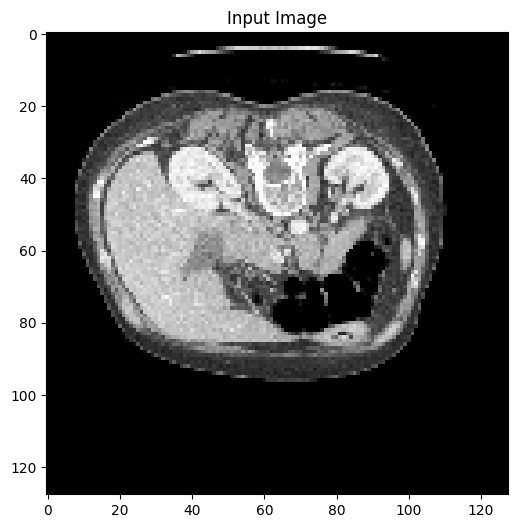

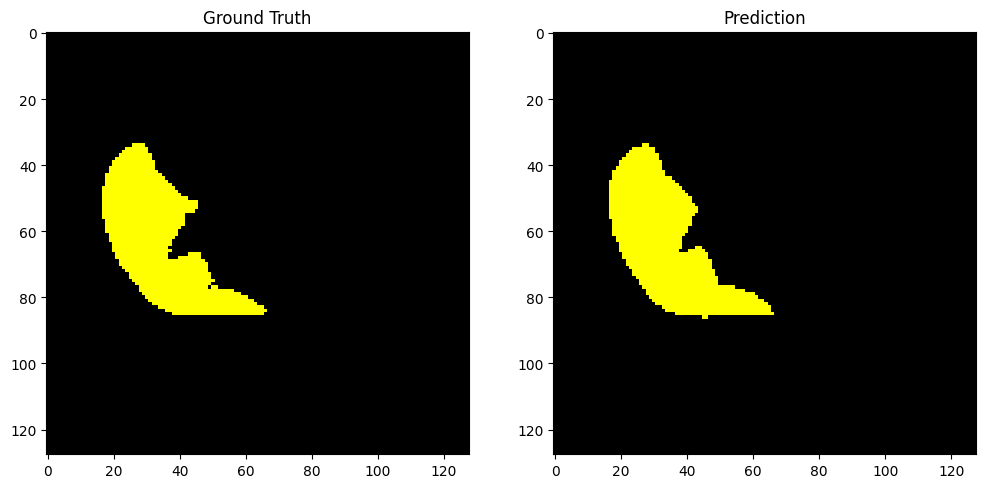

In [21]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)